In [1]:
# main01.py is a part of the PYTHIA event generator.
# Copyright (C) 2023 Torbjorn Sjostrand.
# PYTHIA is licenced under the GNU GPL v2 or later, see COPYING for details.
# Please respect the MCnet Guidelines, see GUIDELINES for details.

# Keywords: basic usage; charged multiplicity; python;

# This is a simple test program. It fits on one slide in a talk.  It
# studies the charged multiplicity distribution at the LHC.

# To set the path to the Pythia 8 Python interface do either
# (in a shell prompt):
#      export PYTHONPATH=$(PREFIX_LIB):$PYTHONPATH
# or the following which sets the path from within Python.
import sys
cfg = open("../pythia8309/Makefile.inc")
lib = "../pythia8309/lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)

# Import the Pythia module.
import pythia8
'''
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 8000.")
pythia.readString("HardQCD:all = on")
pythia.readString("SoftQCD:all = on")
pythia.readString("PhaseSpace:pTHatMin = 20.")
pythia.init()
'''

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split


2023-07-07 22:27:58.639208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 22:27:58.697334: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 22:27:58.698899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 22:27:59.484913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

In [3]:
maxEvents = 10000
maxLength = 400

In [4]:
def generateData(pythia):

    mult = pythia8.Hist("charged multiplicity", 50, -0.5, 399.5)
    pT = pythia8.Hist("transverse momentum", 50, 0.0, 5.)
    
    data = np.zeros((1,maxLength,3))

    # Begin event loop. Generate event. Skip if error. List first one.
    nChargedMax = 0
    print("start")
    for iEvent in range(0, maxEvents):
        if iEvent%1000 == 0: print(iEvent)
        if not pythia.next(): continue
        # Find number of all final charged particles and fill histogram.
        event = np.zeros((maxLength,3))
    
        nCharged = 0
        for prt in pythia.event:
            if prt.isFinal() and prt.isCharged(): 
                if nCharged < maxLength:
                    event[nCharged,0] = prt.pT()
                    event[nCharged,1] = prt.theta()
                    event[nCharged,2] = prt.phi()
                    pT.fill(prt.pT())
                nCharged += 1
                #print(nCharged)
        if iEvent%1000 == 0: print("nCharged ",nCharged) 
        # sort event by pT
        #print(event)
        event = event[event[:, 0].argsort()[::-1]]
        #print(event)
        # from all Phi angles subtract the phi of the particle with the highest pT
        phi0 = event[0,2]
        for i in range(len(event)):
            event[i,2] = (event[i,2]-phi0)%(2.*np.pi)
            if event[i,2] > np.pi:
                event[i,2] = event[i,2] - 2*np.pi

        event = event.reshape((1,maxLength,3))        
        if iEvent > -1:   
            #print(event)
            data = np.concatenate((data, event), axis=0)
        else:
            #print(event)
            data = event    
        mult.fill(nCharged)
        if nCharged > nChargedMax:
            nChargedMax = nCharged
    
    # End of event loop. Statistics. Histogram. Done.
    print(data.shape)
    #pythia.stat();
    #print(mult)

    print("Max. nCharged = ", nChargedMax)

    return data, mult, pT

In [5]:
# generate data
#pythia = pythia8.Pythia()
#pythia.readString("Beams:eCM =  13.6 TeV")
#pythia.readString("HardQCD:all = on")
#pythia.readString("SoftQCD:all = on")
#pythia.readString("PhaseSpace:pTHatMin = 20.")

#pythia.readString("MultipartonInteractions:pT0Ref = 1")
#pythia.init()

Example how to make pythia parallel (should speed it up:
https://pythia.org/latest-manual/examples/main162-python.html

In [6]:
def initPythia(pT0Ref, ecmPow, coreRadius, coreFraction):
    # generate data - PythiaParallel
    pythia = pythia8.Pythia()
    pythia.readString("Beams:eCM =  13600.")
    #pythia.readString("HardQCD:all = on")
    pythia.readString("SoftQCD:all = on")
    #pythia.readString("PhaseSpace:pTHatMin = 20.")

    auxstr = "MultipartonInteractions:pT0Ref = "+str(pT0Ref)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:ecmPow = "+str(ecmPow)
    pythia.readString(auxstr)  
    auxstr = "MultipartonInteractions:coreRadius = "+str(coreRadius)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:coreFraction = "+str(coreFraction)
    pythia.readString(auxstr) 
  
    # The maximum degree of parallelism. If set to 0 (default), the program
    # will use the maximum number of threads supported by the hardware.
    #pythia.readString("Parallelism:numThreads = 4")

    # This tells PythiaParallel to not process events asynchronously
    # (default behaviour). In Python, this should never be switched on
    # because of the Python global interpreter lock (as is done in
    # main163.cc for C++ code).
    #pythia.readString("Parallelism:processAsync = off")
    

    # This will create and initialize each underlying Pythia instance.
    #pythia.init(lambda pythiaNow:
    #print(pythiaNow.settings.mode("Parallelism:index")))
    pythia.init()

    return pythia

In [7]:

pythia = initPythia(1.5, 0.2, 0.7, 0.7)
data0, mult0, pT0 = generateData(pythia)

print("Data shape: ",data0.shape)

del pythia


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 07 Jul 2023 at 22:28:01    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

(array([2533.,  316.,  306.,  340.,  542.,  741.,  561.,  384.,  297.,
         246.,  202.,  205.,  182.,  167.,  161.,  126.,  117.,  107.,
         109.,  112.,  105.,  105.,  106.,   79.,   85.,   72.,   66.,
          72.,   65.,   70.,   70.,   66.,   66.,   50.,   53.,   70.,
          50.,   54.,   53.,   52.,   50.,   56.,   48.,   51.,   42.,
          48.,   41.,   33.,   37.,   39.]),
 array([ -0.5,   7.5,  15.5,  23.5,  31.5,  39.5,  47.5,  55.5,  63.5,
         71.5,  79.5,  87.5,  95.5, 103.5, 111.5, 119.5, 127.5, 135.5,
        143.5, 151.5, 159.5, 167.5, 175.5, 183.5, 191.5, 199.5, 207.5,
        215.5, 223.5, 231.5, 239.5, 247.5, 255.5, 263.5, 271.5, 279.5,
        287.5, 295.5, 303.5, 311.5, 319.5, 327.5, 335.5, 343.5, 351.5,
        359.5, 367.5, 375.5, 383.5, 391.5, 399.5]),
 [<matplotlib.patches.Polygon at 0x7f748ddf8f10>])

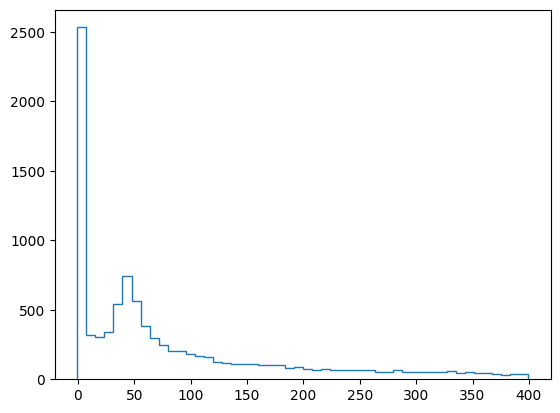

In [8]:
import matplotlib.pyplot as plt

plt.hist(mult0.getBinEdges()[:-1], mult0.getBinEdges(), 
               weights = mult0.getBinContents(), 
               histtype = "step", label = mult0.getTitle()) 

#print(mult)

(array([7.03850e+04, 1.43007e+05, 1.51341e+05, 1.31872e+05, 1.05654e+05,
        8.14870e+04, 6.13270e+04, 4.58000e+04, 3.43790e+04, 2.64800e+04,
        2.07290e+04, 1.64980e+04, 1.32880e+04, 1.08770e+04, 8.77700e+03,
        7.45600e+03, 6.16700e+03, 5.28100e+03, 4.37400e+03, 3.73500e+03,
        3.13700e+03, 2.70200e+03, 2.29900e+03, 1.90500e+03, 1.67500e+03,
        1.42600e+03, 1.19900e+03, 9.97000e+02, 8.47000e+02, 7.48000e+02,
        6.60000e+02, 5.49000e+02, 4.85000e+02, 4.60000e+02, 3.73000e+02,
        3.36000e+02, 3.08000e+02, 2.43000e+02, 2.16000e+02, 1.67000e+02,
        1.87000e+02, 1.41000e+02, 1.30000e+02, 1.14000e+02, 9.50000e+01,
        7.60000e+01, 8.90000e+01, 6.10000e+01, 5.70000e+01, 6.50000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4

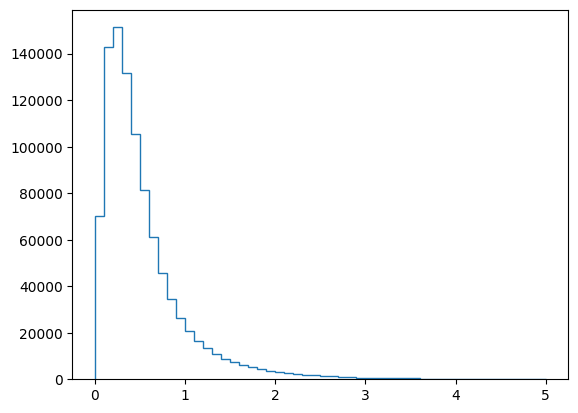

In [9]:
plt.hist(pT0.getBinEdges()[:-1], pT0.getBinEdges(), 
               weights = pT0.getBinContents(), 
               histtype = "step", label = pT0.getTitle()) 

# Implement neural network

In [10]:
def prepareData(data0,data):
    X = np.concatenate((data0,data), axis=0)
    X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

    y = np.zeros((X.shape[0],2))
    y[:data0.shape[0],0] = 1
    y[data0.shape[0]:,1] = 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle=True, random_state=42)
    return X_train, X_test, y_train, y_test

In [11]:
def createModel(shape):
    # Here is the fully connected (dense) network
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model

In [12]:
def trainModel(model, X_train, X_test, y_train, y_test):
    batch_size = 128
    epochs = 20

    history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
    return history

In [13]:
def plotAccuracy(history):
    # Plots for training and testing process: loss and accuracy


    n_epochs = len(history.history['accuracy'])

    plt.figure(0)
    plt.plot(history.history['accuracy'],'r')
    plt.plot(history.history['val_accuracy'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.show()

In [14]:
def plotLoss(history):

    n_epochs = len(history.history['loss'])
    
    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

In [15]:
def optimize(data0,pT0Ref,ecmPow,coreRadius,coreFraction):
    
    pythia = initPythia(pT0Ref,ecmPow,coreRadius,coreFraction)
    print("Pythia initialized")
    data, mult, pT = generateData(pythia)

    print("Data shape: ",data.shape)

    del pythia
    
    ###
    
    X_train, X_test, y_train, y_test = prepareData(data0,data)
    model = createModel(shape=X_train.shape[1])
    history = trainModel(model, X_train, X_test, y_train, y_test)
    plotLoss(history)
    #accuracy = np.max(history.history['val_accuracy'])
    loss = np.min(history.history['val_loss'])
    del model

    return loss

[I 2023-07-07 22:35:27,397] A new study created in memory with name: no-name-8e372101-5b79-47ed-bcbb-7115b17fa678


Optuna suggested x =  3.3568232373692886 0.12527205833804117 0.3703212139087947 0.2779209242592946
Pythia initialized
start
0
nCharged  54
1000
nCharged  32
2000
nCharged  56
3000
nCharged  10
4000
nCharged  82
5000
nCharged  6
6000
nCharged  12
7000
nCharged  110
8000
nCharged  34
9000
nCharged  174
(10001, 400, 3)
Max. nCharged =  280
Data shape:  (10001, 400, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                76864     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                  

2023-07-07 22:39:14.770325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
79/79 [==============================] - 3s 26ms/step - loss: 0.6849 - accuracy: 0.5567 - val_loss: 0.6370 - val_accuracy: 0.5850
Epoch 2/20
79/79 [==============================] - 1s 18ms/step - loss: 0.6468 - accuracy: 0.5832 - val_loss: 0.6393 - val_accuracy: 0.5895
Epoch 3/20
79/79 [==============================] - 1s 12ms/step - loss: 0.6412 - accuracy: 0.5897 - val_loss: 0.6312 - val_accuracy: 0.5958
Epoch 4/20
79/79 [==============================] - 1s 12ms/step - loss: 0.6388 - accuracy: 0.5878 - val_loss: 0.6325 - val_accuracy: 0.5891
Epoch 5/20
79/79 [==============================] - 1s 9ms/step - loss: 0.6335 - accuracy: 0.5879 - val_loss: 0.6297 - val_accuracy: 0.5943
Epoch 6/20
79/79 [==============================] - 1s 11ms/step - loss: 0.6264 - accuracy: 0.5968 - val_loss: 0.6306 - val_accuracy: 0.5972
Epoch 7/20
79/79 [==============================] - 1s 9ms/step - loss: 0.6191 - accuracy: 0.5993 - val_loss: 0.6284 - val_accuracy: 0.5975
Epoch 8/20
79/7

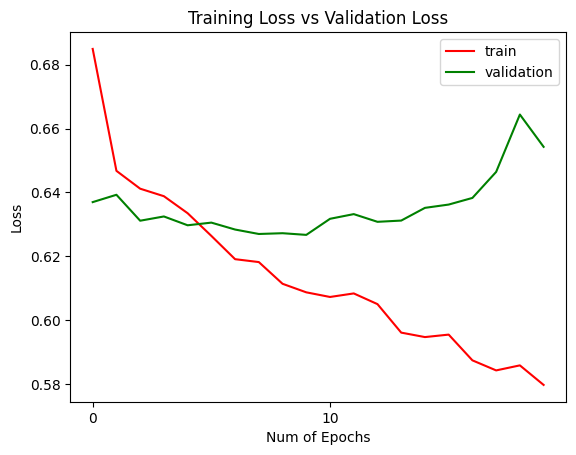

[I 2023-07-07 22:39:33,903] Trial 0 finished with value: 0.6267461776733398 and parameters: {'pT0Ref': 3.3568232373692886, 'ecmPow': 0.12527205833804117, 'coreRadius': 0.3703212139087947, 'coreFraction': 0.2779209242592946}. Best is trial 0 with value: 0.6267461776733398.


Optuna suggested x =  3.07012796020931 0.27007027819340074 0.5197931025666396 0.8700598097455213
Pythia initialized
start
0
nCharged  10
1000
nCharged  64
2000
nCharged  52
3000
nCharged  28
4000
nCharged  2
5000
nCharged  26
6000
nCharged  186
7000
nCharged  2
8000
nCharged  32
9000
nCharged  104
(10001, 400, 3)
Max. nCharged =  304
Data shape:  (10001, 400, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                76864     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                   

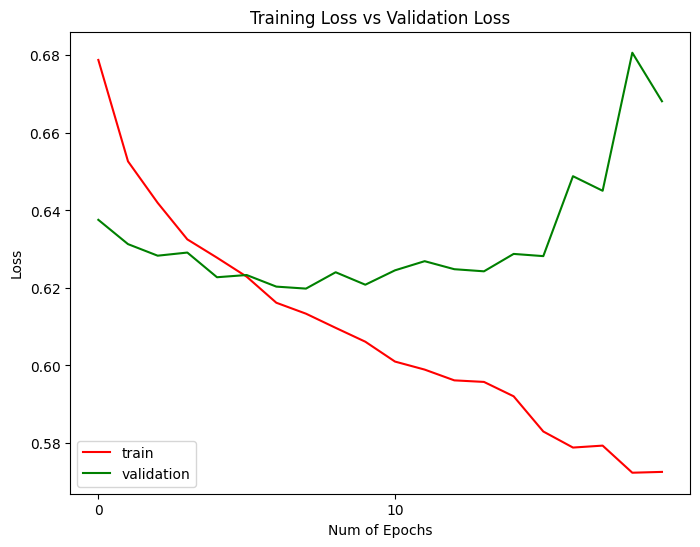

[I 2023-07-07 22:42:29,492] Trial 1 finished with value: 0.619827151298523 and parameters: {'pT0Ref': 3.07012796020931, 'ecmPow': 0.27007027819340074, 'coreRadius': 0.5197931025666396, 'coreFraction': 0.8700598097455213}. Best is trial 0 with value: 0.6267461776733398.


Optuna suggested x =  1.093499066464454 0.1333587983009292 0.7813554837213798 0.758305531059829
Pythia initialized
start
0
nCharged  554
1000
nCharged  58
2000
nCharged  700
3000
nCharged  164
4000
nCharged  260
5000
nCharged  322
6000
nCharged  56
7000
nCharged  58
8000
nCharged  44
9000
nCharged  30
(10001, 400, 3)
Max. nCharged =  776
Data shape:  (10001, 400, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                76864     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
               

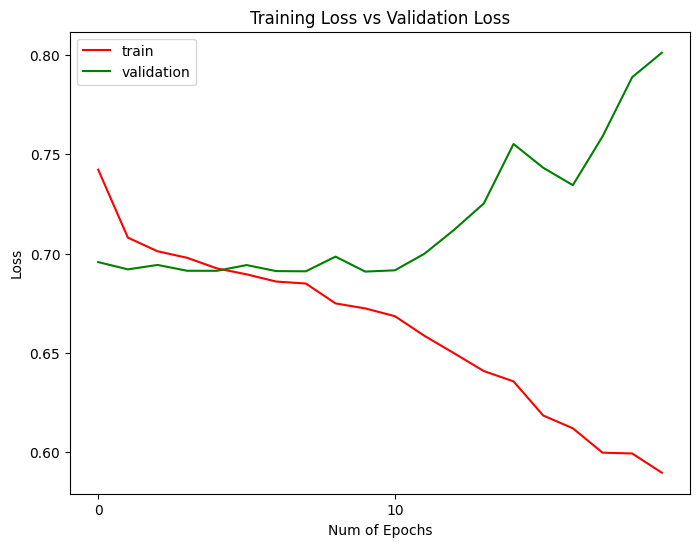

[I 2023-07-07 22:46:40,582] Trial 2 finished with value: 0.6908822655677795 and parameters: {'pT0Ref': 1.093499066464454, 'ecmPow': 0.1333587983009292, 'coreRadius': 0.7813554837213798, 'coreFraction': 0.758305531059829}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  2.4518610408346255 0.15855711870011407 0.44551560989923045 0.9389730905207139
Pythia initialized
start
0
nCharged  46
1000
nCharged  278
2000
nCharged  48
3000
nCharged  34
4000
nCharged  2
5000
nCharged  132
6000
nCharged  24
7000
nCharged  58
8000
nCharged  36
9000
nCharged  18
(10001, 400, 3)
Max. nCharged =  430
Data shape:  (10001, 400, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                76864     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
               

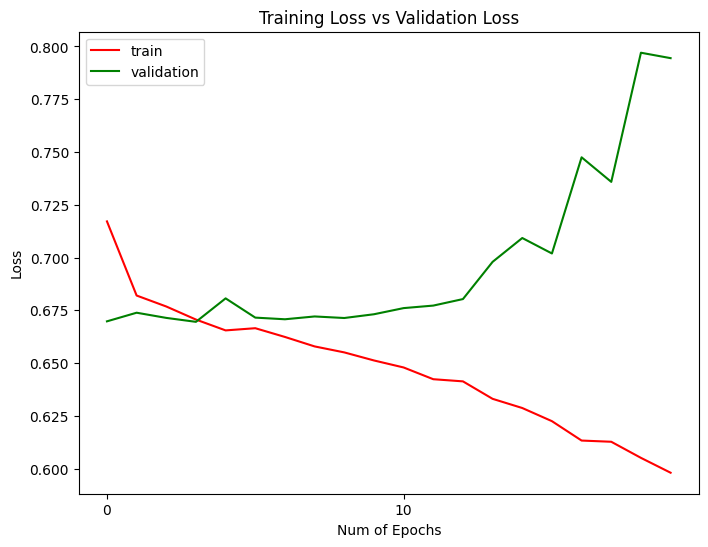

[I 2023-07-07 22:50:10,314] Trial 3 finished with value: 0.6695302128791809 and parameters: {'pT0Ref': 2.4518610408346255, 'ecmPow': 0.15855711870011407, 'coreRadius': 0.44551560989923045, 'coreFraction': 0.9389730905207139}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  3.403792618733934 0.024696122304881298 0.17667778399052414 0.2353269790066867
Pythia initialized
start
0
nCharged  54
1000
nCharged  64
2000
nCharged  28
3000
nCharged  28
4000
nCharged  100
5000
nCharged  42
6000
nCharged  2
7000
nCharged  32
8000
nCharged  58
9000
nCharged  156
(10001, 400, 3)
Max. nCharged =  292
Data shape:  (10001, 400, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                76864     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
               

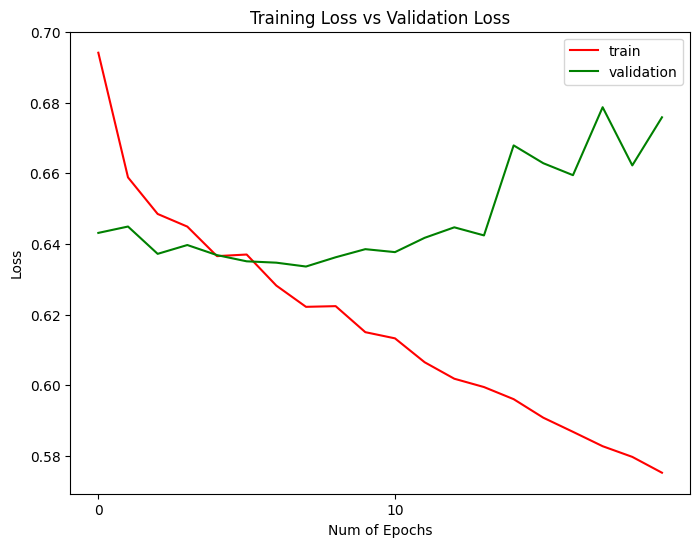

[I 2023-07-07 22:54:00,929] Trial 4 finished with value: 0.6336280703544617 and parameters: {'pT0Ref': 3.403792618733934, 'ecmPow': 0.024696122304881298, 'coreRadius': 0.17667778399052414, 'coreFraction': 0.2353269790066867}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  2.7087017595355887 0.12992301788000446 0.6876353939693024 0.9318226878215466
Pythia initialized
start
0
nCharged  124
1000
nCharged  2
2000
nCharged  36
3000
nCharged  16
4000
nCharged  2
5000
nCharged  26
6000
nCharged  54
7000
nCharged  2
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  380
Data shape:  (10001, 400, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                76864     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                     

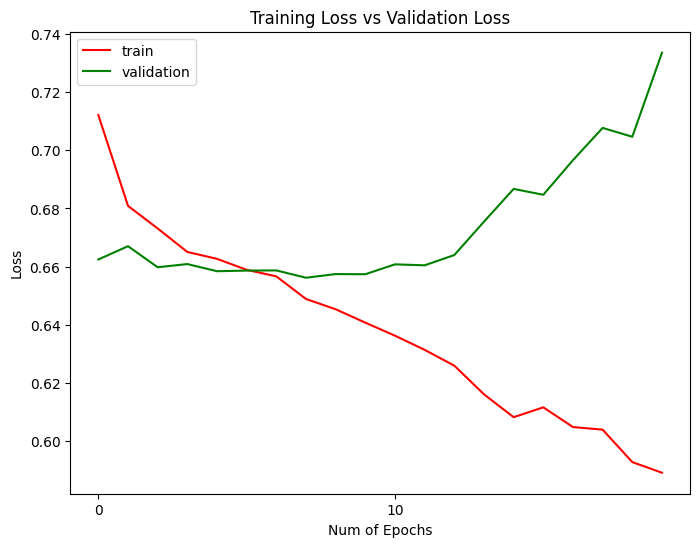

[I 2023-07-07 22:57:13,464] Trial 5 finished with value: 0.6561799049377441 and parameters: {'pT0Ref': 2.7087017595355887, 'ecmPow': 0.12992301788000446, 'coreRadius': 0.6876353939693024, 'coreFraction': 0.9318226878215466}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  2.3515260309636687 0.16268187633718367 0.4572364037484078 0.12144452227737434
Pythia initialized
start
0
nCharged  190
1000
nCharged  2
2000
nCharged  2
3000
nCharged  46
4000
nCharged  2
5000
nCharged  2
6000
nCharged  198
7000
nCharged  42
8000
nCharged  18
9000
nCharged  8
(10001, 400, 3)
Max. nCharged =  448
Data shape:  (10001, 400, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                76864     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                   

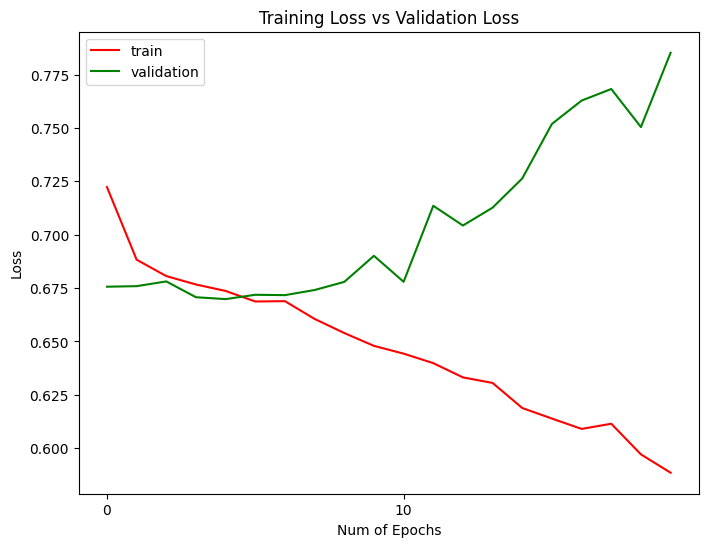

[I 2023-07-07 23:00:16,854] Trial 6 finished with value: 0.6698221564292908 and parameters: {'pT0Ref': 2.3515260309636687, 'ecmPow': 0.16268187633718367, 'coreRadius': 0.4572364037484078, 'coreFraction': 0.12144452227737434}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  2.7588691842050515 0.2754189247346159 0.4624927032766699 0.5417468836093766
Pythia initialized
start
0
nCharged  2
1000
nCharged  56
2000
nCharged  2
3000
nCharged  56
4000
nCharged  2
5000
nCharged  2
6000
nCharged  52
7000
nCharged  2
8000
nCharged  38
9000
nCharged  156
(10001, 400, 3)
Max. nCharged =  324
Data shape:  (10001, 400, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                76864     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                      

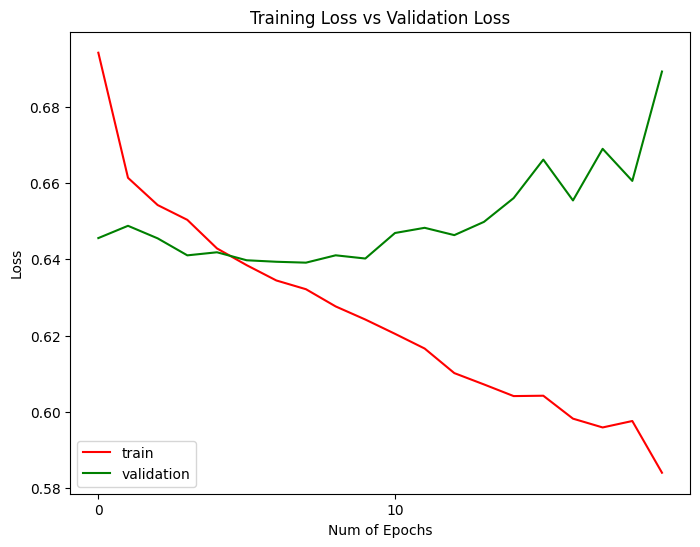

[I 2023-07-07 23:03:03,683] Trial 7 finished with value: 0.6391189694404602 and parameters: {'pT0Ref': 2.7588691842050515, 'ecmPow': 0.2754189247346159, 'coreRadius': 0.4624927032766699, 'coreFraction': 0.5417468836093766}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  3.4378550143582194 0.10275291186958305 0.8139488596139594 0.8658192028442887
Pythia initialized
start
0
nCharged  2
1000
nCharged  76
2000
nCharged  2
3000
nCharged  64
4000
nCharged  2
5000
nCharged  50
6000
nCharged  58
7000
nCharged  86
8000
nCharged  80
9000
nCharged  36
(10001, 400, 3)
Max. nCharged =  310
Data shape:  (10001, 400, 3)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                76864     
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                    

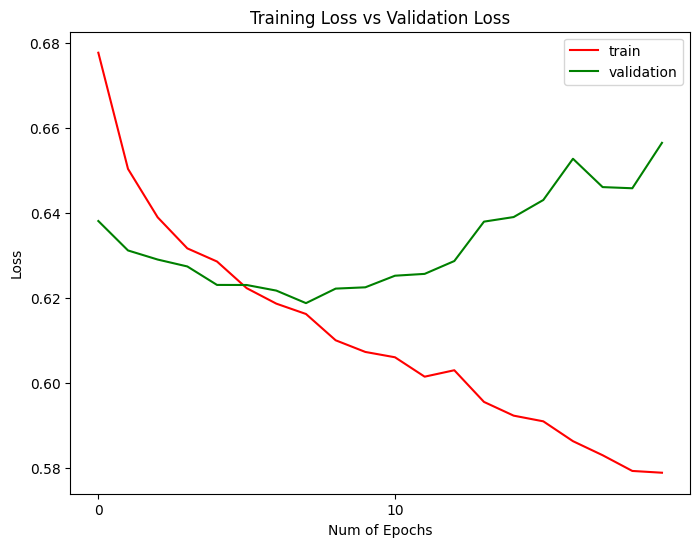

[I 2023-07-07 23:06:24,356] Trial 8 finished with value: 0.6188050508499146 and parameters: {'pT0Ref': 3.4378550143582194, 'ecmPow': 0.10275291186958305, 'coreRadius': 0.8139488596139594, 'coreFraction': 0.8658192028442887}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  2.0971136761313103 0.34295364213668533 0.13483375568891703 0.9577248136710018
Pythia initialized
start
0
nCharged  56
1000
nCharged  72
2000
nCharged  32
3000
nCharged  2
4000
nCharged  232
5000
nCharged  18
6000
nCharged  2
7000
nCharged  52
8000
nCharged  106
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  468
Data shape:  (10001, 400, 3)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                76864     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                

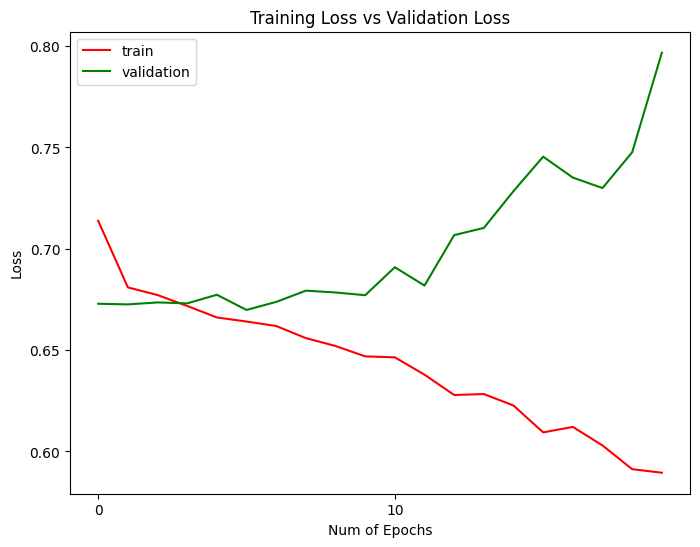

[I 2023-07-07 23:09:07,284] Trial 9 finished with value: 0.6698241233825684 and parameters: {'pT0Ref': 2.0971136761313103, 'ecmPow': 0.34295364213668533, 'coreRadius': 0.13483375568891703, 'coreFraction': 0.9577248136710018}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  0.969141406704854 0.023895714834435783 0.9965291293744424 0.6581508834636921
Pythia initialized
start
0
nCharged  2
1000
nCharged  454
2000
nCharged  172
3000
nCharged  2
4000
nCharged  172
5000
nCharged  254
6000
nCharged  366
7000
nCharged  2
8000
nCharged  106
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  836
Data shape:  (10001, 400, 3)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                76864     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
              

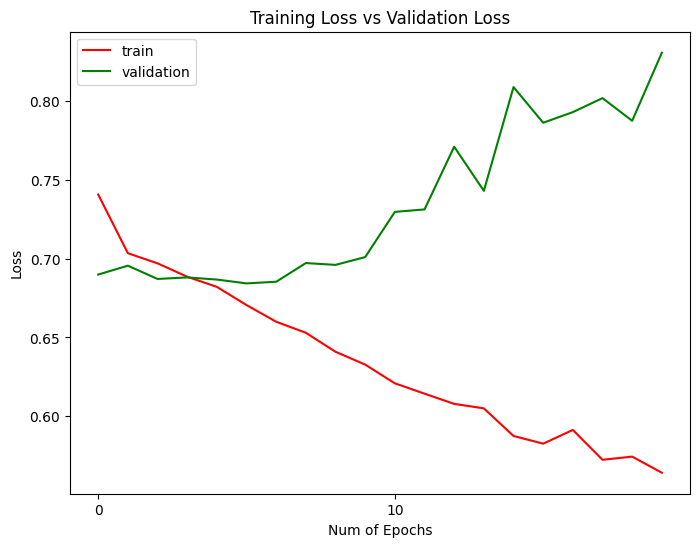

[I 2023-07-07 23:15:56,572] Trial 10 finished with value: 0.6842756867408752 and parameters: {'pT0Ref': 0.969141406704854, 'ecmPow': 0.023895714834435783, 'coreRadius': 0.9965291293744424, 'coreFraction': 0.6581508834636921}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  0.8688071030964591 0.022244814967525988 0.9989242872325028 0.6787369285216525
Pythia initialized
start
0
nCharged  66
1000
nCharged  72
2000
nCharged  26
3000
nCharged  2
4000
nCharged  78
5000
nCharged  2
6000
nCharged  74
7000
nCharged  118
8000
nCharged  2
9000
nCharged  68
(10001, 400, 3)
Max. nCharged =  844
Data shape:  (10001, 400, 3)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                76864     
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                 

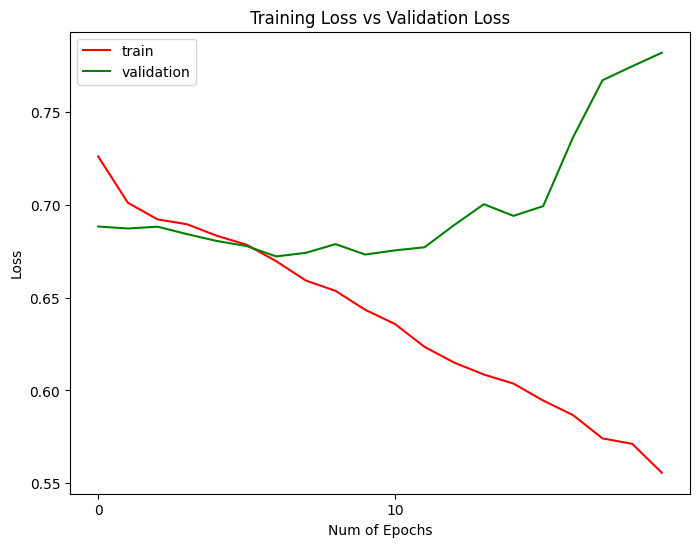

[I 2023-07-07 23:26:07,304] Trial 11 finished with value: 0.6721164584159851 and parameters: {'pT0Ref': 0.8688071030964591, 'ecmPow': 0.022244814967525988, 'coreRadius': 0.9989242872325028, 'coreFraction': 0.6787369285216525}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  0.6712615612062747 0.04996305441218168 0.9533252800508198 0.6428741478646194
Pythia initialized
start
0
nCharged  154
1000
nCharged  32
2000
nCharged  28
3000
nCharged  56
4000
nCharged  82
5000
nCharged  278
6000
nCharged  46
7000
nCharged  148
8000
nCharged  2
9000
nCharged  68
(10001, 400, 3)
Max. nCharged =  816
Data shape:  (10001, 400, 3)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                76864     
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 64)                4160      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
              

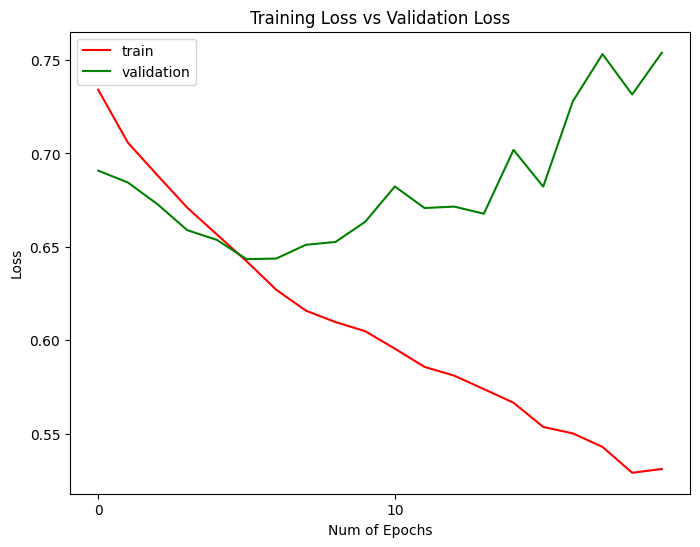

[I 2023-07-07 23:45:31,798] Trial 12 finished with value: 0.643404483795166 and parameters: {'pT0Ref': 0.6712615612062747, 'ecmPow': 0.04996305441218168, 'coreRadius': 0.9533252800508198, 'coreFraction': 0.6428741478646194}. Best is trial 2 with value: 0.6908822655677795.


Optuna suggested x =  1.2809621586298845 0.10132524610167237 0.8339266874761441 0.7472610370424216
Pythia initialized
start
0
nCharged  78
1000
nCharged  28
2000
nCharged  388
3000
nCharged  40
4000
nCharged  54
5000
nCharged  92
6000
nCharged  320
7000
nCharged  6
8000
nCharged  2
9000
nCharged  308
(10001, 400, 3)
Max. nCharged =  784
Data shape:  (10001, 400, 3)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                76864     
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
               

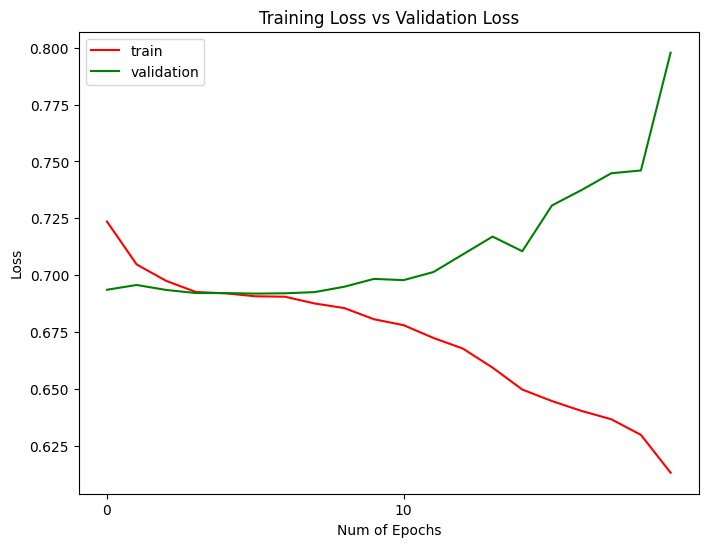

[I 2023-07-07 23:49:16,063] Trial 13 finished with value: 0.6918768286705017 and parameters: {'pT0Ref': 1.2809621586298845, 'ecmPow': 0.10132524610167237, 'coreRadius': 0.8339266874761441, 'coreFraction': 0.7472610370424216}. Best is trial 13 with value: 0.6918768286705017.


Optuna suggested x =  1.360870188986302 0.07823577813305774 0.7216634667436161 0.7661889657458502
Pythia initialized
start
0
nCharged  596
1000
nCharged  292
2000
nCharged  2
3000
nCharged  504
4000
nCharged  2
5000
nCharged  56
6000
nCharged  98
7000
nCharged  52
8000
nCharged  2
9000
nCharged  34
(10001, 400, 3)
Max. nCharged =  712
Data shape:  (10001, 400, 3)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                76864     
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                 

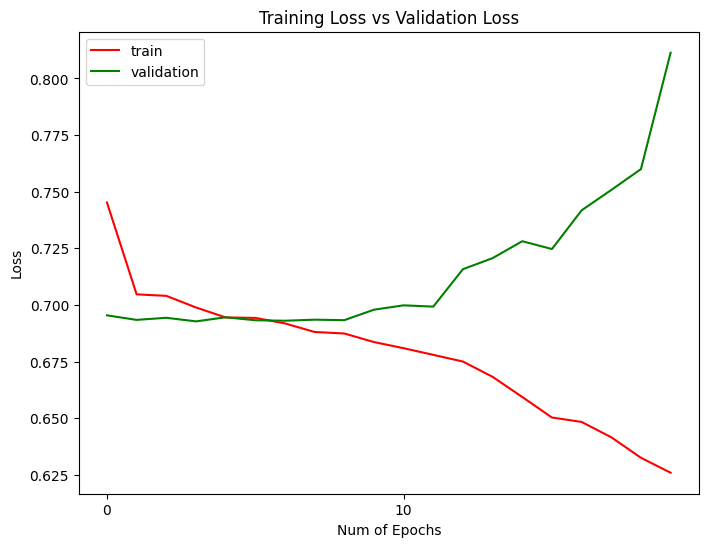

[I 2023-07-07 23:52:56,044] Trial 14 finished with value: 0.6927620768547058 and parameters: {'pT0Ref': 1.360870188986302, 'ecmPow': 0.07823577813305774, 'coreRadius': 0.7216634667436161, 'coreFraction': 0.7661889657458502}. Best is trial 14 with value: 0.6927620768547058.


Optuna suggested x =  1.5926937022292107 0.07670599896751296 0.607751374905483 0.4951723947898925
Pythia initialized
start
0
nCharged  278
1000
nCharged  2
2000
nCharged  318
3000
nCharged  2
4000
nCharged  4
5000
nCharged  2
6000
nCharged  78
7000
nCharged  2
8000
nCharged  24
9000
nCharged  38
(10001, 400, 3)
Max. nCharged =  664
Data shape:  (10001, 400, 3)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                76864     
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                    

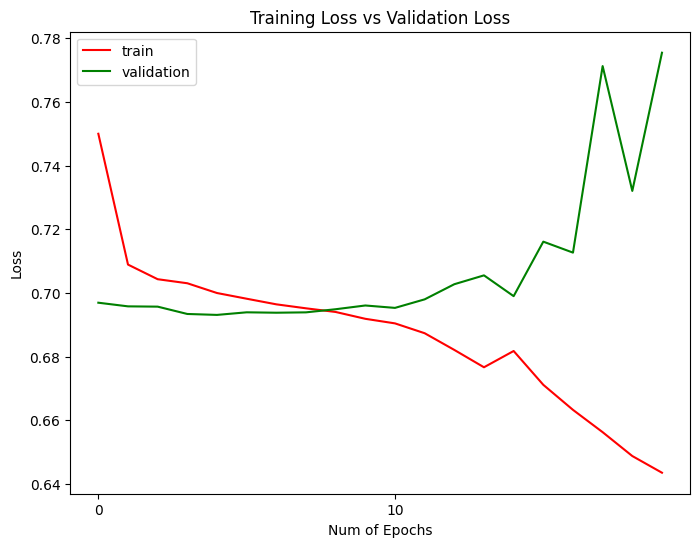

[I 2023-07-07 23:56:23,721] Trial 15 finished with value: 0.6931031942367554 and parameters: {'pT0Ref': 1.5926937022292107, 'ecmPow': 0.07670599896751296, 'coreRadius': 0.607751374905483, 'coreFraction': 0.4951723947898925}. Best is trial 15 with value: 0.6931031942367554.


Optuna suggested x =  1.7288042299963777 0.07982854841691334 0.6460145314556781 0.5012546369265656
Pythia initialized
start
0
nCharged  2
1000
nCharged  42
2000
nCharged  4
3000
nCharged  2
4000
nCharged  42
5000
nCharged  214
6000
nCharged  6
7000
nCharged  2
8000
nCharged  40
9000
nCharged  316
(10001, 400, 3)
Max. nCharged =  578
Data shape:  (10001, 400, 3)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                76864     
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                   

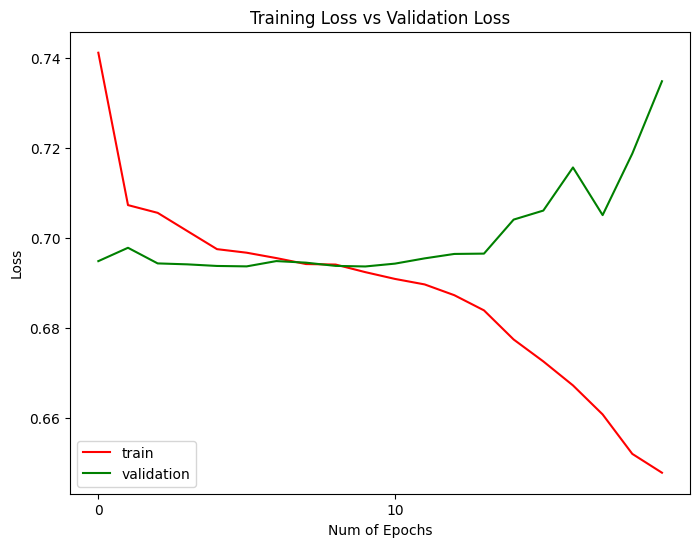

[I 2023-07-07 23:59:47,092] Trial 16 finished with value: 0.6935874223709106 and parameters: {'pT0Ref': 1.7288042299963777, 'ecmPow': 0.07982854841691334, 'coreRadius': 0.6460145314556781, 'coreFraction': 0.5012546369265656}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.7397426858378542 0.0692172749934796 0.6196901429347748 0.48922007024025727
Pythia initialized
start
0
nCharged  354
1000
nCharged  220
2000
nCharged  166
3000
nCharged  34
4000
nCharged  2
5000
nCharged  90
6000
nCharged  42
7000
nCharged  58
8000
nCharged  38
9000
nCharged  132
(10001, 400, 3)
Max. nCharged =  610
Data shape:  (10001, 400, 3)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 64)                76864     
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
             

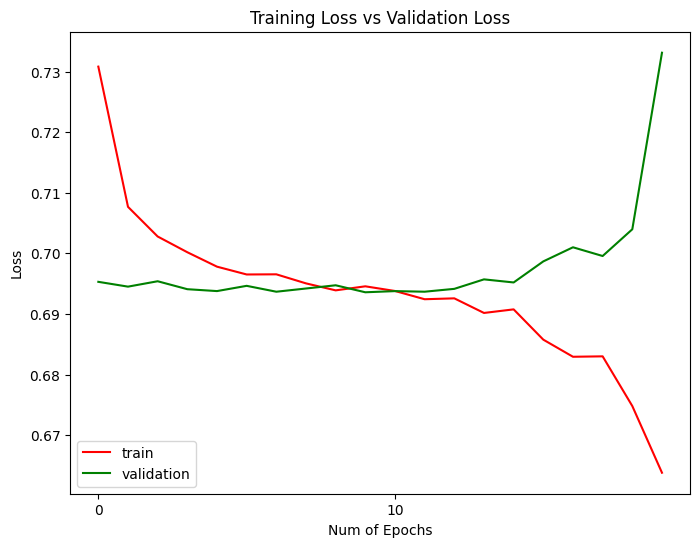

[I 2023-07-08 00:03:13,214] Trial 17 finished with value: 0.6935798525810242 and parameters: {'pT0Ref': 1.7397426858378542, 'ecmPow': 0.0692172749934796, 'coreRadius': 0.6196901429347748, 'coreFraction': 0.48922007024025727}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.8355589724940682 0.197453773637229 0.6290297730128727 0.4535058156544771
Pythia initialized
start
0
nCharged  4
1000
nCharged  364
2000
nCharged  104
3000
nCharged  16
4000
nCharged  4
5000
nCharged  2
6000
nCharged  2
7000
nCharged  34
8000
nCharged  114
9000
nCharged  198
(10001, 400, 3)
Max. nCharged =  554
Data shape:  (10001, 400, 3)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 64)                76864     
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                  

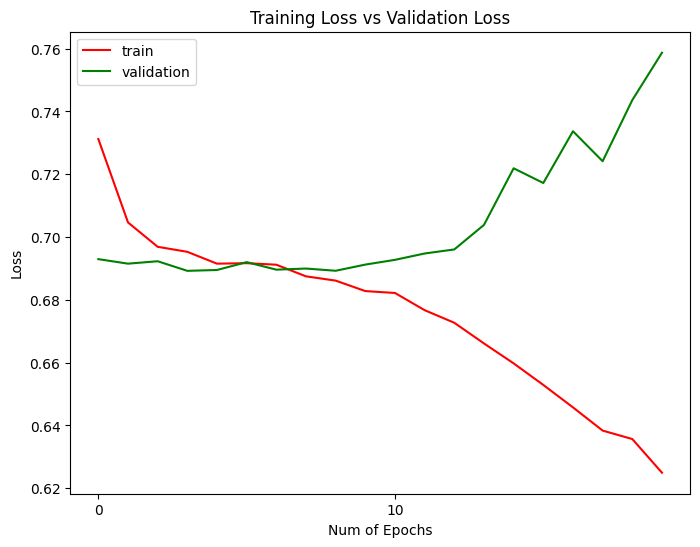

[I 2023-07-08 00:06:13,530] Trial 18 finished with value: 0.6892464756965637 and parameters: {'pT0Ref': 1.8355589724940682, 'ecmPow': 0.197453773637229, 'coreRadius': 0.6290297730128727, 'coreFraction': 0.4535058156544771}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.8067631691419215 0.06098461132167719 0.5859575466934225 0.40814506477459356
Pythia initialized
start
0
nCharged  48
1000
nCharged  2
2000
nCharged  2
3000
nCharged  54
4000
nCharged  46
5000
nCharged  62
6000
nCharged  2
7000
nCharged  42
8000
nCharged  34
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  630
Data shape:  (10001, 400, 3)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 64)                76864     
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 64)                4160      
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                   

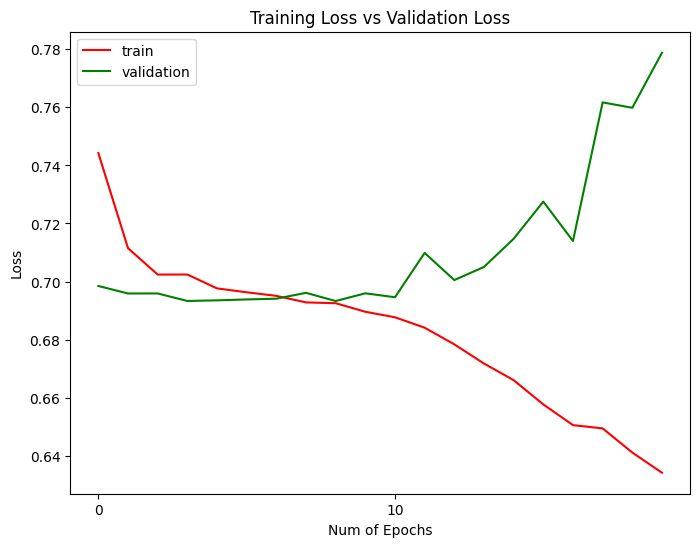

[I 2023-07-08 00:09:39,146] Trial 19 finished with value: 0.6932690739631653 and parameters: {'pT0Ref': 1.8067631691419215, 'ecmPow': 0.06098461132167719, 'coreRadius': 0.5859575466934225, 'coreFraction': 0.40814506477459356}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  3.8022402205799755 0.05966130386028849 0.6772050551623814 0.39101985664517813
Pythia initialized
start
0
nCharged  32
1000
nCharged  2
2000
nCharged  22
3000
nCharged  58
4000
nCharged  6
5000
nCharged  34
6000
nCharged  92
7000
nCharged  2
8000
nCharged  18
9000
nCharged  4
(10001, 400, 3)
Max. nCharged =  276
Data shape:  (10001, 400, 3)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 64)                76864     
                                                                 
 dropout_60 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 64)                4160      
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                   

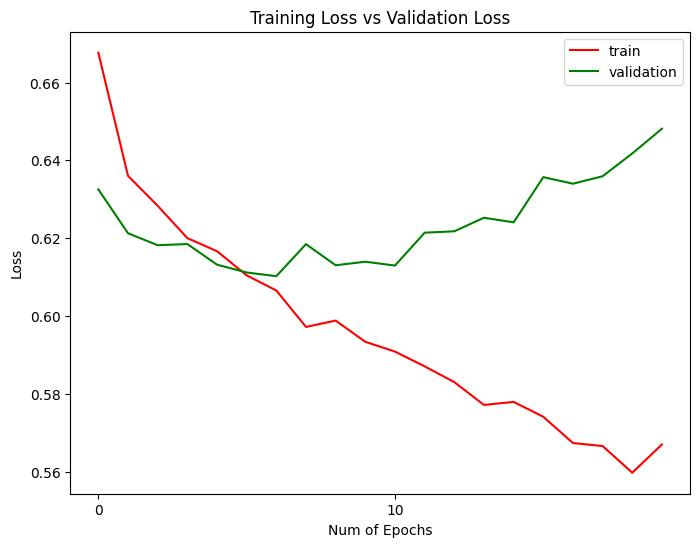

[I 2023-07-08 00:13:19,224] Trial 20 finished with value: 0.6102322340011597 and parameters: {'pT0Ref': 3.8022402205799755, 'ecmPow': 0.05966130386028849, 'coreRadius': 0.6772050551623814, 'coreFraction': 0.39101985664517813}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.905022771561024 0.06602436002545141 0.5999923160400757 0.39122898613006996
Pythia initialized
start
0
nCharged  2
1000
nCharged  40
2000
nCharged  302
3000
nCharged  36
4000
nCharged  152
5000
nCharged  162
6000
nCharged  44
7000
nCharged  198
8000
nCharged  2
9000
nCharged  54
(10001, 400, 3)
Max. nCharged =  646
Data shape:  (10001, 400, 3)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                76864     
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_85 (Dense)            (None, 64)                4160      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
              

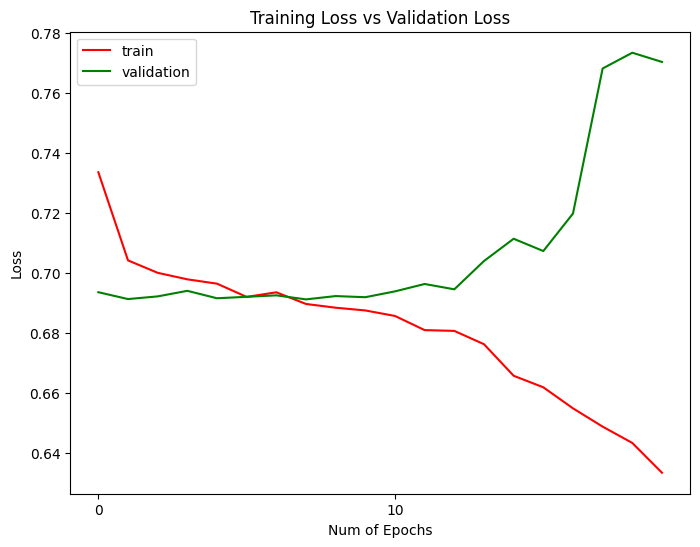

[I 2023-07-08 00:16:44,978] Trial 21 finished with value: 0.6912423372268677 and parameters: {'pT0Ref': 1.905022771561024, 'ecmPow': 0.06602436002545141, 'coreRadius': 0.5999923160400757, 'coreFraction': 0.39122898613006996}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.5784959488770802 0.0259998906643433 0.5670200333941536 0.5726338571935672
Pythia initialized
start
0
nCharged  208
1000
nCharged  2
2000
nCharged  514
3000
nCharged  2
4000
nCharged  44
5000
nCharged  42
6000
nCharged  44
7000
nCharged  32
8000
nCharged  98
9000
nCharged  524
(10001, 400, 3)
Max. nCharged =  672
Data shape:  (10001, 400, 3)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                76864     
                                                                 
 dropout_66 (Dropout)        (None, 64)                0         
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                

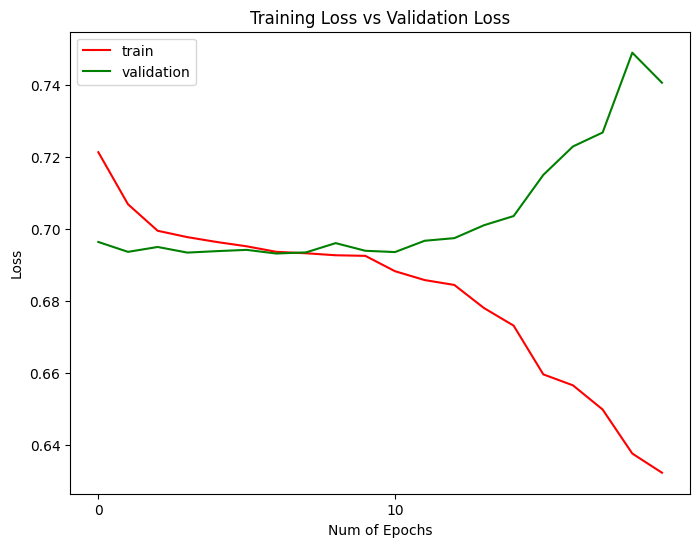

[I 2023-07-08 00:20:29,101] Trial 22 finished with value: 0.6931881904602051 and parameters: {'pT0Ref': 1.5784959488770802, 'ecmPow': 0.0259998906643433, 'coreRadius': 0.5670200333941536, 'coreFraction': 0.5726338571935672}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.8952245132120025 0.010256711643100318 0.5527983436640153 0.43341034654157234
Pythia initialized
start
0
nCharged  32
1000
nCharged  2
2000
nCharged  46
3000
nCharged  2
4000
nCharged  18
5000
nCharged  110
6000
nCharged  2
7000
nCharged  6
8000
nCharged  66
9000
nCharged  6
(10001, 400, 3)
Max. nCharged =  640
Data shape:  (10001, 400, 3)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 64)                76864     
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dropout_70 (Dropout)        (None, 64)                0         
                  

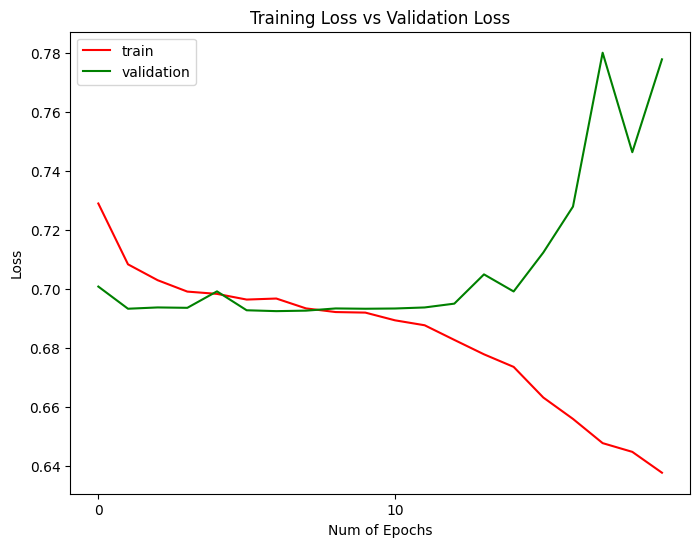

[I 2023-07-08 00:24:06,457] Trial 23 finished with value: 0.6924660801887512 and parameters: {'pT0Ref': 1.8952245132120025, 'ecmPow': 0.010256711643100318, 'coreRadius': 0.5527983436640153, 'coreFraction': 0.43341034654157234}. Best is trial 16 with value: 0.6935874223709106.


Optuna suggested x =  1.6140815087638405 0.09913901436009062 0.7299139851764496 0.5453558068205907
Pythia initialized
start
0
nCharged  292
1000
nCharged  8
2000
nCharged  70
3000
nCharged  32
4000
nCharged  2
5000
nCharged  2
6000
nCharged  56
7000
nCharged  2
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  658
Data shape:  (10001, 400, 3)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                76864     
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                     

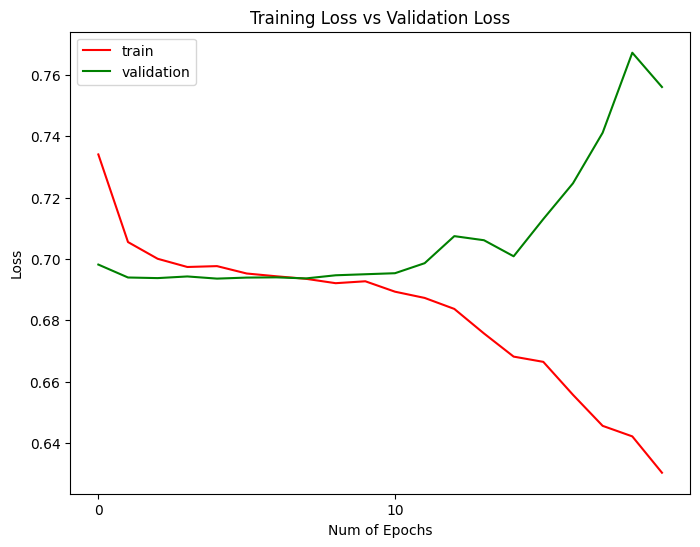

[I 2023-07-08 00:27:26,211] Trial 24 finished with value: 0.6935969591140747 and parameters: {'pT0Ref': 1.6140815087638405, 'ecmPow': 0.09913901436009062, 'coreRadius': 0.7299139851764496, 'coreFraction': 0.5453558068205907}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.163405852983908 0.09919101865952769 0.7660112335347772 0.581565415956335
Pythia initialized
start
0
nCharged  54
1000
nCharged  74
2000
nCharged  68
3000
nCharged  2
4000
nCharged  120
5000
nCharged  24
6000
nCharged  2
7000
nCharged  2
8000
nCharged  172
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  512
Data shape:  (10001, 400, 3)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 64)                76864     
                                                                 
 dropout_75 (Dropout)        (None, 64)                0         
                                                                 
 dense_101 (Dense)           (None, 64)                4160      
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                    

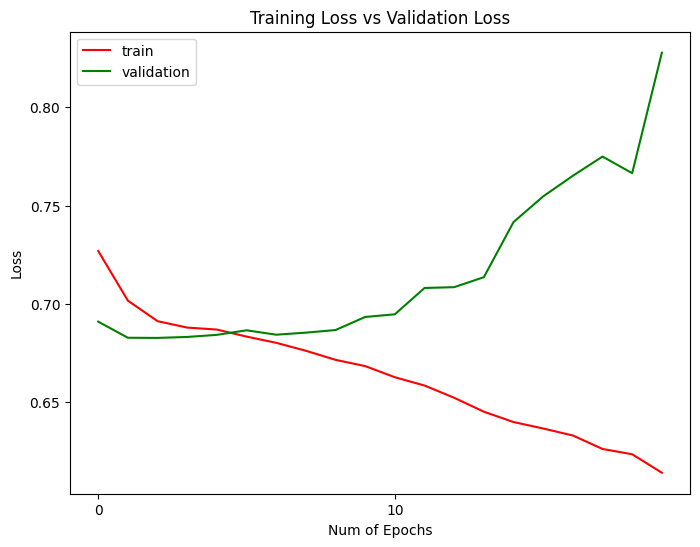

[I 2023-07-08 00:30:39,425] Trial 25 finished with value: 0.6827318668365479 and parameters: {'pT0Ref': 2.163405852983908, 'ecmPow': 0.09919101865952769, 'coreRadius': 0.7660112335347772, 'coreFraction': 0.581565415956335}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.2947376034312468 0.09479700128209942 0.8874823588370953 0.49534719605340405
Pythia initialized
start
0
nCharged  112
1000
nCharged  218
2000
nCharged  38
3000
nCharged  510
4000
nCharged  40
5000
nCharged  66
6000
nCharged  2
7000
nCharged  358
8000
nCharged  2
9000
nCharged  60
(10001, 400, 3)
Max. nCharged =  772
Data shape:  (10001, 400, 3)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 64)                76864     
                                                                 
 dropout_78 (Dropout)        (None, 64)                0         
                                                                 
 dense_105 (Dense)           (None, 64)                4160      
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
             

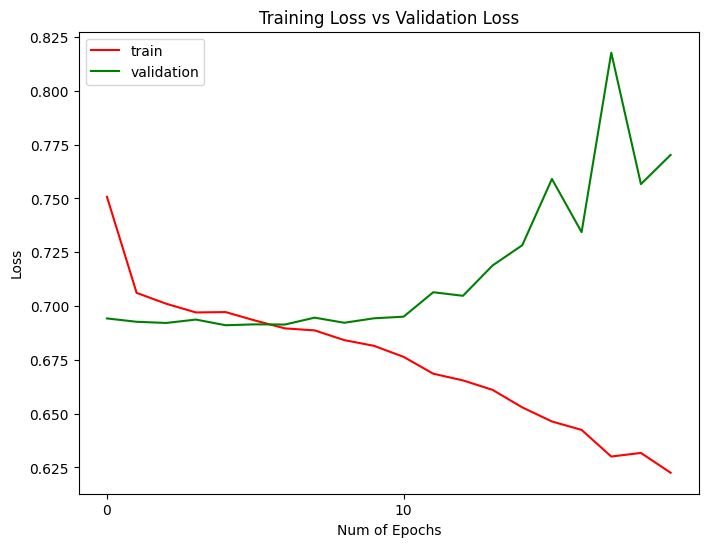

[I 2023-07-08 00:34:20,838] Trial 26 finished with value: 0.6910649538040161 and parameters: {'pT0Ref': 1.2947376034312468, 'ecmPow': 0.09479700128209942, 'coreRadius': 0.8874823588370953, 'coreFraction': 0.49534719605340405}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.569428809305605 0.04962082434088172 0.6861050254563626 0.5220292094120844
Pythia initialized
start
0
nCharged  2
1000
nCharged  92
2000
nCharged  2
3000
nCharged  196
4000
nCharged  2
5000
nCharged  206
6000
nCharged  26
7000
nCharged  54
8000
nCharged  30
9000
nCharged  16
(10001, 400, 3)
Max. nCharged =  662
Data shape:  (10001, 400, 3)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                76864     
                                                                 
 dropout_81 (Dropout)        (None, 64)                0         
                                                                 
 dense_109 (Dense)           (None, 64)                4160      
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                  

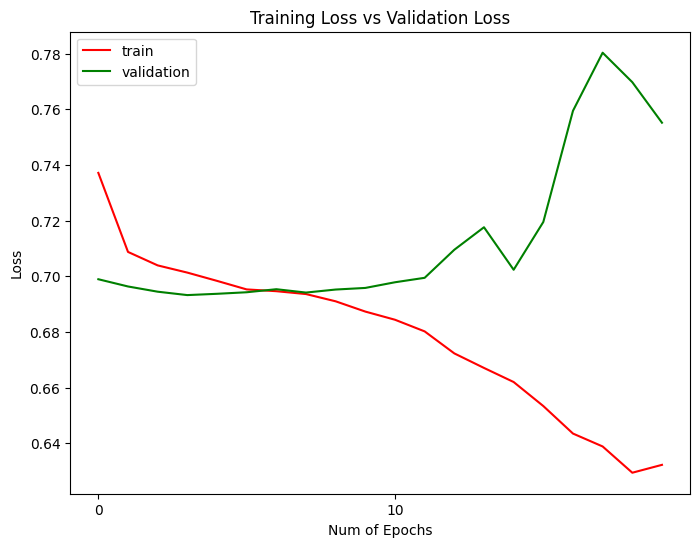

[I 2023-07-08 00:37:55,125] Trial 27 finished with value: 0.6932361721992493 and parameters: {'pT0Ref': 1.569428809305605, 'ecmPow': 0.04962082434088172, 'coreRadius': 0.6861050254563626, 'coreFraction': 0.5220292094120844}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  0.5694556924151963 5.625043700739629e-05 0.740079469254072 0.604958159806271
Pythia initialized
start
0
nCharged  46
1000
nCharged  202
2000
nCharged  342
3000
nCharged  42
4000
nCharged  2
5000
nCharged  156
6000
nCharged  2
7000
nCharged  300
8000
nCharged  32
9000
nCharged  44
(10001, 400, 3)
Max. nCharged =  748
Data shape:  (10001, 400, 3)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 64)                76864     
                                                                 
 dropout_84 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 64)                4160      
                                                                 
 dropout_85 (Dropout)        (None, 64)                0         
              

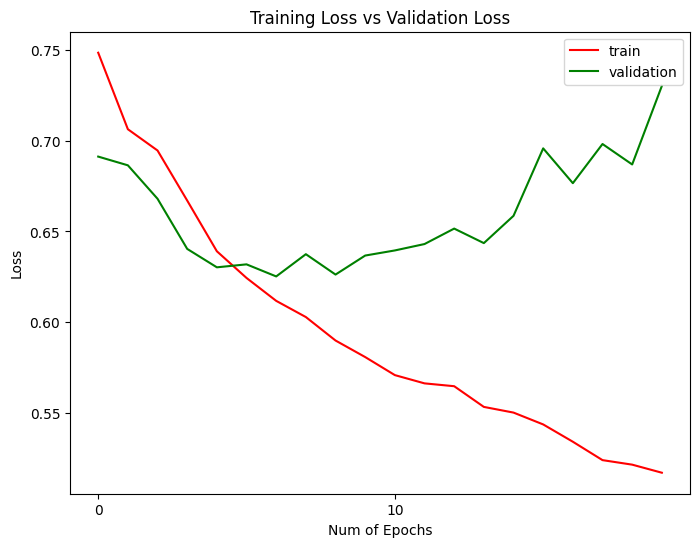

[I 2023-07-08 01:07:41,404] Trial 28 finished with value: 0.6251987814903259 and parameters: {'pT0Ref': 0.5694556924151963, 'ecmPow': 5.625043700739629e-05, 'coreRadius': 0.740079469254072, 'coreFraction': 0.604958159806271}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.1612930895318656 0.12098580146580484 0.6567080564027051 0.30567416824482874
Pythia initialized
start
0
nCharged  56
1000
nCharged  54
2000
nCharged  282
3000
nCharged  86
4000
nCharged  2
5000
nCharged  50
6000
nCharged  2
7000
nCharged  44
8000
nCharged  146
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  538
Data shape:  (10001, 400, 3)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 64)                76864     
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dropout_88 (Dropout)        (None, 64)                0         
                

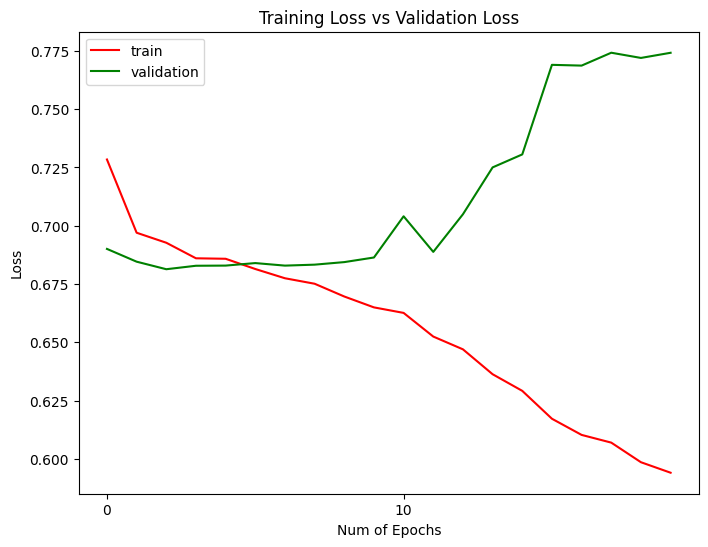

[I 2023-07-08 01:10:47,449] Trial 29 finished with value: 0.6813606023788452 and parameters: {'pT0Ref': 2.1612930895318656, 'ecmPow': 0.12098580146580484, 'coreRadius': 0.6567080564027051, 'coreFraction': 0.30567416824482874}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.5890519649730988 0.17791508475352974 0.730229838547138 0.3416125545379799
Pythia initialized
start
0
nCharged  134
1000
nCharged  308
2000
nCharged  10
3000
nCharged  176
4000
nCharged  88
5000
nCharged  244
6000
nCharged  54
7000
nCharged  50
8000
nCharged  2
9000
nCharged  82
(10001, 400, 3)
Max. nCharged =  658
Data shape:  (10001, 400, 3)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                76864     
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 64)                4160      
                                                                 
 dropout_91 (Dropout)        (None, 64)                0         
              

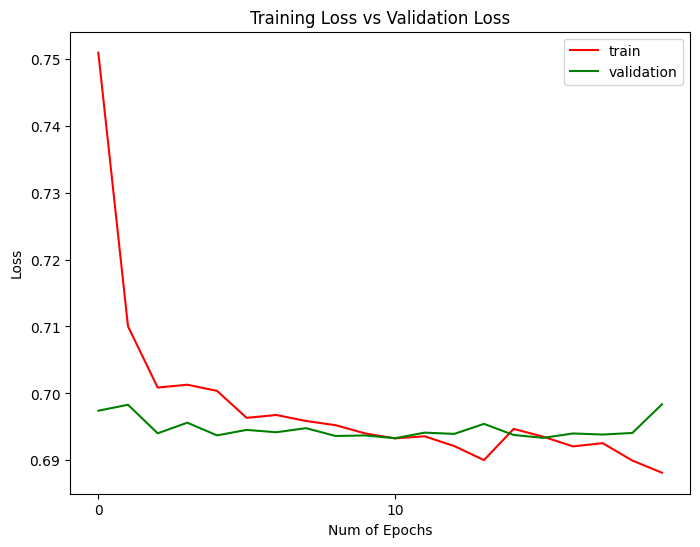

[I 2023-07-08 01:13:58,995] Trial 30 finished with value: 0.6933064460754395 and parameters: {'pT0Ref': 1.5890519649730988, 'ecmPow': 0.17791508475352974, 'coreRadius': 0.730229838547138, 'coreFraction': 0.3416125545379799}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.6237319101114083 0.15055054467623227 0.7303067605577159 0.4668806717911092
Pythia initialized
start
0
nCharged  2
1000
nCharged  14
2000
nCharged  80
3000
nCharged  96
4000
nCharged  208
5000
nCharged  62
6000
nCharged  36
7000
nCharged  2
8000
nCharged  56
9000
nCharged  54
(10001, 400, 3)
Max. nCharged =  654
Data shape:  (10001, 400, 3)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 64)                76864     
                                                                 
 dropout_93 (Dropout)        (None, 64)                0         
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dropout_94 (Dropout)        (None, 64)                0         
                 

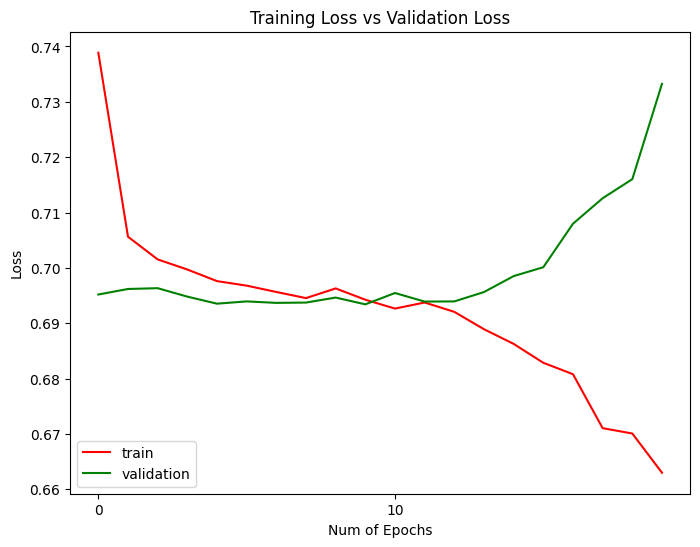

[I 2023-07-08 01:17:14,372] Trial 31 finished with value: 0.6934134364128113 and parameters: {'pT0Ref': 1.6237319101114083, 'ecmPow': 0.15055054467623227, 'coreRadius': 0.7303067605577159, 'coreFraction': 0.4668806717911092}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.375367164249214 0.13775829616905094 0.6421282852359396 0.46985291935561124
Pythia initialized
start
0
nCharged  60
1000
nCharged  72
2000
nCharged  498
3000
nCharged  348
4000
nCharged  2
5000
nCharged  366
6000
nCharged  372
7000
nCharged  404
8000
nCharged  32
9000
nCharged  34
(10001, 400, 3)
Max. nCharged =  708
Data shape:  (10001, 400, 3)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 64)                76864     
                                                                 
 dropout_96 (Dropout)        (None, 64)                0         
                                                                 
 dense_129 (Dense)           (None, 64)                4160      
                                                                 
 dropout_97 (Dropout)        (None, 64)                0         
            

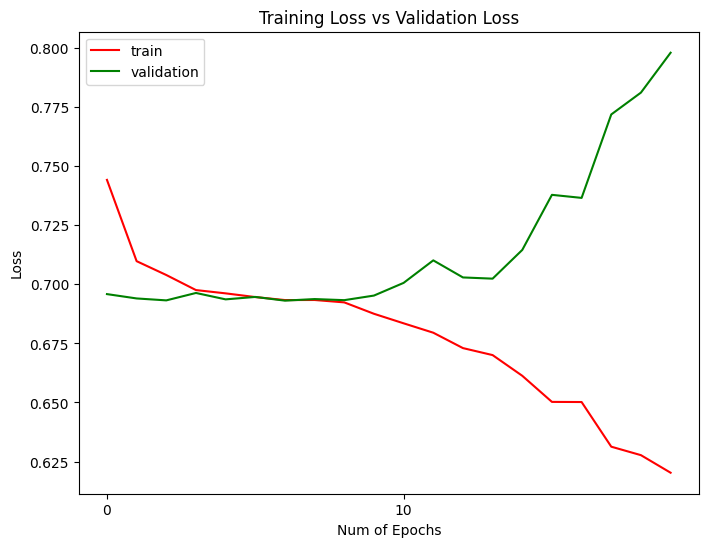

[I 2023-07-08 01:20:43,188] Trial 32 finished with value: 0.6930792331695557 and parameters: {'pT0Ref': 1.375367164249214, 'ecmPow': 0.13775829616905094, 'coreRadius': 0.6421282852359396, 'coreFraction': 0.46985291935561124}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.1235780936049424 0.12261495742484485 0.8131278479668433 0.5501253355941922
Pythia initialized
start
0
nCharged  2
1000
nCharged  556
2000
nCharged  4
3000
nCharged  414
4000
nCharged  156
5000
nCharged  26
6000
nCharged  162
7000
nCharged  52
8000
nCharged  38
9000
nCharged  414
(10001, 400, 3)
Max. nCharged =  802
Data shape:  (10001, 400, 3)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                76864     
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
             

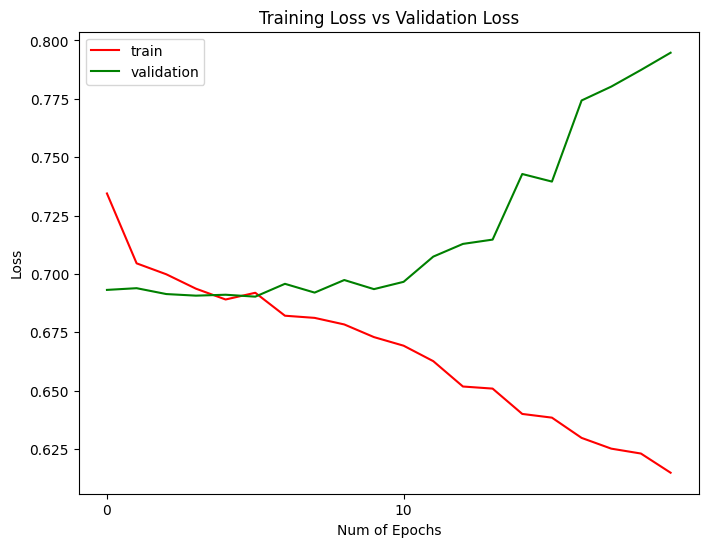

[I 2023-07-08 01:24:46,965] Trial 33 finished with value: 0.6902369856834412 and parameters: {'pT0Ref': 1.1235780936049424, 'ecmPow': 0.12261495742484485, 'coreRadius': 0.8131278479668433, 'coreFraction': 0.5501253355941922}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.7417251319522427 0.14806502431605317 0.532476931443796 0.5084547116741475
Pythia initialized
start
0
nCharged  106
1000
nCharged  2
2000
nCharged  2
3000
nCharged  82
4000
nCharged  186
5000
nCharged  24
6000
nCharged  270
7000
nCharged  124
8000
nCharged  118
9000
nCharged  192
(10001, 400, 3)
Max. nCharged =  582
Data shape:  (10001, 400, 3)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 64)                76864     
                                                                 
 dropout_102 (Dropout)       (None, 64)                0         
                                                                 
 dense_137 (Dense)           (None, 64)                4160      
                                                                 
 dropout_103 (Dropout)       (None, 64)                0         
             

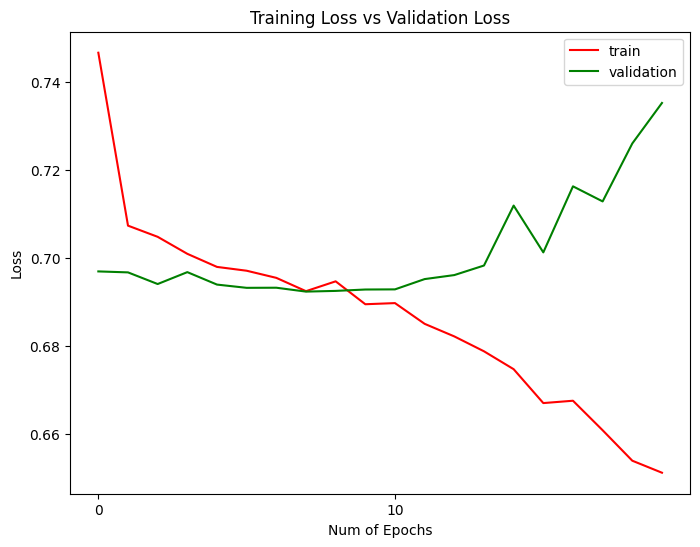

[I 2023-07-08 01:27:56,206] Trial 34 finished with value: 0.6923936605453491 and parameters: {'pT0Ref': 1.7417251319522427, 'ecmPow': 0.14806502431605317, 'coreRadius': 0.532476931443796, 'coreFraction': 0.5084547116741475}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.07953587883781 0.1667084957944852 0.7075769918810987 0.4735224226050745
Pythia initialized
start
0
nCharged  54
1000
nCharged  26
2000
nCharged  50
3000
nCharged  4
4000
nCharged  4
5000
nCharged  94
6000
nCharged  2
7000
nCharged  2
8000
nCharged  94
9000
nCharged  52
(10001, 400, 3)
Max. nCharged =  502
Data shape:  (10001, 400, 3)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                76864     
                                                                 
 dropout_105 (Dropout)       (None, 64)                0         
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dropout_106 (Dropout)       (None, 64)                0         
                       

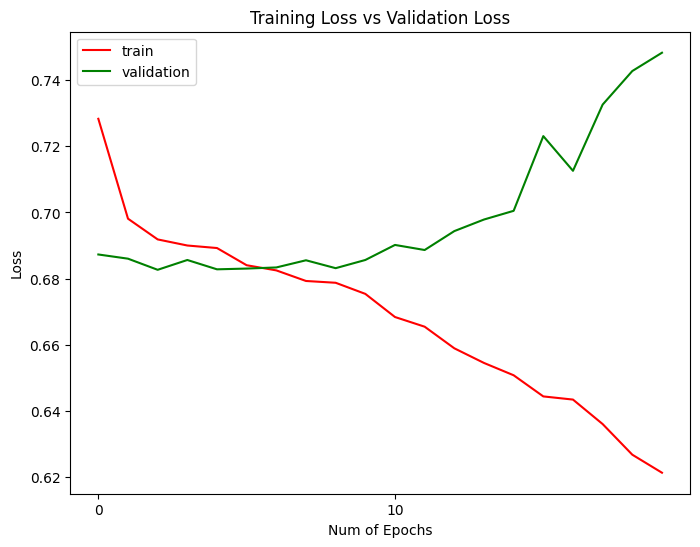

[I 2023-07-08 01:30:53,798] Trial 35 finished with value: 0.682649552822113 and parameters: {'pT0Ref': 2.07953587883781, 'ecmPow': 0.1667084957944852, 'coreRadius': 0.7075769918810987, 'coreFraction': 0.4735224226050745}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.4450601407636574 0.11748987998768666 0.7592261462507012 0.6012443474109901
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  2
3000
nCharged  38
4000
nCharged  22
5000
nCharged  352
6000
nCharged  2
7000
nCharged  86
8000
nCharged  14
9000
nCharged  28
(10001, 400, 3)
Max. nCharged =  462
Data shape:  (10001, 400, 3)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                76864     
                                                                 
 dropout_108 (Dropout)       (None, 64)                0         
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dropout_109 (Dropout)       (None, 64)                0         
                   

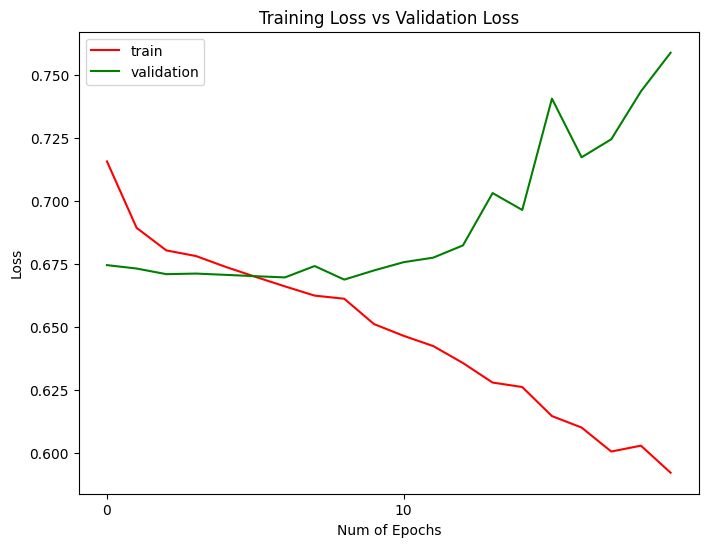

[I 2023-07-08 01:34:00,787] Trial 36 finished with value: 0.6687460541725159 and parameters: {'pT0Ref': 2.4450601407636574, 'ecmPow': 0.11748987998768666, 'coreRadius': 0.7592261462507012, 'coreFraction': 0.6012443474109901}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.0393937908662085 0.14293393669832877 0.5072106175425677 0.43073998781649303
Pythia initialized
start
0
nCharged  26
1000
nCharged  226
2000
nCharged  36
3000
nCharged  106
4000
nCharged  48
5000
nCharged  334
6000
nCharged  142
7000
nCharged  76
8000
nCharged  270
9000
nCharged  102
(10001, 400, 3)
Max. nCharged =  512
Data shape:  (10001, 400, 3)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 64)                76864     
                                                                 
 dropout_111 (Dropout)       (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 64)                4160      
                                                                 
 dropout_112 (Dropout)       (None, 64)                0         
         

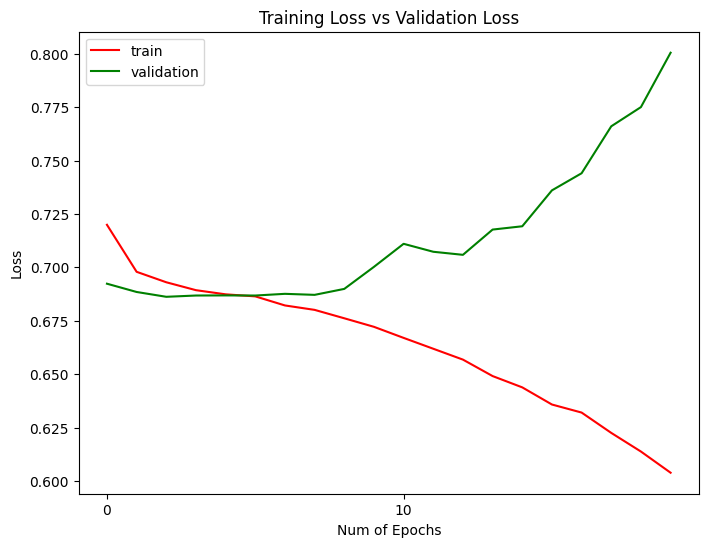

[I 2023-07-08 01:37:06,116] Trial 37 finished with value: 0.6861941814422607 and parameters: {'pT0Ref': 2.0393937908662085, 'ecmPow': 0.14293393669832877, 'coreRadius': 0.5072106175425677, 'coreFraction': 0.43073998781649303}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  2.324451870034578 0.19162869383206046 0.6321104239726181 0.3604377730760152
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  2
3000
nCharged  12
4000
nCharged  244
5000
nCharged  84
6000
nCharged  104
7000
nCharged  46
8000
nCharged  2
9000
nCharged  50
(10001, 400, 3)
Max. nCharged =  428
Data shape:  (10001, 400, 3)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 64)                76864     
                                                                 
 dropout_114 (Dropout)       (None, 64)                0         
                                                                 
 dense_153 (Dense)           (None, 64)                4160      
                                                                 
 dropout_115 (Dropout)       (None, 64)                0         
                   

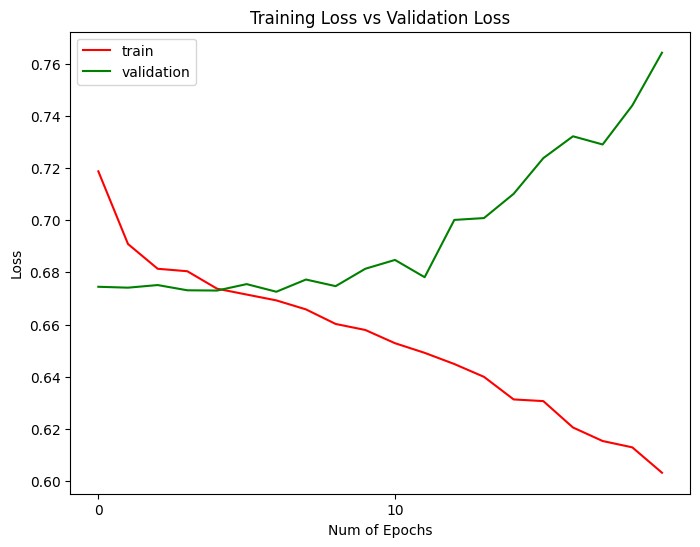

[I 2023-07-08 01:40:00,086] Trial 38 finished with value: 0.6725737452507019 and parameters: {'pT0Ref': 2.324451870034578, 'ecmPow': 0.19162869383206046, 'coreRadius': 0.6321104239726181, 'coreFraction': 0.3604377730760152}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.7105064418624212 0.22955636776017369 0.41154599492708305 0.5317820299843437
Pythia initialized
start
0
nCharged  2
1000
nCharged  4
2000
nCharged  58
3000
nCharged  92
4000
nCharged  78
5000
nCharged  126
6000
nCharged  46
7000
nCharged  12
8000
nCharged  48
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  584
Data shape:  (10001, 400, 3)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 64)                76864     
                                                                 
 dropout_117 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 64)                4160      
                                                                 
 dropout_118 (Dropout)       (None, 64)                0         
                 

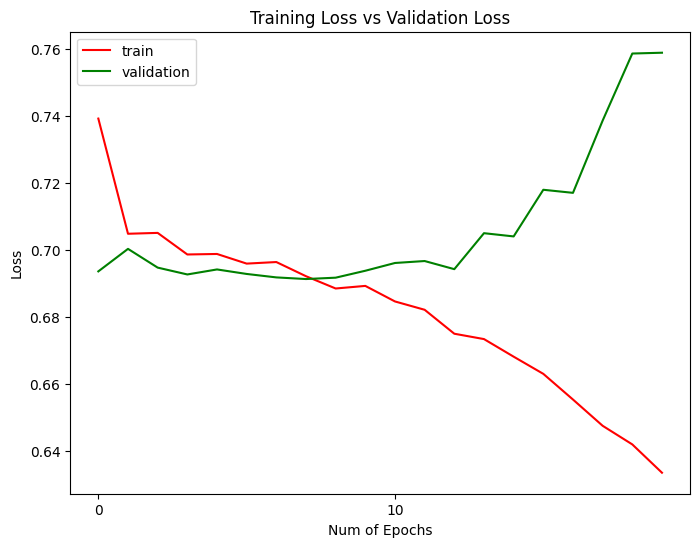

[I 2023-07-08 01:43:02,975] Trial 39 finished with value: 0.6913413405418396 and parameters: {'pT0Ref': 1.7105064418624212, 'ecmPow': 0.22955636776017369, 'coreRadius': 0.41154599492708305, 'coreFraction': 0.5317820299843437}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.4454279593755073 0.09232111053661456 0.6784153257668482 0.24486246782417168
Pythia initialized
start
0
nCharged  176
1000
nCharged  8
2000
nCharged  334
3000
nCharged  54
4000
nCharged  114
5000
nCharged  76
6000
nCharged  36
7000
nCharged  32
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  696
Data shape:  (10001, 400, 3)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 64)                76864     
                                                                 
 dropout_120 (Dropout)       (None, 64)                0         
                                                                 
 dense_161 (Dense)           (None, 64)                4160      
                                                                 
 dropout_121 (Dropout)       (None, 64)                0         
               

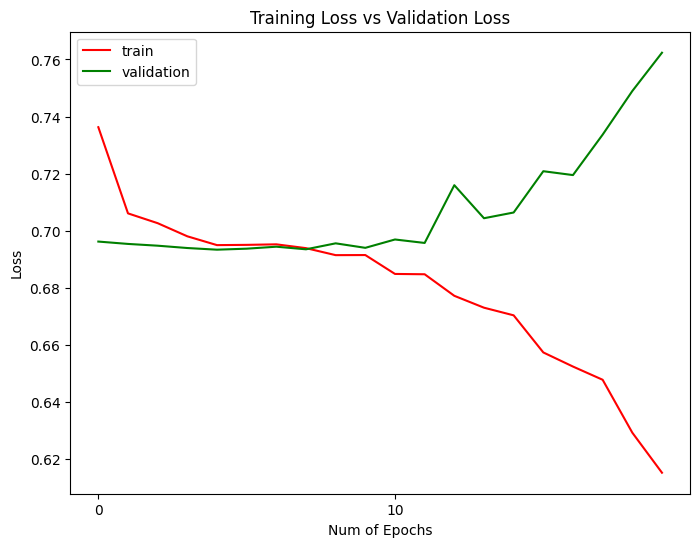

[I 2023-07-08 01:46:35,389] Trial 40 finished with value: 0.6933751702308655 and parameters: {'pT0Ref': 1.4454279593755073, 'ecmPow': 0.09232111053661456, 'coreRadius': 0.6784153257668482, 'coreFraction': 0.24486246782417168}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.3821739460122378 0.08519826591413729 0.695209090520895 0.2701988212995915
Pythia initialized
start
0
nCharged  2
1000
nCharged  132
2000
nCharged  94
3000
nCharged  246
4000
nCharged  30
5000
nCharged  50
6000
nCharged  60
7000
nCharged  6
8000
nCharged  470
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  766
Data shape:  (10001, 400, 3)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 64)                76864     
                                                                 
 dropout_123 (Dropout)       (None, 64)                0         
                                                                 
 dense_165 (Dense)           (None, 64)                4160      
                                                                 
 dropout_124 (Dropout)       (None, 64)                0         
                 

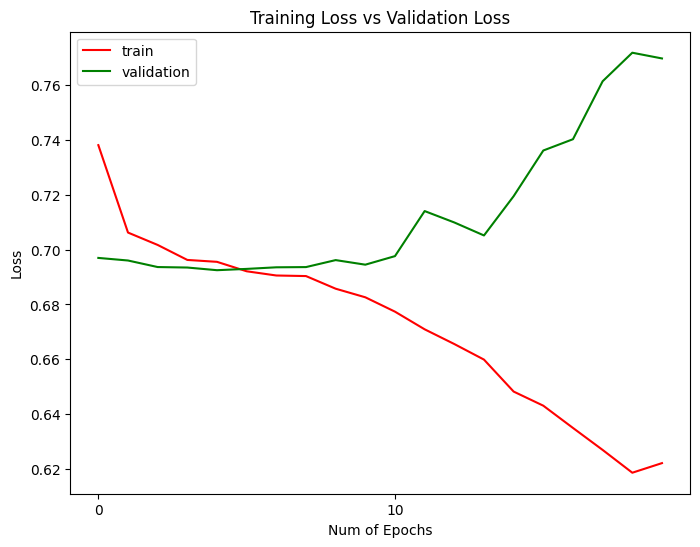

[I 2023-07-08 01:50:15,117] Trial 41 finished with value: 0.6924953460693359 and parameters: {'pT0Ref': 1.3821739460122378, 'ecmPow': 0.08519826591413729, 'coreRadius': 0.695209090520895, 'coreFraction': 0.2701988212995915}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.954643076471232 0.11266886400633157 0.6533848569894803 0.3419080113180681
Pythia initialized
start
0
nCharged  32
1000
nCharged  70
2000
nCharged  2
3000
nCharged  70
4000
nCharged  2
5000
nCharged  146
6000
nCharged  150
7000
nCharged  66
8000
nCharged  254
9000
nCharged  212
(10001, 400, 3)
Max. nCharged =  560
Data shape:  (10001, 400, 3)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                76864     
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 64)                4160      
                                                                 
 dropout_127 (Dropout)       (None, 64)                0         
               

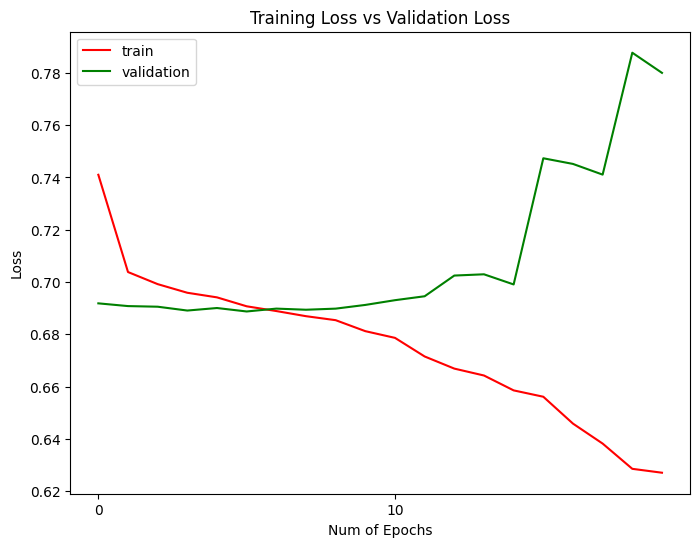

[I 2023-07-08 01:53:26,561] Trial 42 finished with value: 0.6887244582176208 and parameters: {'pT0Ref': 1.954643076471232, 'ecmPow': 0.11266886400633157, 'coreRadius': 0.6533848569894803, 'coreFraction': 0.3419080113180681}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.4872067544554506 0.09070351495567751 0.7780441254059085 0.1894935727664426
Pythia initialized
start
0
nCharged  210
1000
nCharged  42
2000
nCharged  152
3000
nCharged  48
4000
nCharged  64
5000
nCharged  282
6000
nCharged  94
7000
nCharged  198
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  668
Data shape:  (10001, 400, 3)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 64)                76864     
                                                                 
 dropout_129 (Dropout)       (None, 64)                0         
                                                                 
 dense_173 (Dense)           (None, 64)                4160      
                                                                 
 dropout_130 (Dropout)       (None, 64)                0         
              

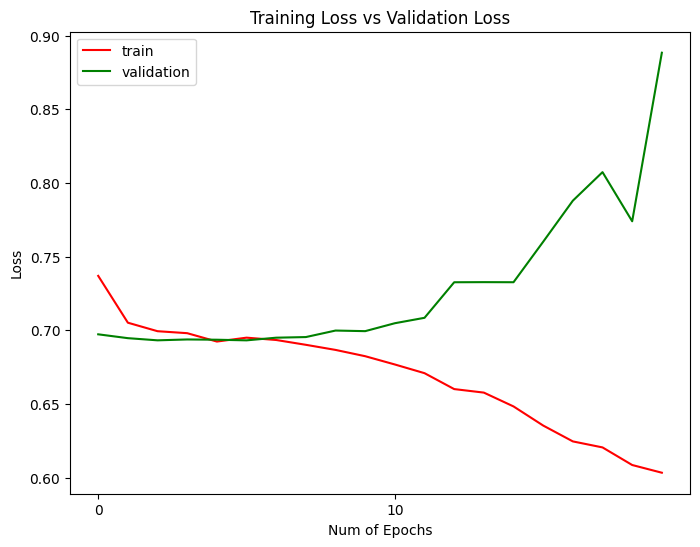

[I 2023-07-08 01:56:57,682] Trial 43 finished with value: 0.6931792497634888 and parameters: {'pT0Ref': 1.4872067544554506, 'ecmPow': 0.09070351495567751, 'coreRadius': 0.7780441254059085, 'coreFraction': 0.1894935727664426}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.1319243420853968 0.13280714615378025 0.5881641039487308 0.44983108591290966
Pythia initialized
start
0
nCharged  574
1000
nCharged  36
2000
nCharged  32
3000
nCharged  2
4000
nCharged  54
5000
nCharged  12
6000
nCharged  60
7000
nCharged  2
8000
nCharged  48
9000
nCharged  40
(10001, 400, 3)
Max. nCharged =  720
Data shape:  (10001, 400, 3)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 64)                76864     
                                                                 
 dropout_132 (Dropout)       (None, 64)                0         
                                                                 
 dense_177 (Dense)           (None, 64)                4160      
                                                                 
 dropout_133 (Dropout)       (None, 64)                0         
                

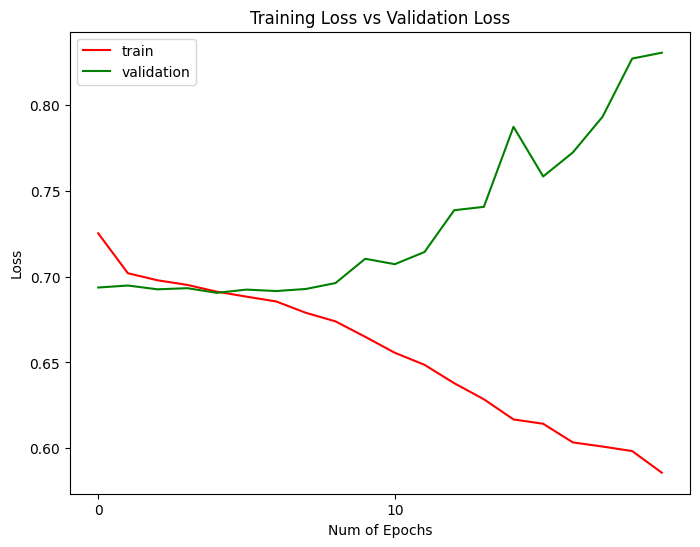

[I 2023-07-08 02:00:51,566] Trial 44 finished with value: 0.6905482411384583 and parameters: {'pT0Ref': 1.1319243420853968, 'ecmPow': 0.13280714615378025, 'coreRadius': 0.5881641039487308, 'coreFraction': 0.44983108591290966}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.744767332364156 0.04689065226562765 0.5131855199731755 0.21316170281144112
Pythia initialized
start
0
nCharged  2
1000
nCharged  162
2000
nCharged  54
3000
nCharged  78
4000
nCharged  144
5000
nCharged  34
6000
nCharged  466
7000
nCharged  66
8000
nCharged  2
9000
nCharged  80
(10001, 400, 3)
Max. nCharged =  630
Data shape:  (10001, 400, 3)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 64)                76864     
                                                                 
 dropout_135 (Dropout)       (None, 64)                0         
                                                                 
 dense_181 (Dense)           (None, 64)                4160      
                                                                 
 dropout_136 (Dropout)       (None, 64)                0         
               

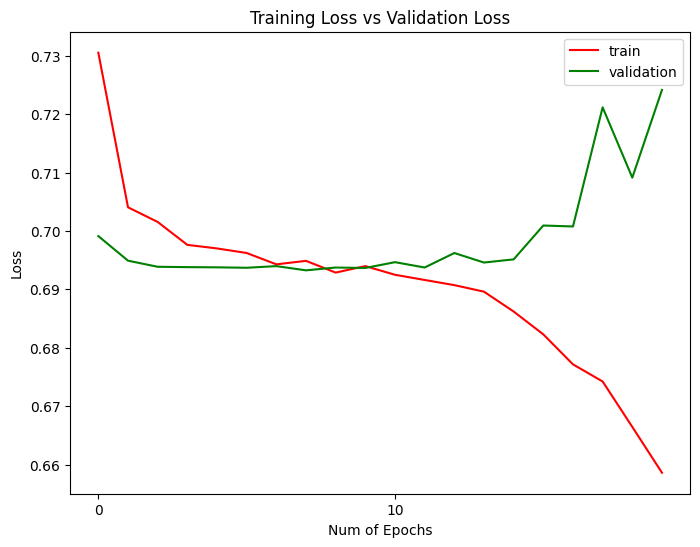

[I 2023-07-08 02:04:20,135] Trial 45 finished with value: 0.6932585835456848 and parameters: {'pT0Ref': 1.744767332364156, 'ecmPow': 0.04689065226562765, 'coreRadius': 0.5131855199731755, 'coreFraction': 0.21316170281144112}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.2329608729113082 0.10820500093051597 0.6861404388070088 0.544421598257748
Pythia initialized
start
0
nCharged  2
1000
nCharged  98
2000
nCharged  134
3000
nCharged  52
4000
nCharged  2
5000
nCharged  148
6000
nCharged  124
7000
nCharged  130
8000
nCharged  78
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  710
Data shape:  (10001, 400, 3)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 64)                76864     
                                                                 
 dropout_138 (Dropout)       (None, 64)                0         
                                                                 
 dense_185 (Dense)           (None, 64)                4160      
                                                                 
 dropout_139 (Dropout)       (None, 64)                0         
                

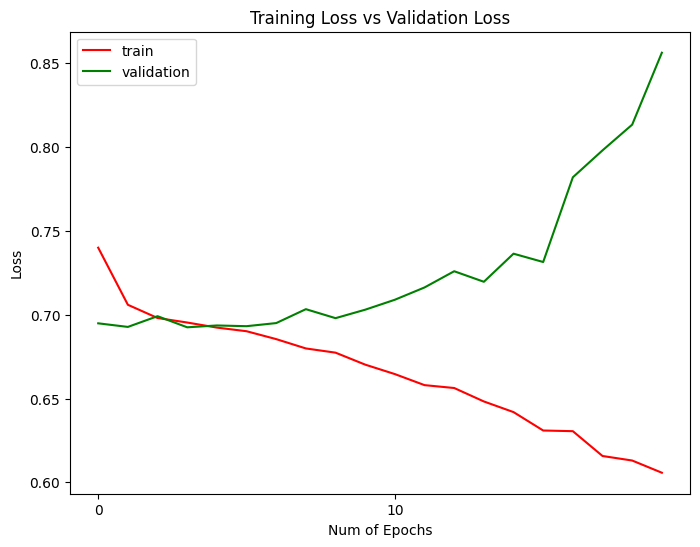

[I 2023-07-08 02:08:05,067] Trial 46 finished with value: 0.6924366354942322 and parameters: {'pT0Ref': 1.2329608729113082, 'ecmPow': 0.10820500093051597, 'coreRadius': 0.6861404388070088, 'coreFraction': 0.544421598257748}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  0.9503960874670228 0.07393962324660275 0.7161630637147235 0.2981391176337346
Pythia initialized
start
0
nCharged  178
1000
nCharged  2
2000
nCharged  74
3000
nCharged  2
4000
nCharged  72
5000
nCharged  434
6000
nCharged  8
7000
nCharged  36
8000
nCharged  2
9000
nCharged  554
(10001, 400, 3)
Max. nCharged =  834
Data shape:  (10001, 400, 3)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 64)                76864     
                                                                 
 dropout_141 (Dropout)       (None, 64)                0         
                                                                 
 dense_189 (Dense)           (None, 64)                4160      
                                                                 
 dropout_142 (Dropout)       (None, 64)                0         
                 

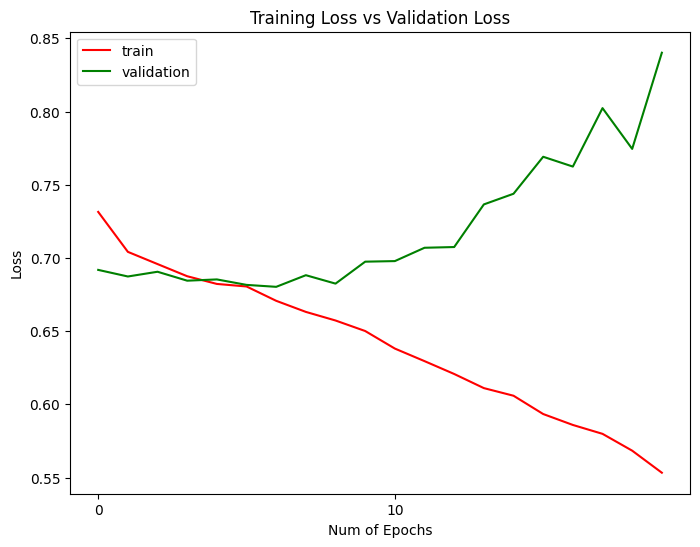

[I 2023-07-08 02:14:17,838] Trial 47 finished with value: 0.680277407169342 and parameters: {'pT0Ref': 0.9503960874670228, 'ecmPow': 0.07393962324660275, 'coreRadius': 0.7161630637147235, 'coreFraction': 0.2981391176337346}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.476721112337432 0.1539639817402405 0.6163935017963116 0.15575278344959148
Pythia initialized
start
0
nCharged  50
1000
nCharged  248
2000
nCharged  34
3000
nCharged  2
4000
nCharged  50
5000
nCharged  338
6000
nCharged  8
7000
nCharged  46
8000
nCharged  48
9000
nCharged  82
(10001, 400, 3)
Max. nCharged =  644
Data shape:  (10001, 400, 3)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 64)                76864     
                                                                 
 dropout_144 (Dropout)       (None, 64)                0         
                                                                 
 dense_193 (Dense)           (None, 64)                4160      
                                                                 
 dropout_145 (Dropout)       (None, 64)                0         
                 

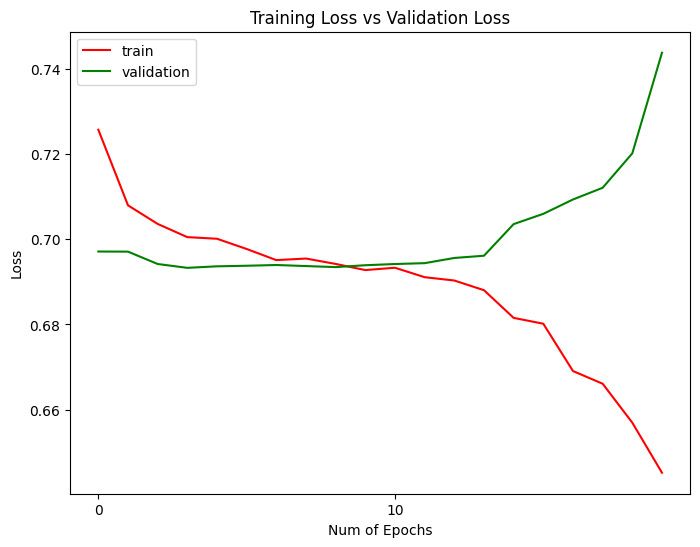

[I 2023-07-08 02:17:36,799] Trial 48 finished with value: 0.6933003067970276 and parameters: {'pT0Ref': 1.476721112337432, 'ecmPow': 0.1539639817402405, 'coreRadius': 0.6163935017963116, 'coreFraction': 0.15575278344959148}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.6745699274678956 0.08643025654746271 0.8018301881002883 0.2686583115094417
Pythia initialized
start
0
nCharged  242
1000
nCharged  4
2000
nCharged  32
3000
nCharged  40
4000
nCharged  6
5000
nCharged  350
6000
nCharged  12
7000
nCharged  2
8000
nCharged  52
9000
nCharged  364
(10001, 400, 3)
Max. nCharged =  696
Data shape:  (10001, 400, 3)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 64)                76864     
                                                                 
 dropout_147 (Dropout)       (None, 64)                0         
                                                                 
 dense_197 (Dense)           (None, 64)                4160      
                                                                 
 dropout_148 (Dropout)       (None, 64)                0         
                

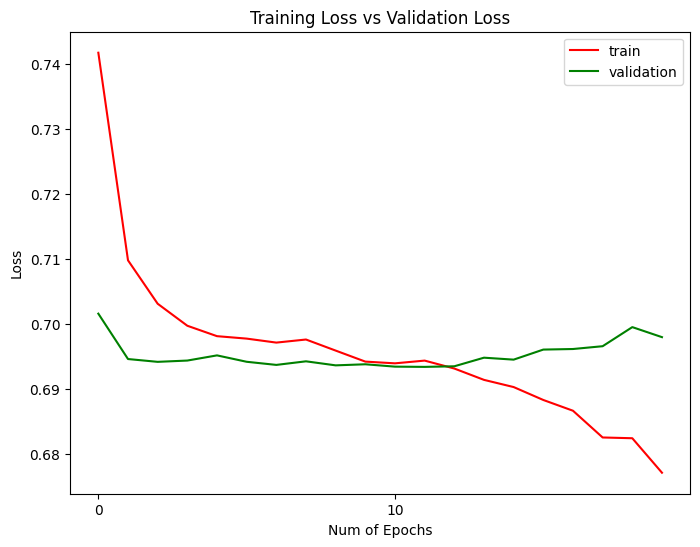

[I 2023-07-08 02:21:03,581] Trial 49 finished with value: 0.6933828592300415 and parameters: {'pT0Ref': 1.6745699274678956, 'ecmPow': 0.08643025654746271, 'coreRadius': 0.8018301881002883, 'coreFraction': 0.2686583115094417}. Best is trial 24 with value: 0.6935969591140747.


Optuna suggested x =  1.692979892226019 0.04278479195806492 0.8534205320722125 0.48213514592223145
Pythia initialized
start
0
nCharged  120
1000
nCharged  330
2000
nCharged  62
3000
nCharged  4
4000
nCharged  70
5000
nCharged  50
6000
nCharged  2
7000
nCharged  2
8000
nCharged  20
9000
nCharged  142
(10001, 400, 3)
Max. nCharged =  666
Data shape:  (10001, 400, 3)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 64)                76864     
                                                                 
 dropout_150 (Dropout)       (None, 64)                0         
                                                                 
 dense_201 (Dense)           (None, 64)                4160      
                                                                 
 dropout_151 (Dropout)       (None, 64)                0         
                

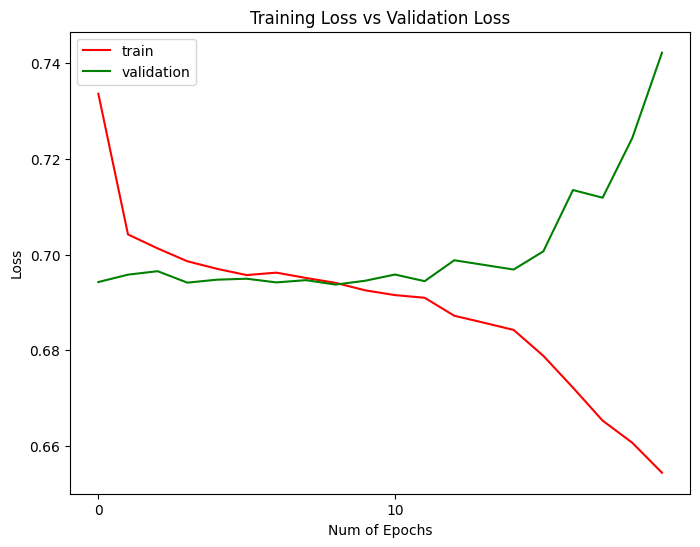

[I 2023-07-08 02:24:37,839] Trial 50 finished with value: 0.6937376260757446 and parameters: {'pT0Ref': 1.692979892226019, 'ecmPow': 0.04278479195806492, 'coreRadius': 0.8534205320722125, 'coreFraction': 0.48213514592223145}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.9778948359985353 0.04421903804760802 0.8281153008375876 0.4936736032484871
Pythia initialized
start
0
nCharged  20
1000
nCharged  70
2000
nCharged  60
3000
nCharged  222
4000
nCharged  326
5000
nCharged  104
6000
nCharged  60
7000
nCharged  124
8000
nCharged  22
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  554
Data shape:  (10001, 400, 3)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 64)                76864     
                                                                 
 dropout_153 (Dropout)       (None, 64)                0         
                                                                 
 dense_205 (Dense)           (None, 64)                4160      
                                                                 
 dropout_154 (Dropout)       (None, 64)                0         
            

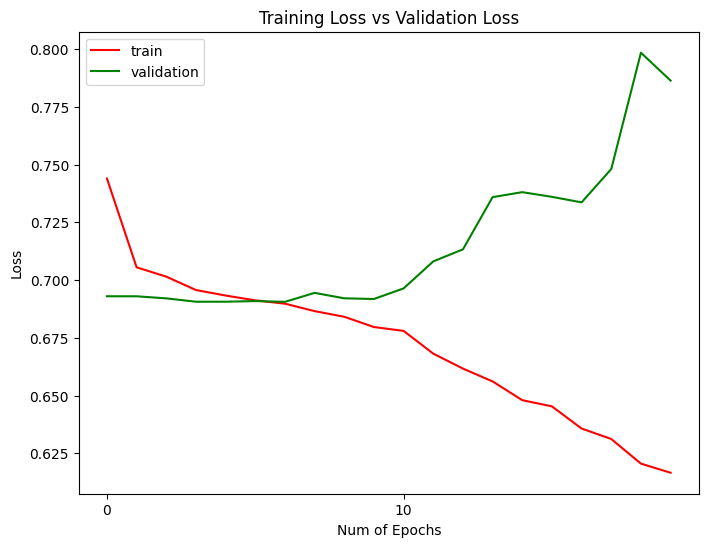

[I 2023-07-08 02:28:03,646] Trial 51 finished with value: 0.6905786991119385 and parameters: {'pT0Ref': 1.9778948359985353, 'ecmPow': 0.04421903804760802, 'coreRadius': 0.8281153008375876, 'coreFraction': 0.4936736032484871}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.727623171460476 0.0735925790953444 0.8684853294911493 0.41312153500971527
Pythia initialized
start
0
nCharged  26
1000
nCharged  12
2000
nCharged  12
3000
nCharged  218
4000
nCharged  120
5000
nCharged  70
6000
nCharged  24
7000
nCharged  114
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  604
Data shape:  (10001, 400, 3)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 64)                76864     
                                                                 
 dropout_156 (Dropout)       (None, 64)                0         
                                                                 
 dense_209 (Dense)           (None, 64)                4160      
                                                                 
 dropout_157 (Dropout)       (None, 64)                0         
                

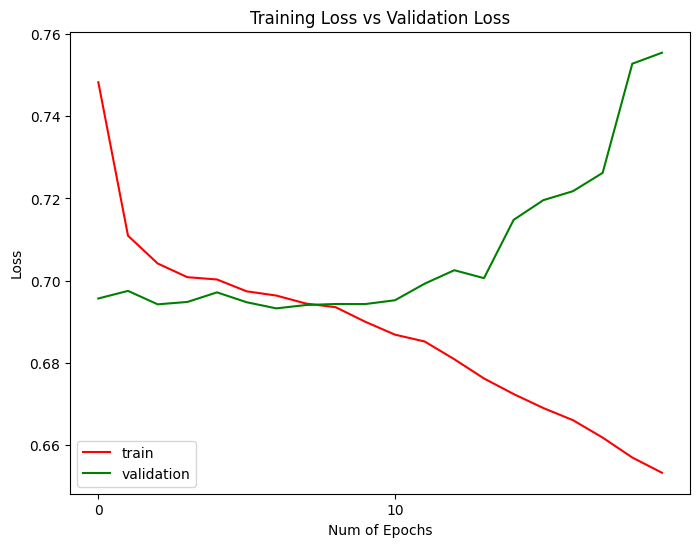

[I 2023-07-08 02:31:27,573] Trial 52 finished with value: 0.6932361721992493 and parameters: {'pT0Ref': 1.727623171460476, 'ecmPow': 0.0735925790953444, 'coreRadius': 0.8684853294911493, 'coreFraction': 0.41312153500971527}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8590572517969248 0.033022376501082945 0.7974352209379229 0.4427559774389347
Pythia initialized
start
0
nCharged  32
1000
nCharged  52
2000
nCharged  48
3000
nCharged  2
4000
nCharged  72
5000
nCharged  320
6000
nCharged  192
7000
nCharged  44
8000
nCharged  398
9000
nCharged  12
(10001, 400, 3)
Max. nCharged =  626
Data shape:  (10001, 400, 3)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 64)                76864     
                                                                 
 dropout_159 (Dropout)       (None, 64)                0         
                                                                 
 dense_213 (Dense)           (None, 64)                4160      
                                                                 
 dropout_160 (Dropout)       (None, 64)                0         
             

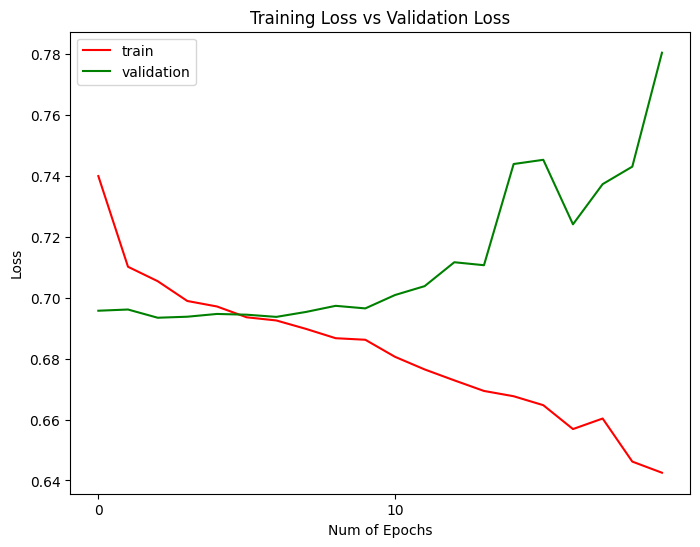

[I 2023-07-08 02:34:32,728] Trial 53 finished with value: 0.6934258341789246 and parameters: {'pT0Ref': 1.8590572517969248, 'ecmPow': 0.033022376501082945, 'coreRadius': 0.7974352209379229, 'coreFraction': 0.4427559774389347}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8565183141560742 0.03483678710385475 0.7624756398322665 0.47684056801987945
Pythia initialized
start
0
nCharged  294
1000
nCharged  48
2000
nCharged  60
3000
nCharged  94
4000
nCharged  14
5000
nCharged  56
6000
nCharged  362
7000
nCharged  2
8000
nCharged  90
9000
nCharged  28
(10001, 400, 3)
Max. nCharged =  588
Data shape:  (10001, 400, 3)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 64)                76864     
                                                                 
 dropout_162 (Dropout)       (None, 64)                0         
                                                                 
 dense_217 (Dense)           (None, 64)                4160      
                                                                 
 dropout_163 (Dropout)       (None, 64)                0         
              

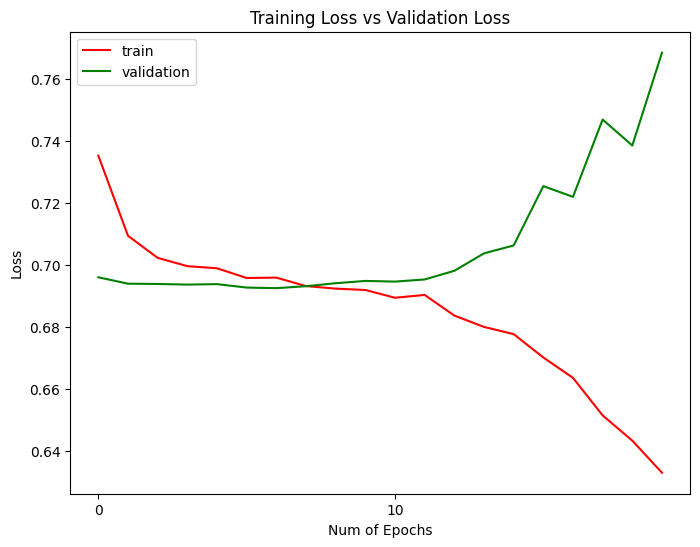

[I 2023-07-08 02:37:35,952] Trial 54 finished with value: 0.6925128102302551 and parameters: {'pT0Ref': 1.8565183141560742, 'ecmPow': 0.03483678710385475, 'coreRadius': 0.7624756398322665, 'coreFraction': 0.47684056801987945}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.9759696011990866 0.059003767393654545 0.861590269026528 0.4556022948492017
Pythia initialized
start
0
nCharged  2
1000
nCharged  138
2000
nCharged  2
3000
nCharged  60
4000
nCharged  60
5000
nCharged  326
6000
nCharged  2
7000
nCharged  228
8000
nCharged  218
9000
nCharged  94
(10001, 400, 3)
Max. nCharged =  544
Data shape:  (10001, 400, 3)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 64)                76864     
                                                                 
 dropout_165 (Dropout)       (None, 64)                0         
                                                                 
 dense_221 (Dense)           (None, 64)                4160      
                                                                 
 dropout_166 (Dropout)       (None, 64)                0         
               

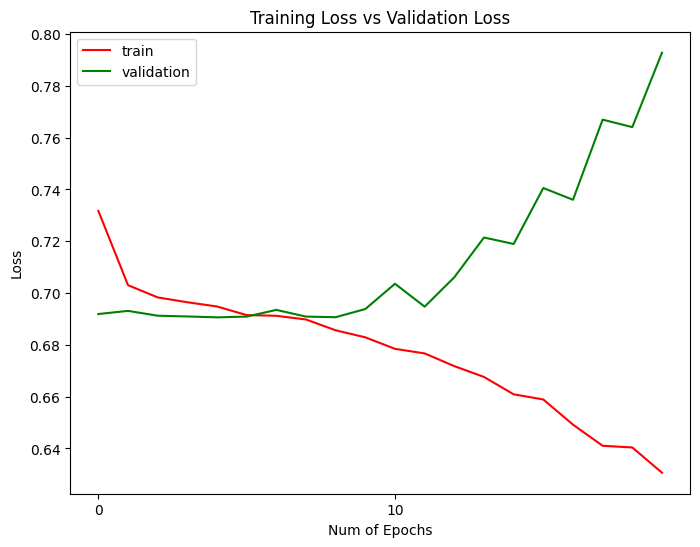

[I 2023-07-08 02:40:32,338] Trial 55 finished with value: 0.6906163096427917 and parameters: {'pT0Ref': 1.9759696011990866, 'ecmPow': 0.059003767393654545, 'coreRadius': 0.861590269026528, 'coreFraction': 0.4556022948492017}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  2.198066867205351 0.03319016643317691 0.7365371755199588 0.5164204453753267
Pythia initialized
start
0
nCharged  46
1000
nCharged  2
2000
nCharged  2
3000
nCharged  2
4000
nCharged  66
5000
nCharged  50
6000
nCharged  320
7000
nCharged  28
8000
nCharged  104
9000
nCharged  52
(10001, 400, 3)
Max. nCharged =  486
Data shape:  (10001, 400, 3)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 64)                76864     
                                                                 
 dropout_168 (Dropout)       (None, 64)                0         
                                                                 
 dense_225 (Dense)           (None, 64)                4160      
                                                                 
 dropout_169 (Dropout)       (None, 64)                0         
                  

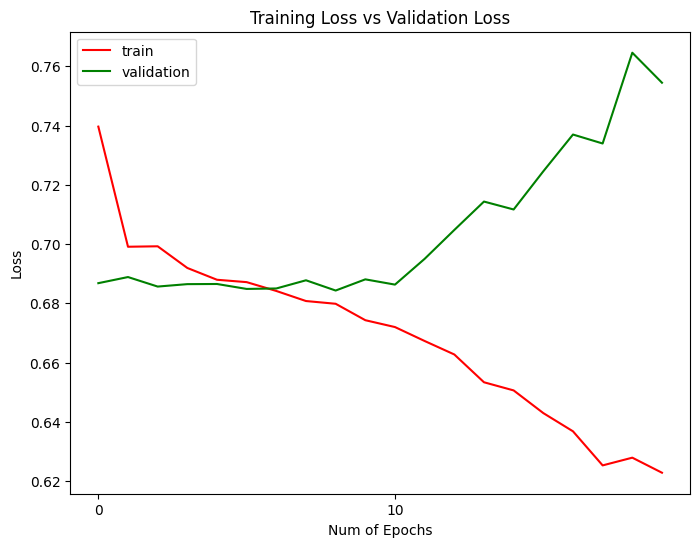

[I 2023-07-08 02:43:31,392] Trial 56 finished with value: 0.6843144297599792 and parameters: {'pT0Ref': 2.198066867205351, 'ecmPow': 0.03319016643317691, 'coreRadius': 0.7365371755199588, 'coreFraction': 0.5164204453753267}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.6330699175229075 0.01782881617549549 0.9016457276035934 0.5617211381790755
Pythia initialized
start
0
nCharged  2
1000
nCharged  100
2000
nCharged  104
3000
nCharged  32
4000
nCharged  4
5000
nCharged  32
6000
nCharged  204
7000
nCharged  6
8000
nCharged  2
9000
nCharged  76
(10001, 400, 3)
Max. nCharged =  660
Data shape:  (10001, 400, 3)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 64)                76864     
                                                                 
 dropout_171 (Dropout)       (None, 64)                0         
                                                                 
 dense_229 (Dense)           (None, 64)                4160      
                                                                 
 dropout_172 (Dropout)       (None, 64)                0         
                 

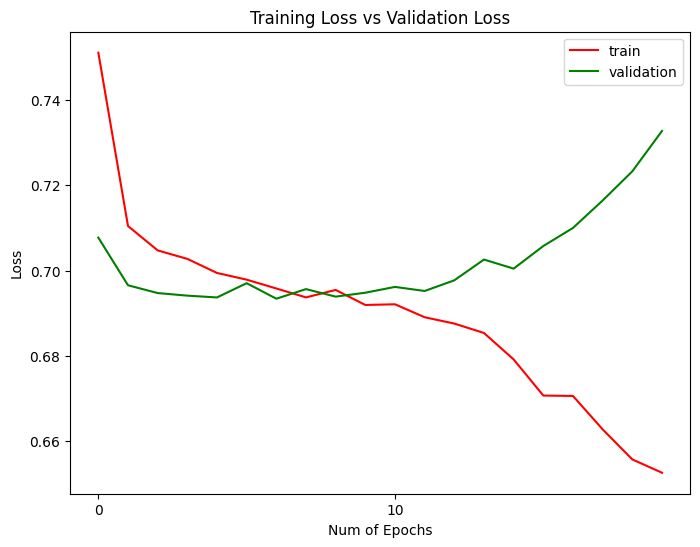

[I 2023-07-08 02:46:45,856] Trial 57 finished with value: 0.6933944225311279 and parameters: {'pT0Ref': 1.6330699175229075, 'ecmPow': 0.01782881617549549, 'coreRadius': 0.9016457276035934, 'coreFraction': 0.5617211381790755}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8790103501659112 0.056764006649738886 0.8123646272880365 0.4206266245007552
Pythia initialized
start
0
nCharged  2
1000
nCharged  50
2000
nCharged  42
3000
nCharged  158
4000
nCharged  2
5000
nCharged  36
6000
nCharged  86
7000
nCharged  164
8000
nCharged  2
9000
nCharged  108
(10001, 400, 3)
Max. nCharged =  644
Data shape:  (10001, 400, 3)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_232 (Dense)           (None, 64)                76864     
                                                                 
 dropout_174 (Dropout)       (None, 64)                0         
                                                                 
 dense_233 (Dense)           (None, 64)                4160      
                                                                 
 dropout_175 (Dropout)       (None, 64)                0         
               

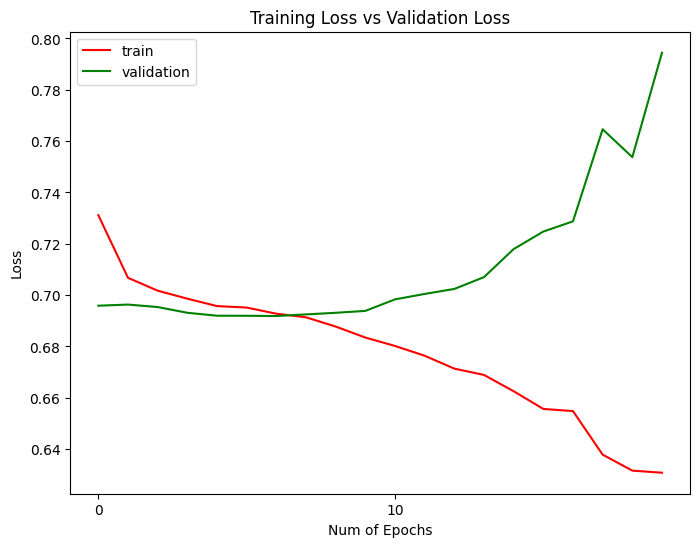

[I 2023-07-08 02:49:44,159] Trial 58 finished with value: 0.6918688416481018 and parameters: {'pT0Ref': 1.8790103501659112, 'ecmPow': 0.056764006649738886, 'coreRadius': 0.8123646272880365, 'coreFraction': 0.4206266245007552}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.7917524311617943 0.038075314225602 0.7978996195558167 0.38412076853306243
Pythia initialized
start
0
nCharged  164
1000
nCharged  230
2000
nCharged  30
3000
nCharged  226
4000
nCharged  334
5000
nCharged  158
6000
nCharged  102
7000
nCharged  456
8000
nCharged  92
9000
nCharged  336
(10001, 400, 3)
Max. nCharged =  588
Data shape:  (10001, 400, 3)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 64)                76864     
                                                                 
 dropout_177 (Dropout)       (None, 64)                0         
                                                                 
 dense_237 (Dense)           (None, 64)                4160      
                                                                 
 dropout_178 (Dropout)       (None, 64)                0         
         

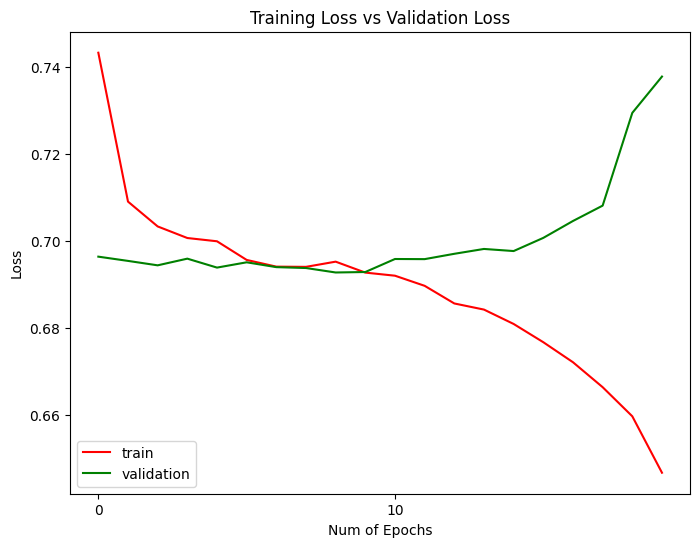

[I 2023-07-08 02:52:47,667] Trial 59 finished with value: 0.6927000880241394 and parameters: {'pT0Ref': 1.7917524311617943, 'ecmPow': 0.038075314225602, 'coreRadius': 0.7978996195558167, 'coreFraction': 0.38412076853306243}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.5273208030576706 0.07102670965690376 0.9204832792483411 0.6292544606871924
Pythia initialized
start
0
nCharged  32
1000
nCharged  2
2000
nCharged  2
3000
nCharged  8
4000
nCharged  172
5000
nCharged  106
6000
nCharged  102
7000
nCharged  176
8000
nCharged  2
9000
nCharged  98
(10001, 400, 3)
Max. nCharged =  732
Data shape:  (10001, 400, 3)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 64)                76864     
                                                                 
 dropout_180 (Dropout)       (None, 64)                0         
                                                                 
 dense_241 (Dense)           (None, 64)                4160      
                                                                 
 dropout_181 (Dropout)       (None, 64)                0         
                

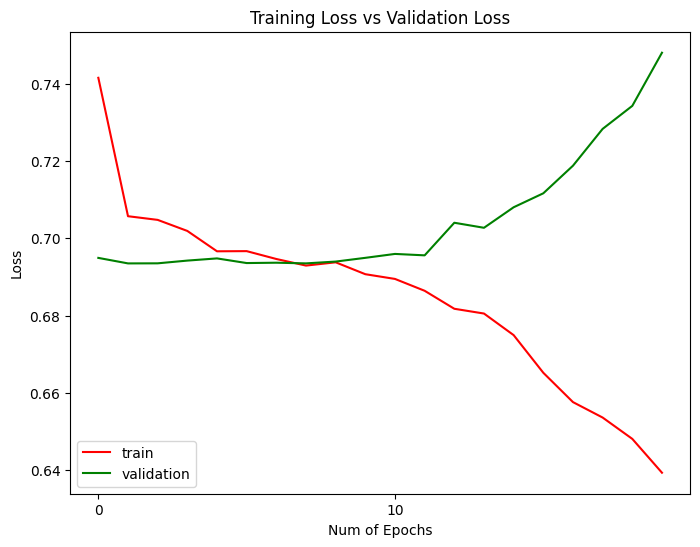

[I 2023-07-08 02:55:52,187] Trial 60 finished with value: 0.6935036182403564 and parameters: {'pT0Ref': 1.5273208030576706, 'ecmPow': 0.07102670965690376, 'coreRadius': 0.9204832792483411, 'coreFraction': 0.6292544606871924}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.5806724669756542 0.06547206098612654 0.9467874410164366 0.6041582554735737
Pythia initialized
start
0
nCharged  22
1000
nCharged  120
2000
nCharged  196
3000
nCharged  26
4000
nCharged  360
5000
nCharged  312
6000
nCharged  312
7000
nCharged  84
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  734
Data shape:  (10001, 400, 3)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 64)                76864     
                                                                 
 dropout_183 (Dropout)       (None, 64)                0         
                                                                 
 dense_245 (Dense)           (None, 64)                4160      
                                                                 
 dropout_184 (Dropout)       (None, 64)                0         
             

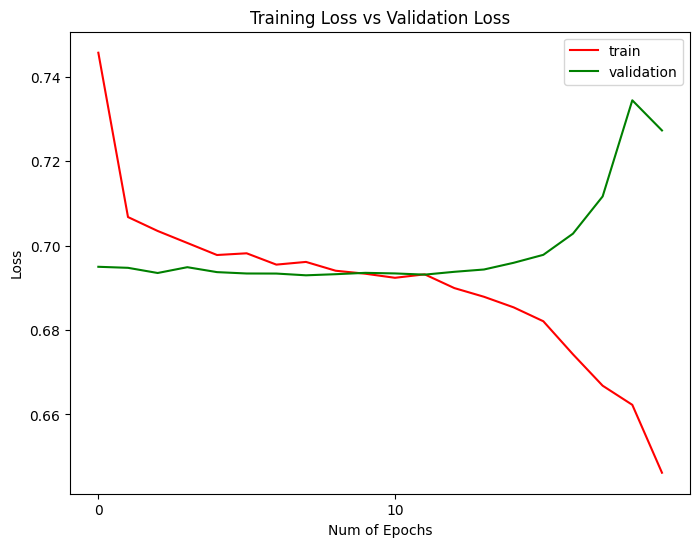

[I 2023-07-08 02:58:58,245] Trial 61 finished with value: 0.6929675936698914 and parameters: {'pT0Ref': 1.5806724669756542, 'ecmPow': 0.06547206098612654, 'coreRadius': 0.9467874410164366, 'coreFraction': 0.6041582554735737}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8224509307179575 0.10237270797842483 0.7761601101982902 0.6311779317629731
Pythia initialized
start
0
nCharged  360
1000
nCharged  2
2000
nCharged  14
3000
nCharged  34
4000
nCharged  2
5000
nCharged  2
6000
nCharged  2
7000
nCharged  370
8000
nCharged  108
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  622
Data shape:  (10001, 400, 3)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_248 (Dense)           (None, 64)                76864     
                                                                 
 dropout_186 (Dropout)       (None, 64)                0         
                                                                 
 dense_249 (Dense)           (None, 64)                4160      
                                                                 
 dropout_187 (Dropout)       (None, 64)                0         
                  

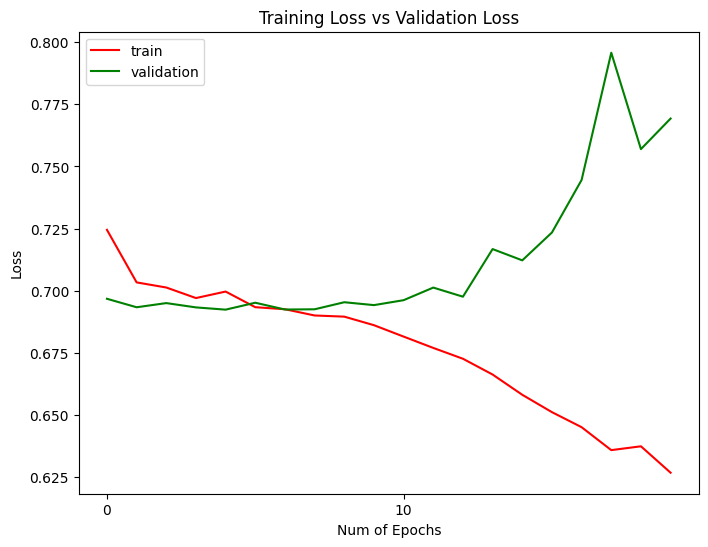

[I 2023-07-08 03:01:47,967] Trial 62 finished with value: 0.6923912167549133 and parameters: {'pT0Ref': 1.8224509307179575, 'ecmPow': 0.10237270797842483, 'coreRadius': 0.7761601101982902, 'coreFraction': 0.6311779317629731}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.501320315618946 0.07828018040956826 0.852216201215144 0.5237098458489091
Pythia initialized
start
0
nCharged  92
1000
nCharged  76
2000
nCharged  90
3000
nCharged  120
4000
nCharged  46
5000
nCharged  456
6000
nCharged  98
7000
nCharged  46
8000
nCharged  314
9000
nCharged  60
(10001, 400, 3)
Max. nCharged =  696
Data shape:  (10001, 400, 3)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 64)                76864     
                                                                 
 dropout_189 (Dropout)       (None, 64)                0         
                                                                 
 dense_253 (Dense)           (None, 64)                4160      
                                                                 
 dropout_190 (Dropout)       (None, 64)                0         
               

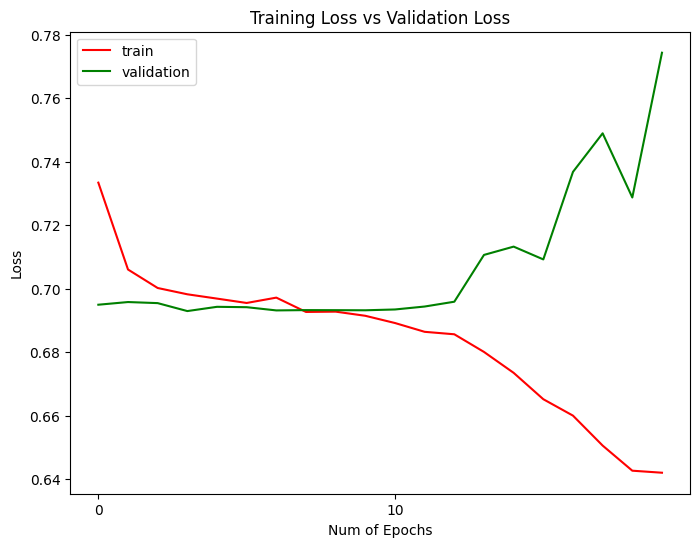

[I 2023-07-08 03:04:52,242] Trial 63 finished with value: 0.692943274974823 and parameters: {'pT0Ref': 1.501320315618946, 'ecmPow': 0.07828018040956826, 'coreRadius': 0.852216201215144, 'coreFraction': 0.5237098458489091}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.2982919101695027 0.013409218659660105 0.8394402840977282 0.5677608938494613
Pythia initialized
start
0
nCharged  20
1000
nCharged  10
2000
nCharged  88
3000
nCharged  164
4000
nCharged  42
5000
nCharged  172
6000
nCharged  2
7000
nCharged  62
8000
nCharged  70
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  742
Data shape:  (10001, 400, 3)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 64)                76864     
                                                                 
 dropout_192 (Dropout)       (None, 64)                0         
                                                                 
 dense_257 (Dense)           (None, 64)                4160      
                                                                 
 dropout_193 (Dropout)       (None, 64)                0         
               

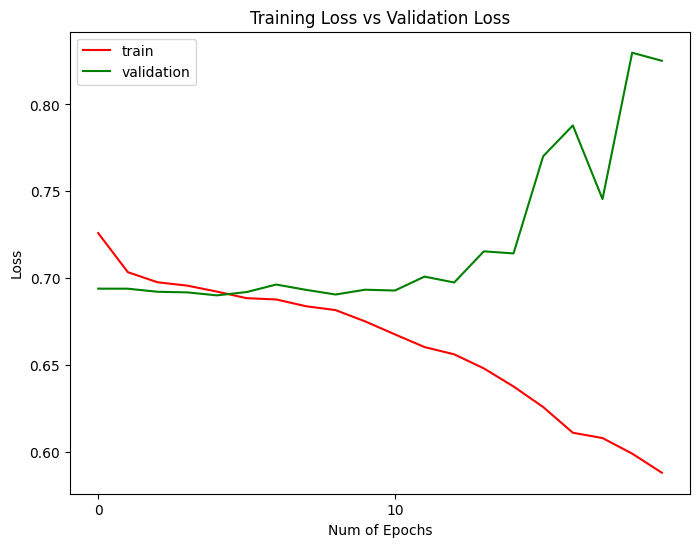

[I 2023-07-08 03:08:25,023] Trial 64 finished with value: 0.6900748610496521 and parameters: {'pT0Ref': 1.2982919101695027, 'ecmPow': 0.013409218659660105, 'coreRadius': 0.8394402840977282, 'coreFraction': 0.5677608938494613}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.6302229122476561 0.048918472157688284 0.9177484553593682 0.4940014672836033
Pythia initialized
start
0
nCharged  58
1000
nCharged  124
2000
nCharged  2
3000
nCharged  152
4000
nCharged  20
5000
nCharged  46
6000
nCharged  2
7000
nCharged  226
8000
nCharged  2
9000
nCharged  460
(10001, 400, 3)
Max. nCharged =  638
Data shape:  (10001, 400, 3)
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 64)                76864     
                                                                 
 dropout_195 (Dropout)       (None, 64)                0         
                                                                 
 dense_261 (Dense)           (None, 64)                4160      
                                                                 
 dropout_196 (Dropout)       (None, 64)                0         
              

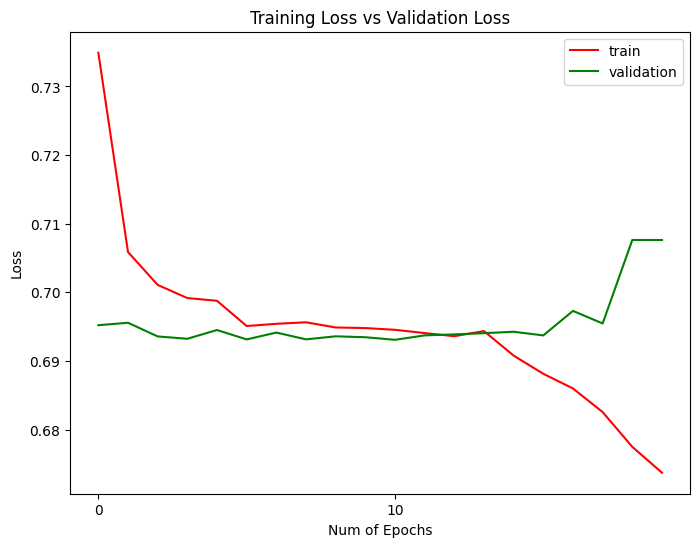

[I 2023-07-08 03:11:31,755] Trial 65 finished with value: 0.6930756568908691 and parameters: {'pT0Ref': 1.6302229122476561, 'ecmPow': 0.048918472157688284, 'coreRadius': 0.9177484553593682, 'coreFraction': 0.4940014672836033}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  2.00624303356054 0.032024431628076055 0.737213108088727 0.44445120222797485
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  46
3000
nCharged  58
4000
nCharged  96
5000
nCharged  82
6000
nCharged  116
7000
nCharged  198
8000
nCharged  78
9000
nCharged  82
(10001, 400, 3)
Max. nCharged =  578
Data shape:  (10001, 400, 3)
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 64)                76864     
                                                                 
 dropout_198 (Dropout)       (None, 64)                0         
                                                                 
 dense_265 (Dense)           (None, 64)                4160      
                                                                 
 dropout_199 (Dropout)       (None, 64)                0         
                 

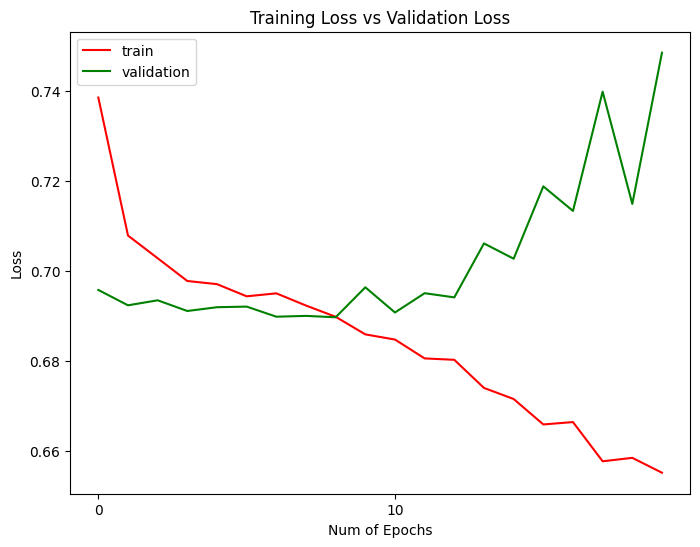

[I 2023-07-08 03:14:31,214] Trial 66 finished with value: 0.6897374987602234 and parameters: {'pT0Ref': 2.00624303356054, 'ecmPow': 0.032024431628076055, 'coreRadius': 0.737213108088727, 'coreFraction': 0.44445120222797485}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  2.095972745055474 0.0683893947322666 0.6591130043437274 0.5436623003430148
Pythia initialized
start
0
nCharged  56
1000
nCharged  104
2000
nCharged  204
3000
nCharged  50
4000
nCharged  2
5000
nCharged  130
6000
nCharged  28
7000
nCharged  40
8000
nCharged  48
9000
nCharged  254
(10001, 400, 3)
Max. nCharged =  540
Data shape:  (10001, 400, 3)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 64)                76864     
                                                                 
 dropout_201 (Dropout)       (None, 64)                0         
                                                                 
 dense_269 (Dense)           (None, 64)                4160      
                                                                 
 dropout_202 (Dropout)       (None, 64)                0         
               

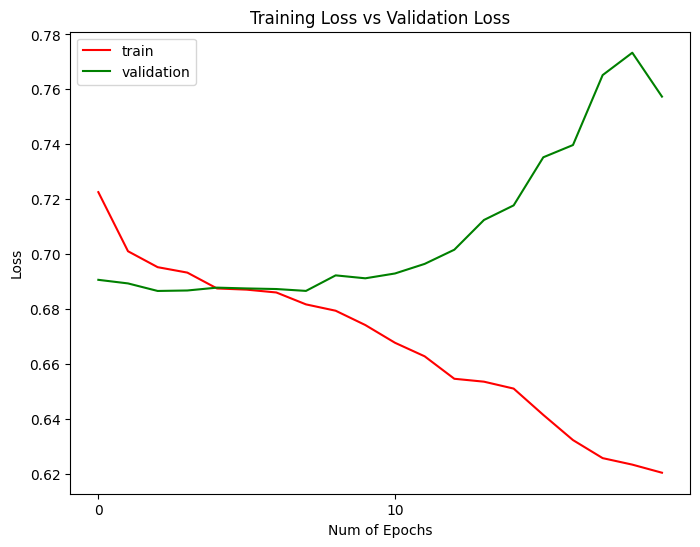

[I 2023-07-08 03:17:23,352] Trial 67 finished with value: 0.6865614652633667 and parameters: {'pT0Ref': 2.095972745055474, 'ecmPow': 0.0683893947322666, 'coreRadius': 0.6591130043437274, 'coreFraction': 0.5436623003430148}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.4268349162065777 0.0004467629916294069 0.7094045515756362 0.6638530871732063
Pythia initialized
start
0
nCharged  2
1000
nCharged  218
2000
nCharged  2
3000
nCharged  160
4000
nCharged  244
5000
nCharged  240
6000
nCharged  6
7000
nCharged  2
8000
nCharged  68
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  700
Data shape:  (10001, 400, 3)
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_272 (Dense)           (None, 64)                76864     
                                                                 
 dropout_204 (Dropout)       (None, 64)                0         
                                                                 
 dense_273 (Dense)           (None, 64)                4160      
                                                                 
 dropout_205 (Dropout)       (None, 64)                0         
               

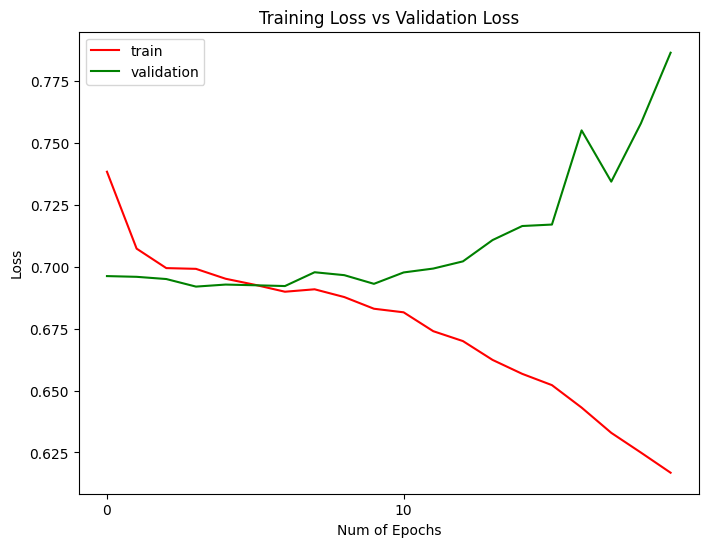

[I 2023-07-08 03:20:50,929] Trial 68 finished with value: 0.6919761896133423 and parameters: {'pT0Ref': 1.4268349162065777, 'ecmPow': 0.0004467629916294069, 'coreRadius': 0.7094045515756362, 'coreFraction': 0.6638530871732063}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.7062171686912047 0.10889518651056342 0.7890380787299038 0.47318442093448504
Pythia initialized
start
0
nCharged  50
1000
nCharged  92
2000
nCharged  98
3000
nCharged  40
4000
nCharged  80
5000
nCharged  68
6000
nCharged  22
7000
nCharged  32
8000
nCharged  166
9000
nCharged  88
(10001, 400, 3)
Max. nCharged =  624
Data shape:  (10001, 400, 3)
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 64)                76864     
                                                                 
 dropout_207 (Dropout)       (None, 64)                0         
                                                                 
 dense_277 (Dense)           (None, 64)                4160      
                                                                 
 dropout_208 (Dropout)       (None, 64)                0         
              

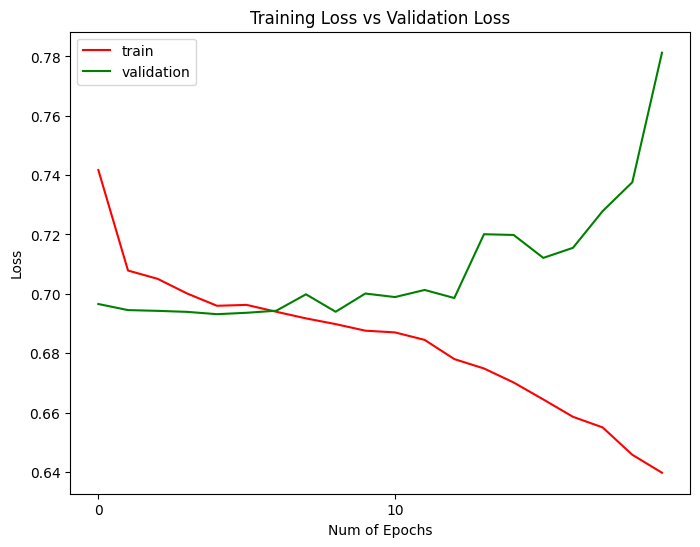

[I 2023-07-08 03:23:42,026] Trial 69 finished with value: 0.6931400895118713 and parameters: {'pT0Ref': 1.7062171686912047, 'ecmPow': 0.10889518651056342, 'coreRadius': 0.7890380787299038, 'coreFraction': 0.47318442093448504}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.5218507968776123 0.1290033859082068 0.8347431764916479 0.5165348591584087
Pythia initialized
start
0
nCharged  128
1000
nCharged  138
2000
nCharged  342
3000
nCharged  168
4000
nCharged  2
5000
nCharged  2
6000
nCharged  44
7000
nCharged  14
8000
nCharged  412
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  668
Data shape:  (10001, 400, 3)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_280 (Dense)           (None, 64)                76864     
                                                                 
 dropout_210 (Dropout)       (None, 64)                0         
                                                                 
 dense_281 (Dense)           (None, 64)                4160      
                                                                 
 dropout_211 (Dropout)       (None, 64)                0         
               

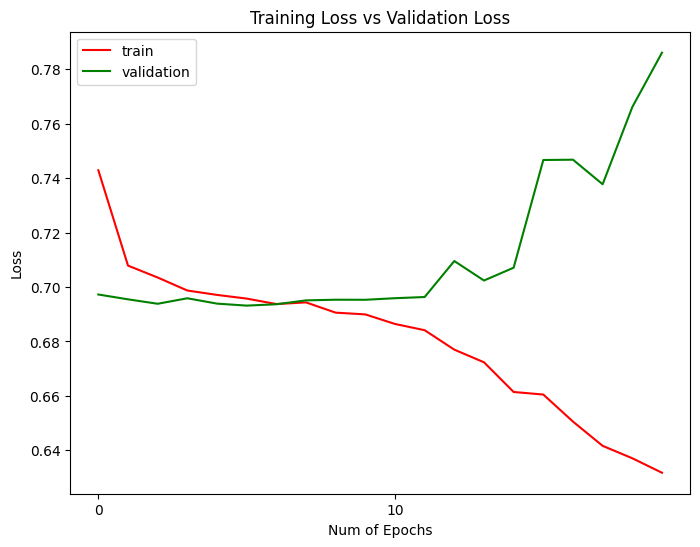

[I 2023-07-08 03:26:38,917] Trial 70 finished with value: 0.6931664347648621 and parameters: {'pT0Ref': 1.5218507968776123, 'ecmPow': 0.1290033859082068, 'coreRadius': 0.8347431764916479, 'coreFraction': 0.5165348591584087}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.61543980887512 0.013625958036279931 0.9004645050443109 0.5639212094056908
Pythia initialized
start
0
nCharged  294
1000
nCharged  40
2000
nCharged  10
3000
nCharged  2
4000
nCharged  22
5000
nCharged  2
6000
nCharged  2
7000
nCharged  2
8000
nCharged  56
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  652
Data shape:  (10001, 400, 3)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_284 (Dense)           (None, 64)                76864     
                                                                 
 dropout_213 (Dropout)       (None, 64)                0         
                                                                 
 dense_285 (Dense)           (None, 64)                4160      
                                                                 
 dropout_214 (Dropout)       (None, 64)                0         
                     

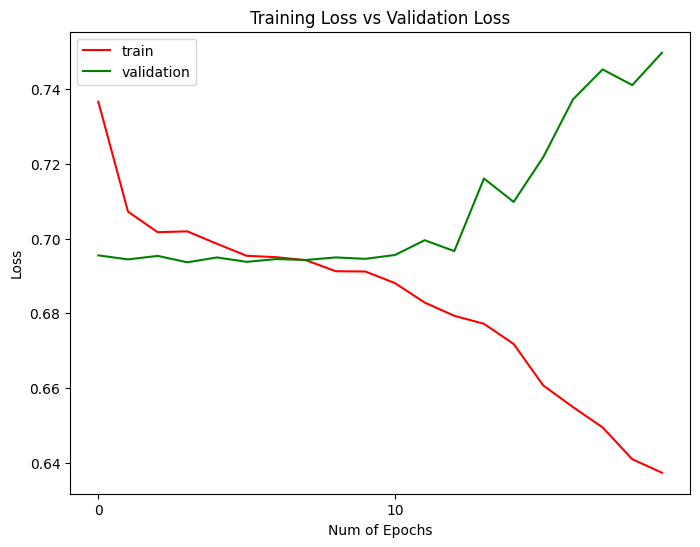

[I 2023-07-08 03:29:55,852] Trial 71 finished with value: 0.6936719417572021 and parameters: {'pT0Ref': 1.61543980887512, 'ecmPow': 0.013625958036279931, 'coreRadius': 0.9004645050443109, 'coreFraction': 0.5639212094056908}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8457375943841758 0.023785044482624966 0.9632427190975706 0.572772982329537
Pythia initialized
start
0
nCharged  32
1000
nCharged  2
2000
nCharged  34
3000
nCharged  134
4000
nCharged  10
5000
nCharged  48
6000
nCharged  448
7000
nCharged  2
8000
nCharged  118
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  632
Data shape:  (10001, 400, 3)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 64)                76864     
                                                                 
 dropout_216 (Dropout)       (None, 64)                0         
                                                                 
 dense_289 (Dense)           (None, 64)                4160      
                                                                 
 dropout_217 (Dropout)       (None, 64)                0         
                

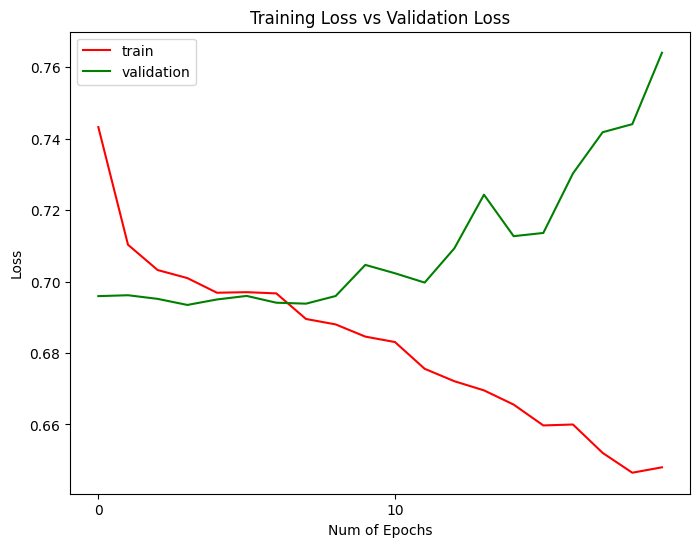

[I 2023-07-08 03:33:02,433] Trial 72 finished with value: 0.6934506297111511 and parameters: {'pT0Ref': 1.8457375943841758, 'ecmPow': 0.023785044482624966, 'coreRadius': 0.9632427190975706, 'coreFraction': 0.572772982329537}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.8873940489306114 0.021173305696189096 0.9638970135677989 0.5848983375092344
Pythia initialized
start
0
nCharged  338
1000
nCharged  202
2000
nCharged  398
3000
nCharged  2
4000
nCharged  22
5000
nCharged  64
6000
nCharged  198
7000
nCharged  72
8000
nCharged  48
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  638
Data shape:  (10001, 400, 3)
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_292 (Dense)           (None, 64)                76864     
                                                                 
 dropout_219 (Dropout)       (None, 64)                0         
                                                                 
 dense_293 (Dense)           (None, 64)                4160      
                                                                 
 dropout_220 (Dropout)       (None, 64)                0         
             

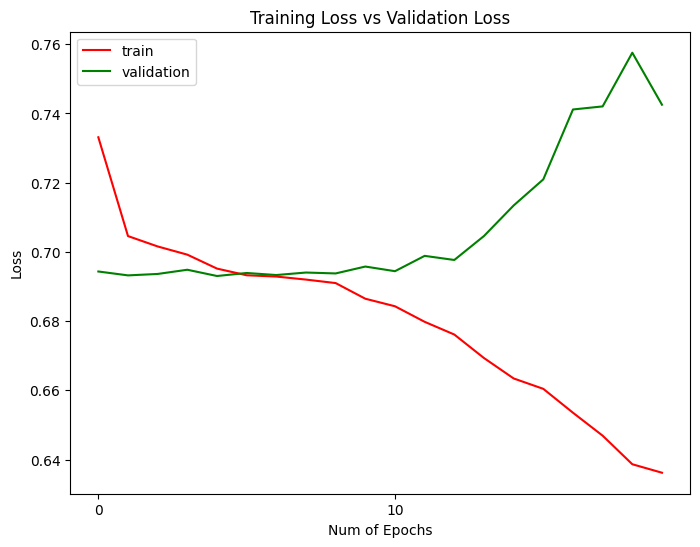

[I 2023-07-08 03:36:06,799] Trial 73 finished with value: 0.693024754524231 and parameters: {'pT0Ref': 1.8873940489306114, 'ecmPow': 0.021173305696189096, 'coreRadius': 0.9638970135677989, 'coreFraction': 0.5848983375092344}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  2.2483578118424083 0.026378453418443765 0.8816538531606046 0.6197630303315715
Pythia initialized
start
0
nCharged  68
1000
nCharged  106
2000
nCharged  2
3000
nCharged  104
4000
nCharged  224
5000
nCharged  2
6000
nCharged  2
7000
nCharged  2
8000
nCharged  50
9000
nCharged  14
(10001, 400, 3)
Max. nCharged =  496
Data shape:  (10001, 400, 3)
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 64)                76864     
                                                                 
 dropout_222 (Dropout)       (None, 64)                0         
                                                                 
 dense_297 (Dense)           (None, 64)                4160      
                                                                 
 dropout_223 (Dropout)       (None, 64)                0         
                

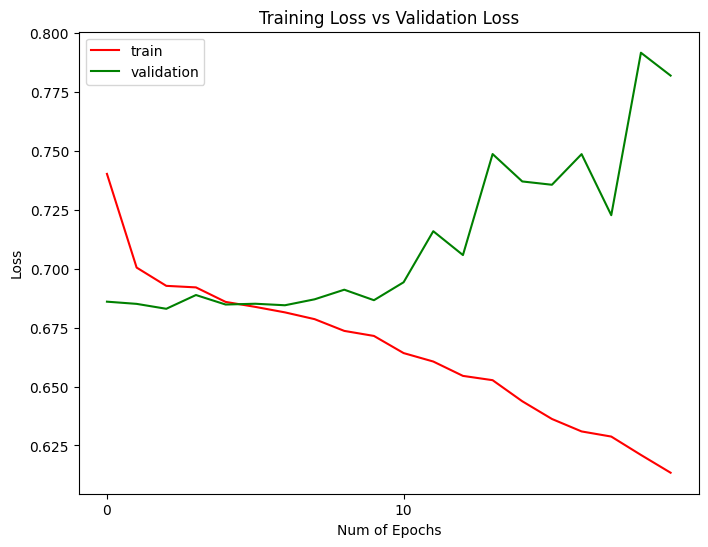

[I 2023-07-08 03:39:07,456] Trial 74 finished with value: 0.683001697063446 and parameters: {'pT0Ref': 2.2483578118424083, 'ecmPow': 0.026378453418443765, 'coreRadius': 0.8816538531606046, 'coreFraction': 0.6197630303315715}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.7962856519965709 0.041103989016983304 0.9074084470526484 0.5786511137827877
Pythia initialized
start
0
nCharged  372
1000
nCharged  156
2000
nCharged  68
3000
nCharged  62
4000
nCharged  82
5000
nCharged  66
6000
nCharged  18
7000
nCharged  54
8000
nCharged  342
9000
nCharged  92
(10001, 400, 3)
Max. nCharged =  688
Data shape:  (10001, 400, 3)
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, 64)                76864     
                                                                 
 dropout_225 (Dropout)       (None, 64)                0         
                                                                 
 dense_301 (Dense)           (None, 64)                4160      
                                                                 
 dropout_226 (Dropout)       (None, 64)                0         
            

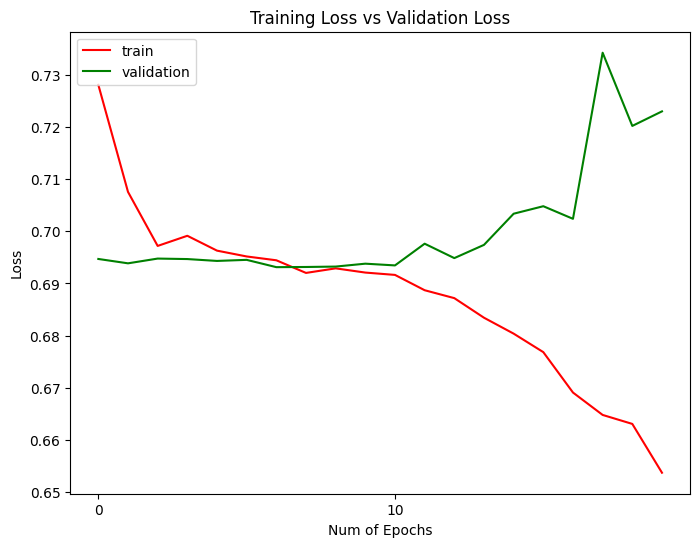

[I 2023-07-08 03:42:08,873] Trial 75 finished with value: 0.6931231617927551 and parameters: {'pT0Ref': 1.7962856519965709, 'ecmPow': 0.041103989016983304, 'coreRadius': 0.9074084470526484, 'coreFraction': 0.5786511137827877}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.6667609269881216 0.05537985320125272 0.9337838778004011 0.6376471951698889
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  2
3000
nCharged  2
4000
nCharged  38
5000
nCharged  196
6000
nCharged  124
7000
nCharged  24
8000
nCharged  48
9000
nCharged  268
(10001, 400, 3)
Max. nCharged =  670
Data shape:  (10001, 400, 3)
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 64)                76864     
                                                                 
 dropout_228 (Dropout)       (None, 64)                0         
                                                                 
 dense_305 (Dense)           (None, 64)                4160      
                                                                 
 dropout_229 (Dropout)       (None, 64)                0         
                 

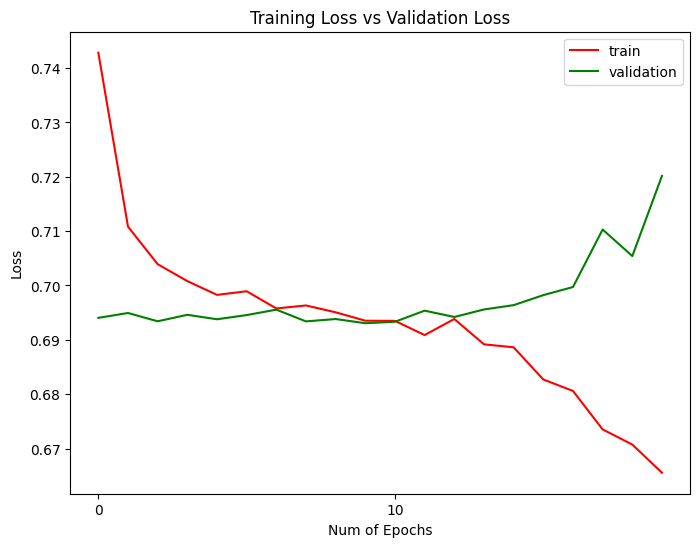

[I 2023-07-08 03:45:11,440] Trial 76 finished with value: 0.693050742149353 and parameters: {'pT0Ref': 1.6667609269881216, 'ecmPow': 0.05537985320125272, 'coreRadius': 0.9337838778004011, 'coreFraction': 0.6376471951698889}. Best is trial 50 with value: 0.6937376260757446.


Optuna suggested x =  1.5441491051738305 0.026048713983753153 0.9625017585307307 0.5493101572602832
Pythia initialized
start
0
nCharged  372
1000
nCharged  126
2000
nCharged  2
3000
nCharged  194
4000
nCharged  64
5000
nCharged  2
6000
nCharged  2
7000
nCharged  180
8000
nCharged  2
9000
nCharged  280
(10001, 400, 3)
Max. nCharged =  650
Data shape:  (10001, 400, 3)
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_308 (Dense)           (None, 64)                76864     
                                                                 
 dropout_231 (Dropout)       (None, 64)                0         
                                                                 
 dense_309 (Dense)           (None, 64)                4160      
                                                                 
 dropout_232 (Dropout)       (None, 64)                0         
              

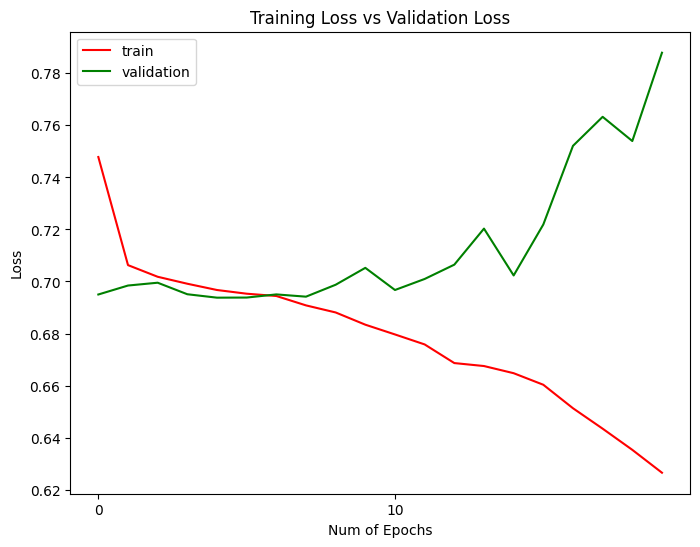

[I 2023-07-08 03:48:28,616] Trial 77 finished with value: 0.6937851905822754 and parameters: {'pT0Ref': 1.5441491051738305, 'ecmPow': 0.026048713983753153, 'coreRadius': 0.9625017585307307, 'coreFraction': 0.5493101572602832}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.3332957771887335 0.019275028992155933 0.9836517798218122 0.6908611339561183
Pythia initialized
start
0
nCharged  282
1000
nCharged  2
2000
nCharged  136
3000
nCharged  30
4000
nCharged  2
5000
nCharged  32
6000
nCharged  48
7000
nCharged  26
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  816
Data shape:  (10001, 400, 3)
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_312 (Dense)           (None, 64)                76864     
                                                                 
 dropout_234 (Dropout)       (None, 64)                0         
                                                                 
 dense_313 (Dense)           (None, 64)                4160      
                                                                 
 dropout_235 (Dropout)       (None, 64)                0         
                 

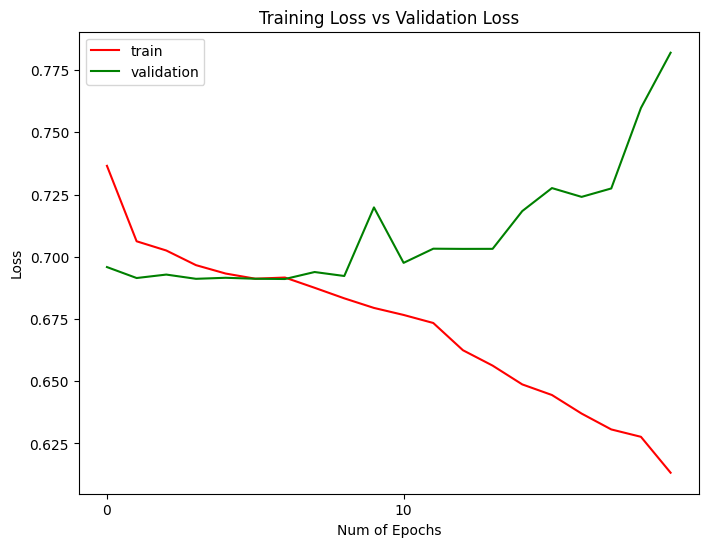

[I 2023-07-08 03:52:01,730] Trial 78 finished with value: 0.6910775899887085 and parameters: {'pT0Ref': 1.3332957771887335, 'ecmPow': 0.019275028992155933, 'coreRadius': 0.9836517798218122, 'coreFraction': 0.6908611339561183}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.5384387769415289 0.013003735396176927 0.9285279718938263 0.5510363397503291
Pythia initialized
start
0
nCharged  22
1000
nCharged  282
2000
nCharged  28
3000
nCharged  40
4000
nCharged  2
5000
nCharged  550
6000
nCharged  18
7000
nCharged  38
8000
nCharged  120
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  692
Data shape:  (10001, 400, 3)
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_316 (Dense)           (None, 64)                76864     
                                                                 
 dropout_237 (Dropout)       (None, 64)                0         
                                                                 
 dense_317 (Dense)           (None, 64)                4160      
                                                                 
 dropout_238 (Dropout)       (None, 64)                0         
              

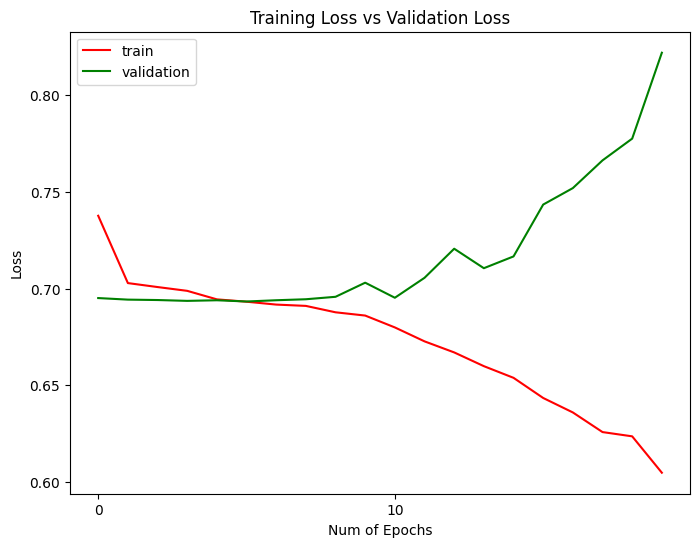

[I 2023-07-08 03:55:21,290] Trial 79 finished with value: 0.6933049559593201 and parameters: {'pT0Ref': 1.5384387769415289, 'ecmPow': 0.013003735396176927, 'coreRadius': 0.9285279718938263, 'coreFraction': 0.5510363397503291}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.3757300036018327 0.056082424371363945 0.9695596054446123 0.5355465507869389
Pythia initialized
start
0
nCharged  372
1000
nCharged  94
2000
nCharged  2
3000
nCharged  70
4000
nCharged  46
5000
nCharged  126
6000
nCharged  2
7000
nCharged  2
8000
nCharged  16
9000
nCharged  242
(10001, 400, 3)
Max. nCharged =  782
Data shape:  (10001, 400, 3)
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_320 (Dense)           (None, 64)                76864     
                                                                 
 dropout_240 (Dropout)       (None, 64)                0         
                                                                 
 dense_321 (Dense)           (None, 64)                4160      
                                                                 
 dropout_241 (Dropout)       (None, 64)                0         
               

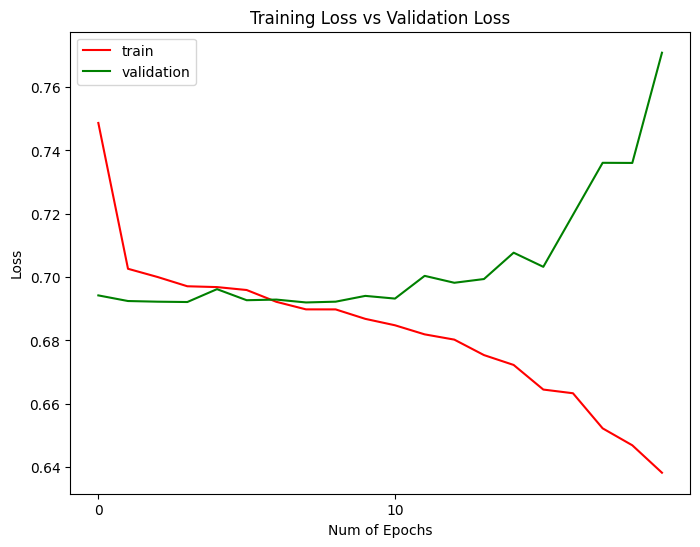

[I 2023-07-08 03:58:41,535] Trial 80 finished with value: 0.6920030117034912 and parameters: {'pT0Ref': 1.3757300036018327, 'ecmPow': 0.056082424371363945, 'coreRadius': 0.9695596054446123, 'coreFraction': 0.5355465507869389}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.7732449658067024 0.04277146662073371 0.9466160061812017 0.49790191389118527
Pythia initialized
start
0
nCharged  336
1000
nCharged  166
2000
nCharged  36
3000
nCharged  118
4000
nCharged  24
5000
nCharged  2
6000
nCharged  40
7000
nCharged  2
8000
nCharged  30
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  590
Data shape:  (10001, 400, 3)
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 64)                76864     
                                                                 
 dropout_243 (Dropout)       (None, 64)                0         
                                                                 
 dense_325 (Dense)           (None, 64)                4160      
                                                                 
 dropout_244 (Dropout)       (None, 64)                0         
               

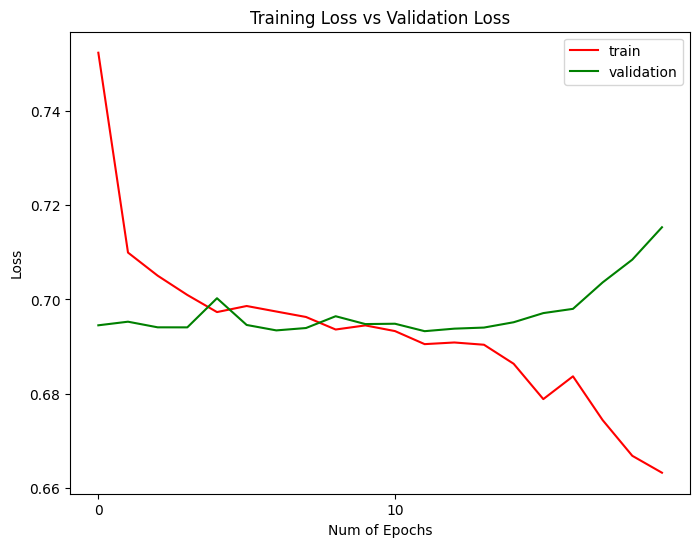

[I 2023-07-08 04:01:46,226] Trial 81 finished with value: 0.6932580471038818 and parameters: {'pT0Ref': 1.7732449658067024, 'ecmPow': 0.04277146662073371, 'coreRadius': 0.9466160061812017, 'coreFraction': 0.49790191389118527}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.8882097119038863 0.03243148633429768 0.991783379683002 0.591886695965561
Pythia initialized
start
0
nCharged  280
1000
nCharged  2
2000
nCharged  92
3000
nCharged  174
4000
nCharged  2
5000
nCharged  88
6000
nCharged  190
7000
nCharged  352
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  586
Data shape:  (10001, 400, 3)
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_328 (Dense)           (None, 64)                76864     
                                                                 
 dropout_246 (Dropout)       (None, 64)                0         
                                                                 
 dense_329 (Dense)           (None, 64)                4160      
                                                                 
 dropout_247 (Dropout)       (None, 64)                0         
                  

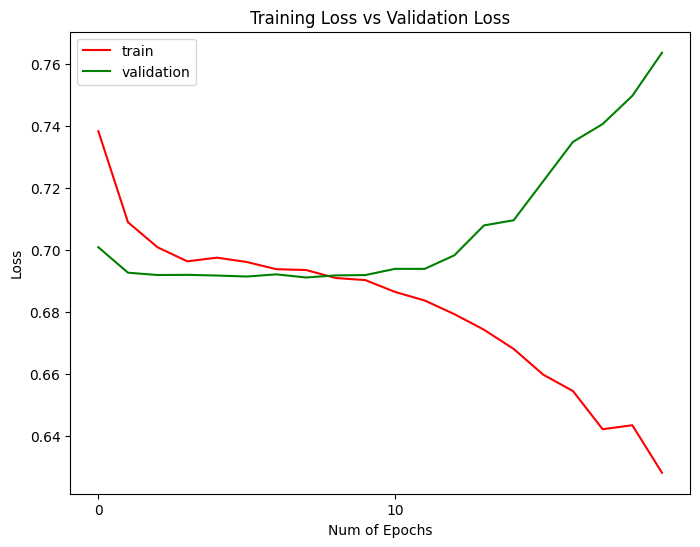

[I 2023-07-08 04:04:48,010] Trial 82 finished with value: 0.6911988258361816 and parameters: {'pT0Ref': 1.8882097119038863, 'ecmPow': 0.03243148633429768, 'coreRadius': 0.991783379683002, 'coreFraction': 0.591886695965561}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.5647418943094313 0.008654484258778579 0.8949357381401774 0.5639865792862099
Pythia initialized
start
0
nCharged  46
1000
nCharged  94
2000
nCharged  124
3000
nCharged  90
4000
nCharged  90
5000
nCharged  62
6000
nCharged  144
7000
nCharged  142
8000
nCharged  2
9000
nCharged  14
(10001, 400, 3)
Max. nCharged =  752
Data shape:  (10001, 400, 3)
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_332 (Dense)           (None, 64)                76864     
                                                                 
 dropout_249 (Dropout)       (None, 64)                0         
                                                                 
 dense_333 (Dense)           (None, 64)                4160      
                                                                 
 dropout_250 (Dropout)       (None, 64)                0         
             

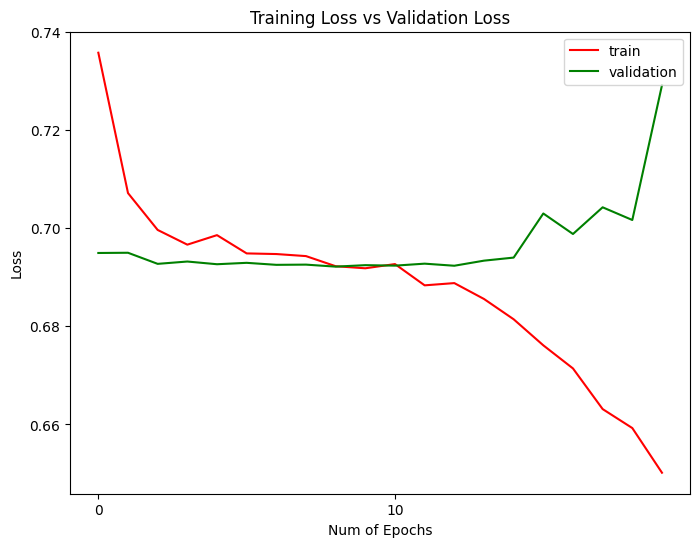

[I 2023-07-08 04:08:09,264] Trial 83 finished with value: 0.6921769976615906 and parameters: {'pT0Ref': 1.5647418943094313, 'ecmPow': 0.008654484258778579, 'coreRadius': 0.8949357381401774, 'coreFraction': 0.5639865792862099}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.2090302389566792 0.06649205921010681 0.923932883342461 0.6145756341291999
Pythia initialized
start
0
nCharged  320
1000
nCharged  138
2000
nCharged  34
3000
nCharged  6
4000
nCharged  32
5000
nCharged  30
6000
nCharged  76
7000
nCharged  8
8000
nCharged  112
9000
nCharged  388
(10001, 400, 3)
Max. nCharged =  778
Data shape:  (10001, 400, 3)
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_336 (Dense)           (None, 64)                76864     
                                                                 
 dropout_252 (Dropout)       (None, 64)                0         
                                                                 
 dense_337 (Dense)           (None, 64)                4160      
                                                                 
 dropout_253 (Dropout)       (None, 64)                0         
               

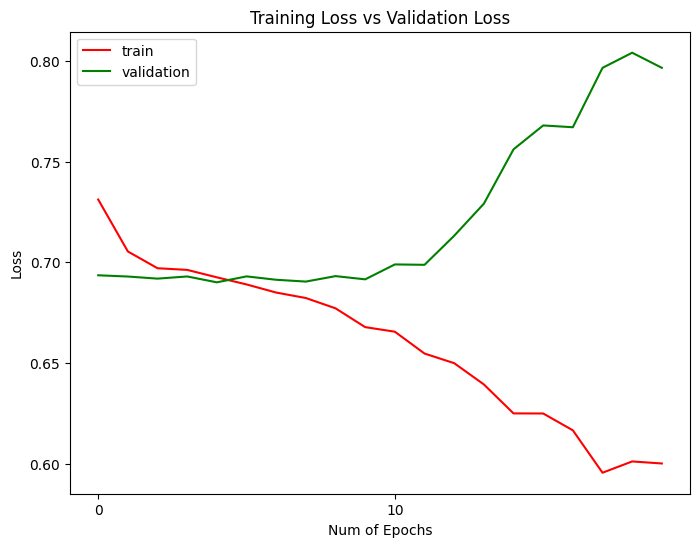

[I 2023-07-08 04:11:39,949] Trial 84 finished with value: 0.6900482177734375 and parameters: {'pT0Ref': 1.2090302389566792, 'ecmPow': 0.06649205921010681, 'coreRadius': 0.923932883342461, 'coreFraction': 0.6145756341291999}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.448376294909451 0.0800576048206524 0.8683942915688723 0.5229063064765503
Pythia initialized
start
0
nCharged  388
1000
nCharged  46
2000
nCharged  2
3000
nCharged  38
4000
nCharged  32
5000
nCharged  44
6000
nCharged  84
7000
nCharged  50
8000
nCharged  480
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  726
Data shape:  (10001, 400, 3)
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_340 (Dense)           (None, 64)                76864     
                                                                 
 dropout_255 (Dropout)       (None, 64)                0         
                                                                 
 dense_341 (Dense)           (None, 64)                4160      
                                                                 
 dropout_256 (Dropout)       (None, 64)                0         
                  

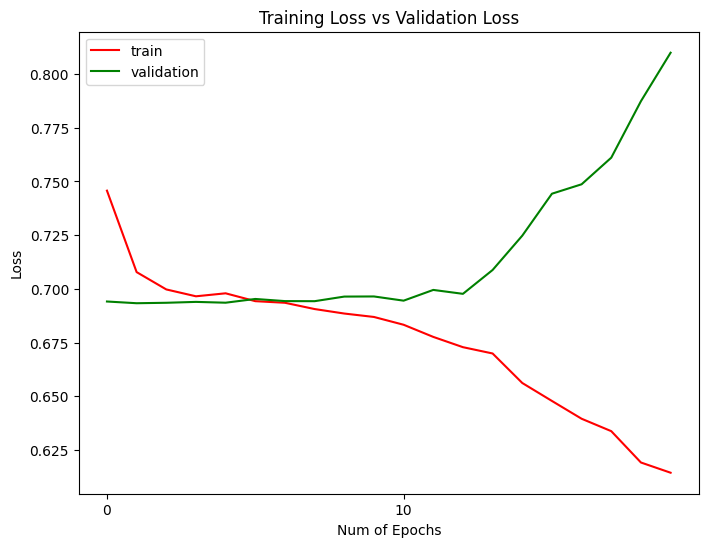

[I 2023-07-08 04:14:45,925] Trial 85 finished with value: 0.693290114402771 and parameters: {'pT0Ref': 1.448376294909451, 'ecmPow': 0.0800576048206524, 'coreRadius': 0.8683942915688723, 'coreFraction': 0.5229063064765503}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.6341287850979298 0.025792569660970512 0.9639490374169085 0.49353883137992266
Pythia initialized
start
0
nCharged  432
1000
nCharged  48
2000
nCharged  50
3000
nCharged  2
4000
nCharged  480
5000
nCharged  40
6000
nCharged  124
7000
nCharged  28
8000
nCharged  2
9000
nCharged  22
(10001, 400, 3)
Max. nCharged =  670
Data shape:  (10001, 400, 3)
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_344 (Dense)           (None, 64)                76864     
                                                                 
 dropout_258 (Dropout)       (None, 64)                0         
                                                                 
 dense_345 (Dense)           (None, 64)                4160      
                                                                 
 dropout_259 (Dropout)       (None, 64)                0         
             

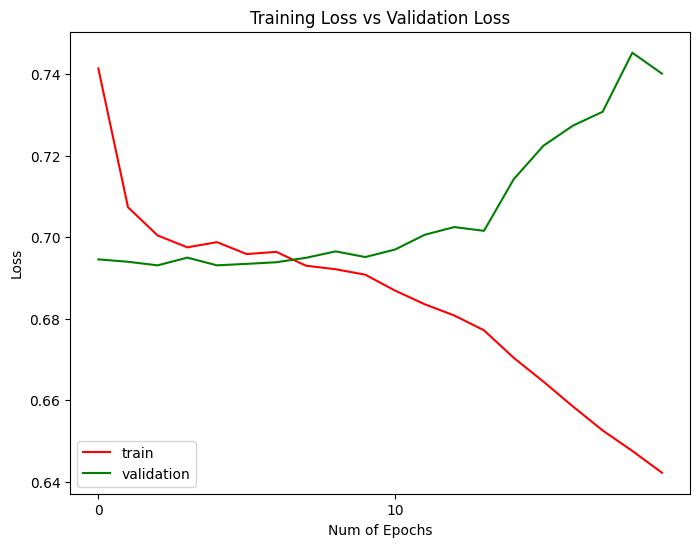

[I 2023-07-08 04:17:57,351] Trial 86 finished with value: 0.6930739879608154 and parameters: {'pT0Ref': 1.6341287850979298, 'ecmPow': 0.025792569660970512, 'coreRadius': 0.9639490374169085, 'coreFraction': 0.49353883137992266}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  2.0511479141643303 0.04931557519058559 0.8827970742853917 0.4350437966969756
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  32
3000
nCharged  2
4000
nCharged  66
5000
nCharged  44
6000
nCharged  60
7000
nCharged  14
8000
nCharged  60
9000
nCharged  32
(10001, 400, 3)
Max. nCharged =  570
Data shape:  (10001, 400, 3)
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_348 (Dense)           (None, 64)                76864     
                                                                 
 dropout_261 (Dropout)       (None, 64)                0         
                                                                 
 dense_349 (Dense)           (None, 64)                4160      
                                                                 
 dropout_262 (Dropout)       (None, 64)                0         
                   

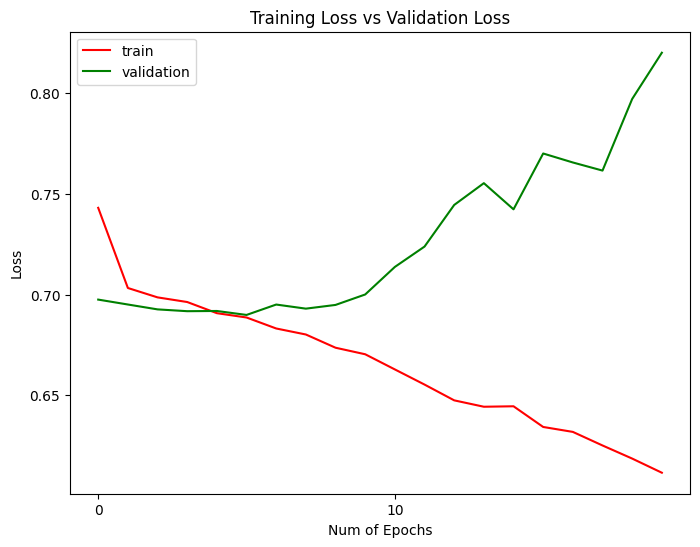

[I 2023-07-08 04:20:55,605] Trial 87 finished with value: 0.6898913979530334 and parameters: {'pT0Ref': 2.0511479141643303, 'ecmPow': 0.04931557519058559, 'coreRadius': 0.8827970742853917, 'coreFraction': 0.4350437966969756}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.9692095754417105 0.0057360206731934555 0.910076432490815 0.5565014342103473
Pythia initialized
start
0
nCharged  318
1000
nCharged  98
2000
nCharged  44
3000
nCharged  2
4000
nCharged  132
5000
nCharged  478
6000
nCharged  86
7000
nCharged  2
8000
nCharged  244
9000
nCharged  66
(10001, 400, 3)
Max. nCharged =  602
Data shape:  (10001, 400, 3)
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_352 (Dense)           (None, 64)                76864     
                                                                 
 dropout_264 (Dropout)       (None, 64)                0         
                                                                 
 dense_353 (Dense)           (None, 64)                4160      
                                                                 
 dropout_265 (Dropout)       (None, 64)                0         
             

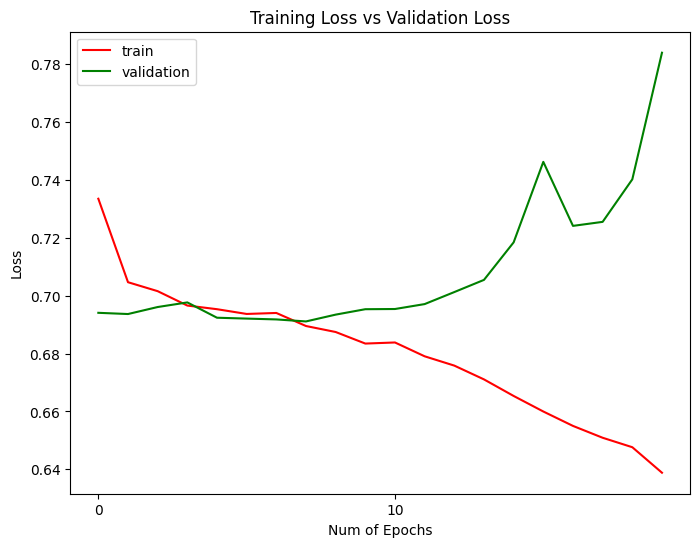

[I 2023-07-08 04:24:04,467] Trial 88 finished with value: 0.6911092400550842 and parameters: {'pT0Ref': 1.9692095754417105, 'ecmPow': 0.0057360206731934555, 'coreRadius': 0.910076432490815, 'coreFraction': 0.5565014342103473}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.7432892202212438 0.08868201543387402 0.9402986587833282 0.5831661229714277
Pythia initialized
start
0
nCharged  8
1000
nCharged  36
2000
nCharged  34
3000
nCharged  432
4000
nCharged  504
5000
nCharged  100
6000
nCharged  38
7000
nCharged  60
8000
nCharged  24
9000
nCharged  76
(10001, 400, 3)
Max. nCharged =  598
Data shape:  (10001, 400, 3)
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_356 (Dense)           (None, 64)                76864     
                                                                 
 dropout_267 (Dropout)       (None, 64)                0         
                                                                 
 dense_357 (Dense)           (None, 64)                4160      
                                                                 
 dropout_268 (Dropout)       (None, 64)                0         
              

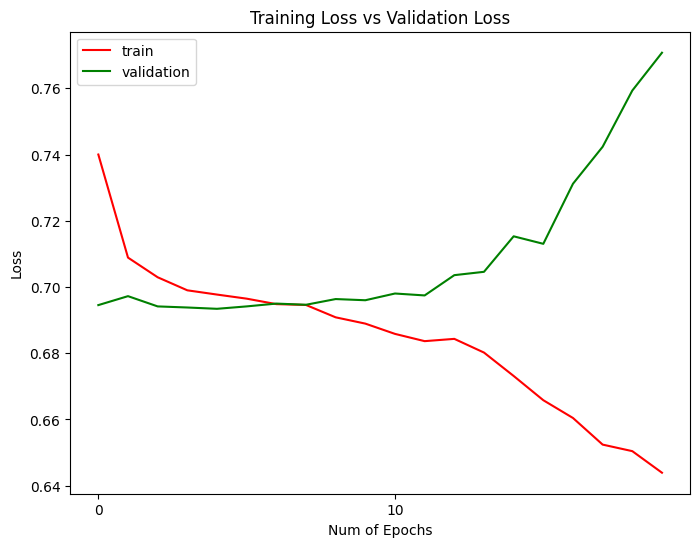

[I 2023-07-08 04:26:58,772] Trial 89 finished with value: 0.6934118866920471 and parameters: {'pT0Ref': 1.7432892202212438, 'ecmPow': 0.08868201543387402, 'coreRadius': 0.9402986587833282, 'coreFraction': 0.5831661229714277}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.663765392936583 0.039317566187568515 0.8518311000638843 0.4807278207378114
Pythia initialized
start
0
nCharged  318
1000
nCharged  78
2000
nCharged  2
3000
nCharged  282
4000
nCharged  320
5000
nCharged  148
6000
nCharged  42
7000
nCharged  2
8000
nCharged  2
9000
nCharged  50
(10001, 400, 3)
Max. nCharged =  618
Data shape:  (10001, 400, 3)
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, 64)                76864     
                                                                 
 dropout_270 (Dropout)       (None, 64)                0         
                                                                 
 dense_361 (Dense)           (None, 64)                4160      
                                                                 
 dropout_271 (Dropout)       (None, 64)                0         
               

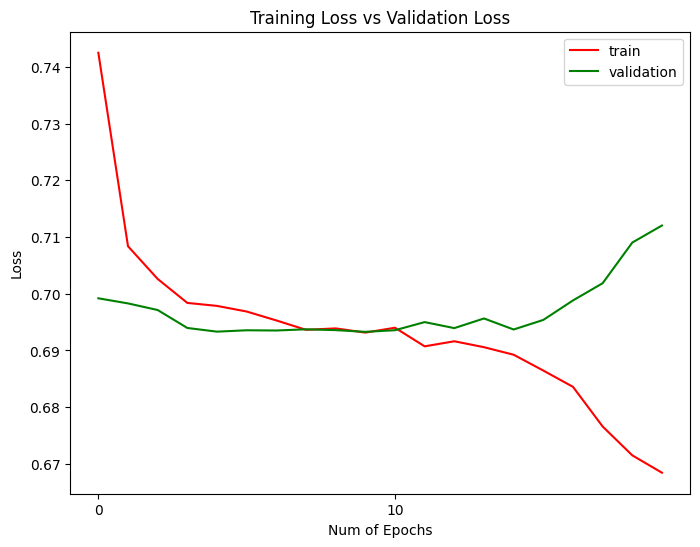

[I 2023-07-08 04:30:04,962] Trial 90 finished with value: 0.6932745575904846 and parameters: {'pT0Ref': 1.663765392936583, 'ecmPow': 0.039317566187568515, 'coreRadius': 0.8518311000638843, 'coreFraction': 0.4807278207378114}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.4242447339157547 0.07171444780875671 0.7461652559839083 0.4602985254630355
Pythia initialized
start
0
nCharged  2
1000
nCharged  506
2000
nCharged  122
3000
nCharged  224
4000
nCharged  206
5000
nCharged  128
6000
nCharged  168
7000
nCharged  48
8000
nCharged  72
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  710
Data shape:  (10001, 400, 3)
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 64)                76864     
                                                                 
 dropout_273 (Dropout)       (None, 64)                0         
                                                                 
 dense_365 (Dense)           (None, 64)                4160      
                                                                 
 dropout_274 (Dropout)       (None, 64)                0         
           

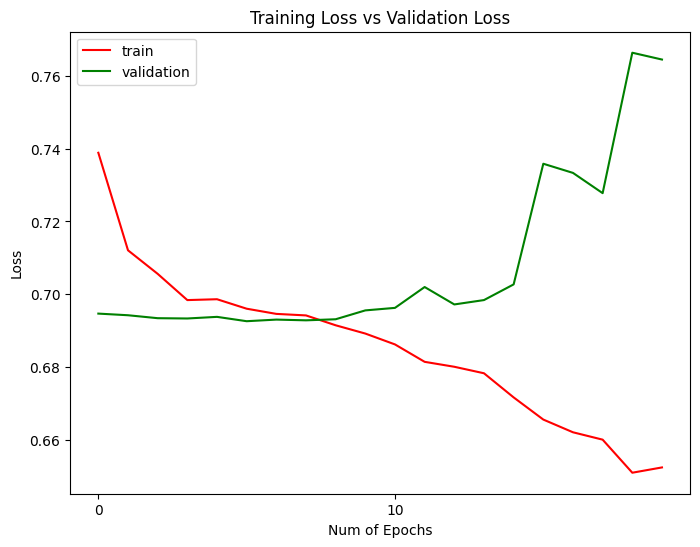

[I 2023-07-08 04:33:15,554] Trial 91 finished with value: 0.6926373243331909 and parameters: {'pT0Ref': 1.4242447339157547, 'ecmPow': 0.07171444780875671, 'coreRadius': 0.7461652559839083, 'coreFraction': 0.4602985254630355}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.6080606151171468 0.09737781710438692 0.8221529023687371 0.5145852551926895
Pythia initialized
start
0
nCharged  118
1000
nCharged  28
2000
nCharged  370
3000
nCharged  32
4000
nCharged  402
5000
nCharged  258
6000
nCharged  16
7000
nCharged  186
8000
nCharged  138
9000
nCharged  10
(10001, 400, 3)
Max. nCharged =  634
Data shape:  (10001, 400, 3)
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_368 (Dense)           (None, 64)                76864     
                                                                 
 dropout_276 (Dropout)       (None, 64)                0         
                                                                 
 dense_369 (Dense)           (None, 64)                4160      
                                                                 
 dropout_277 (Dropout)       (None, 64)                0         
          

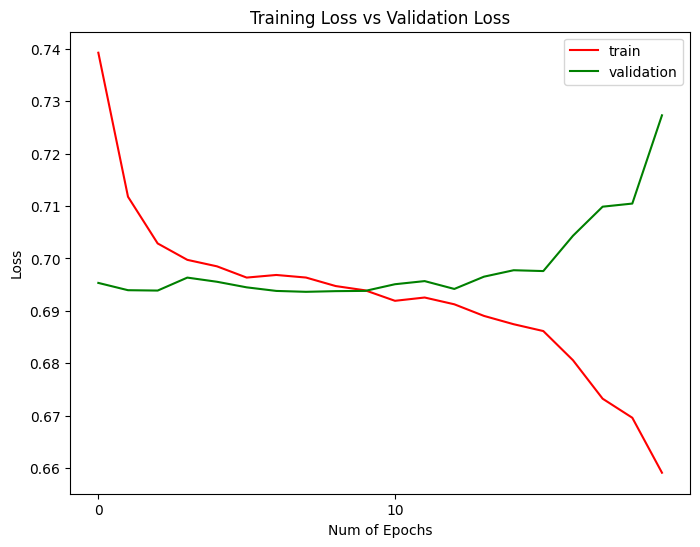

[I 2023-07-08 04:36:10,658] Trial 92 finished with value: 0.69363933801651 and parameters: {'pT0Ref': 1.6080606151171468, 'ecmPow': 0.09737781710438692, 'coreRadius': 0.8221529023687371, 'coreFraction': 0.5145852551926895}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.543154694230433 0.06251468178553163 0.8215681454565535 0.5389735619108968
Pythia initialized
start
0
nCharged  2
1000
nCharged  76
2000
nCharged  314
3000
nCharged  42
4000
nCharged  372
5000
nCharged  210
6000
nCharged  126
7000
nCharged  4
8000
nCharged  284
9000
nCharged  342
(10001, 400, 3)
Max. nCharged =  692
Data shape:  (10001, 400, 3)
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_372 (Dense)           (None, 64)                76864     
                                                                 
 dropout_279 (Dropout)       (None, 64)                0         
                                                                 
 dense_373 (Dense)           (None, 64)                4160      
                                                                 
 dropout_280 (Dropout)       (None, 64)                0         
             

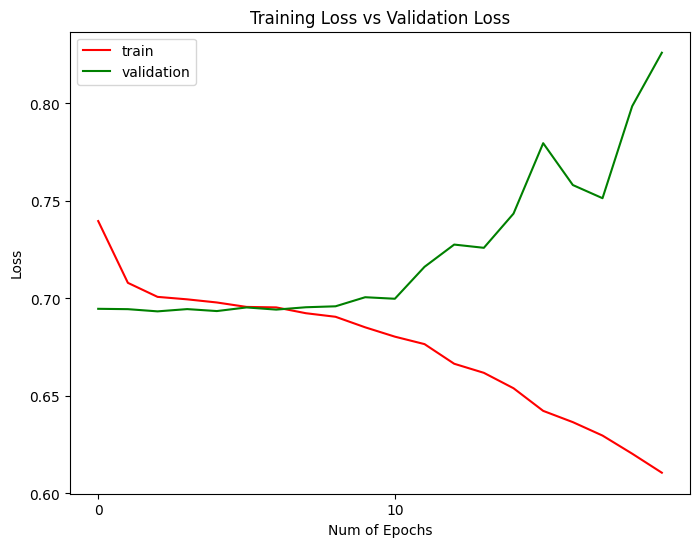

[I 2023-07-08 04:39:15,054] Trial 93 finished with value: 0.6933593153953552 and parameters: {'pT0Ref': 1.543154694230433, 'ecmPow': 0.06251468178553163, 'coreRadius': 0.8215681454565535, 'coreFraction': 0.5389735619108968}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.8161184740500689 0.09384251849500222 0.8790376099350996 0.5110547270493383
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  2
3000
nCharged  10
4000
nCharged  2
5000
nCharged  2
6000
nCharged  2
7000
nCharged  120
8000
nCharged  276
9000
nCharged  20
(10001, 400, 3)
Max. nCharged =  598
Data shape:  (10001, 400, 3)
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_376 (Dense)           (None, 64)                76864     
                                                                 
 dropout_282 (Dropout)       (None, 64)                0         
                                                                 
 dense_377 (Dense)           (None, 64)                4160      
                                                                 
 dropout_283 (Dropout)       (None, 64)                0         
                    

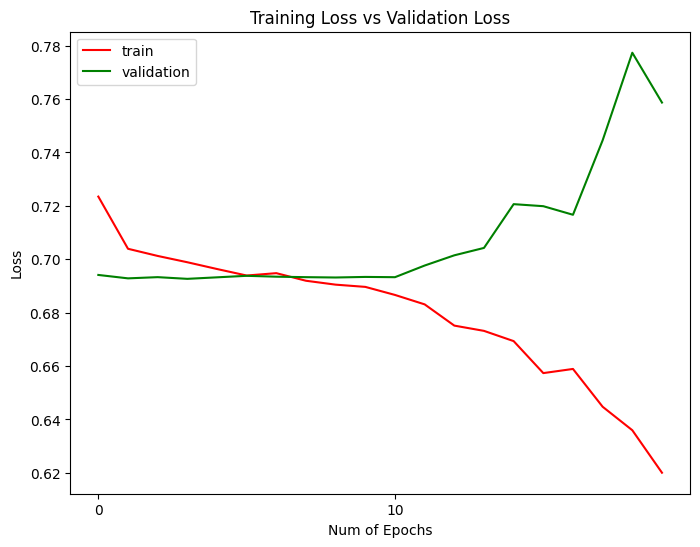

[I 2023-07-08 04:42:04,321] Trial 94 finished with value: 0.6926591992378235 and parameters: {'pT0Ref': 1.8161184740500689, 'ecmPow': 0.09384251849500222, 'coreRadius': 0.8790376099350996, 'coreFraction': 0.5110547270493383}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.9181193369982694 0.07957817623341912 0.9011859173136992 0.5080378228922446
Pythia initialized
start
0
nCharged  2
1000
nCharged  262
2000
nCharged  188
3000
nCharged  56
4000
nCharged  210
5000
nCharged  2
6000
nCharged  32
7000
nCharged  20
8000
nCharged  188
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  592
Data shape:  (10001, 400, 3)
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_380 (Dense)           (None, 64)                76864     
                                                                 
 dropout_285 (Dropout)       (None, 64)                0         
                                                                 
 dense_381 (Dense)           (None, 64)                4160      
                                                                 
 dropout_286 (Dropout)       (None, 64)                0         
               

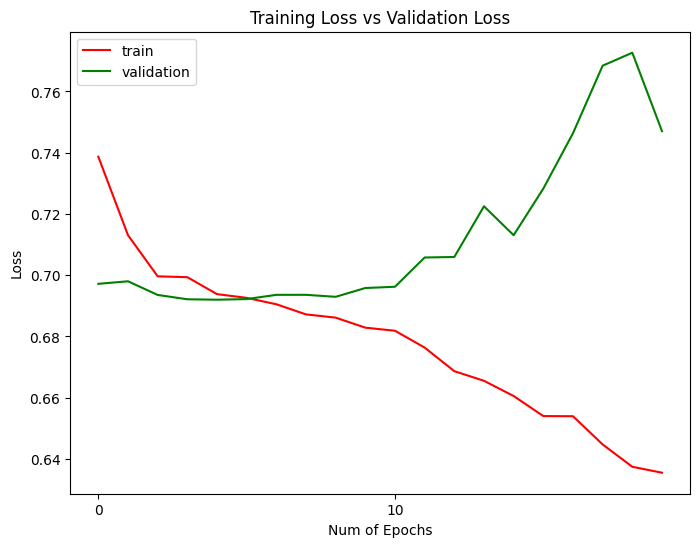

[I 2023-07-08 04:44:56,532] Trial 95 finished with value: 0.6919906139373779 and parameters: {'pT0Ref': 1.9181193369982694, 'ecmPow': 0.07957817623341912, 'coreRadius': 0.9011859173136992, 'coreFraction': 0.5080378228922446}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.6878153444020663 0.027713716701995735 0.7923228307478053 0.5996132657392825
Pythia initialized
start
0
nCharged  2
1000
nCharged  130
2000
nCharged  2
3000
nCharged  18
4000
nCharged  252
5000
nCharged  182
6000
nCharged  222
7000
nCharged  208
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  632
Data shape:  (10001, 400, 3)
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_384 (Dense)           (None, 64)                76864     
                                                                 
 dropout_288 (Dropout)       (None, 64)                0         
                                                                 
 dense_385 (Dense)           (None, 64)                4160      
                                                                 
 dropout_289 (Dropout)       (None, 64)                0         
              

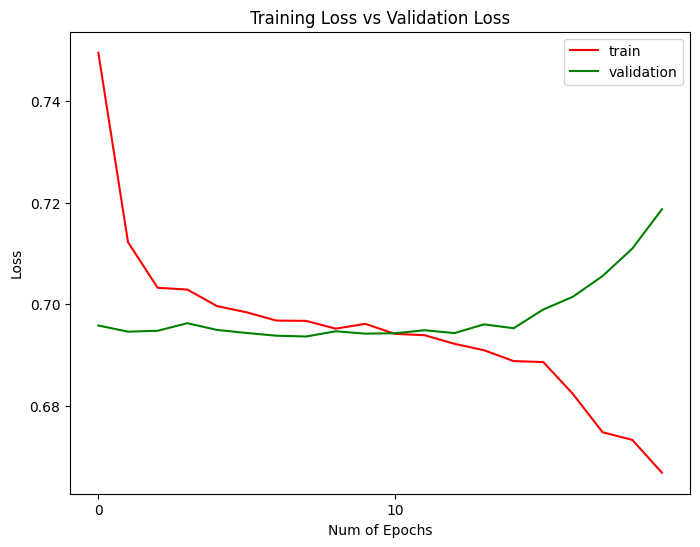

[I 2023-07-08 04:48:07,171] Trial 96 finished with value: 0.6936429738998413 and parameters: {'pT0Ref': 1.6878153444020663, 'ecmPow': 0.027713716701995735, 'coreRadius': 0.7923228307478053, 'coreFraction': 0.5996132657392825}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.693283578687559 0.09964452949660704 0.854975638343018 0.5708981055337791
Pythia initialized
start
0
nCharged  348
1000
nCharged  22
2000
nCharged  24
3000
nCharged  2
4000
nCharged  40
5000
nCharged  18
6000
nCharged  2
7000
nCharged  28
8000
nCharged  88
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  654
Data shape:  (10001, 400, 3)
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_388 (Dense)           (None, 64)                76864     
                                                                 
 dropout_291 (Dropout)       (None, 64)                0         
                                                                 
 dense_389 (Dense)           (None, 64)                4160      
                                                                 
 dropout_292 (Dropout)       (None, 64)                0         
                   

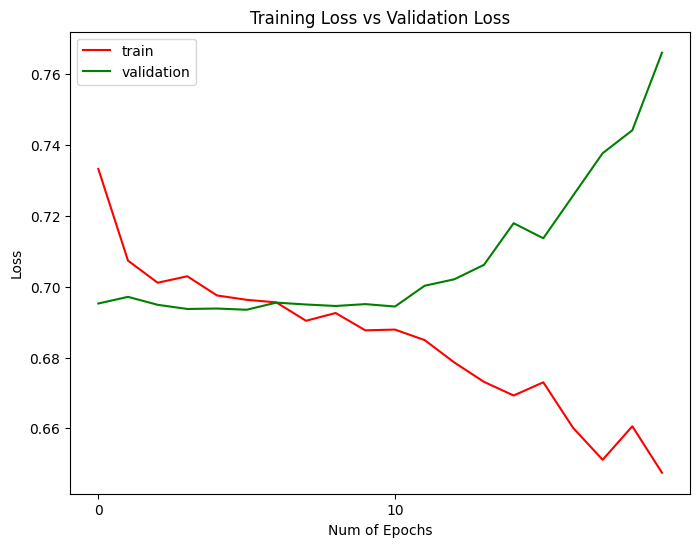

[I 2023-07-08 04:51:02,136] Trial 97 finished with value: 0.6934927701950073 and parameters: {'pT0Ref': 1.693283578687559, 'ecmPow': 0.09964452949660704, 'coreRadius': 0.854975638343018, 'coreFraction': 0.5708981055337791}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.5055195079812078 0.11467154835056118 0.8386717675702862 0.5411666940000588
Pythia initialized
start
0
nCharged  126
1000
nCharged  2
2000
nCharged  40
3000
nCharged  6
4000
nCharged  30
5000
nCharged  14
6000
nCharged  174
7000
nCharged  428
8000
nCharged  4
9000
nCharged  372
(10001, 400, 3)
Max. nCharged =  696
Data shape:  (10001, 400, 3)
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_392 (Dense)           (None, 64)                76864     
                                                                 
 dropout_294 (Dropout)       (None, 64)                0         
                                                                 
 dense_393 (Dense)           (None, 64)                4160      
                                                                 
 dropout_295 (Dropout)       (None, 64)                0         
               

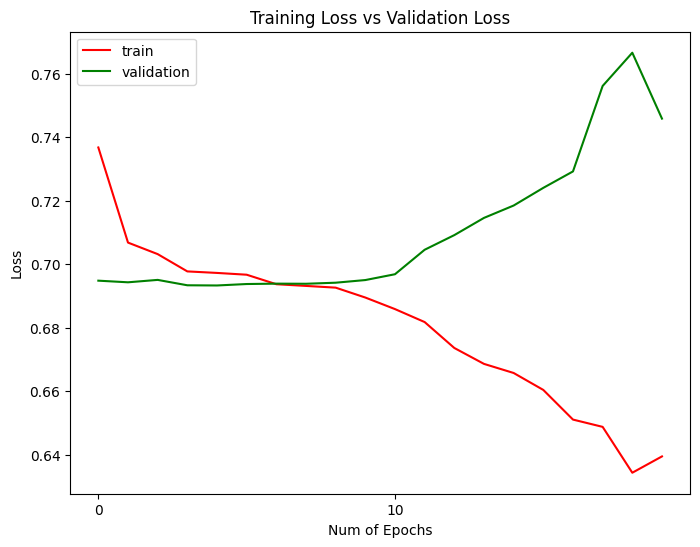

[I 2023-07-08 04:54:00,279] Trial 98 finished with value: 0.6933165788650513 and parameters: {'pT0Ref': 1.5055195079812078, 'ecmPow': 0.11467154835056118, 'coreRadius': 0.8386717675702862, 'coreFraction': 0.5411666940000588}. Best is trial 77 with value: 0.6937851905822754.


Optuna suggested x =  1.6973617052255734 0.09857110902718022 0.8098509089622926 0.5579679134800257
Pythia initialized
start
0
nCharged  100
1000
nCharged  48
2000
nCharged  278
3000
nCharged  186
4000
nCharged  58
5000
nCharged  118
6000
nCharged  232
7000
nCharged  402
8000
nCharged  34
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  624
Data shape:  (10001, 400, 3)
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 64)                76864     
                                                                 
 dropout_297 (Dropout)       (None, 64)                0         
                                                                 
 dense_397 (Dense)           (None, 64)                4160      
                                                                 
 dropout_298 (Dropout)       (None, 64)                0         
           

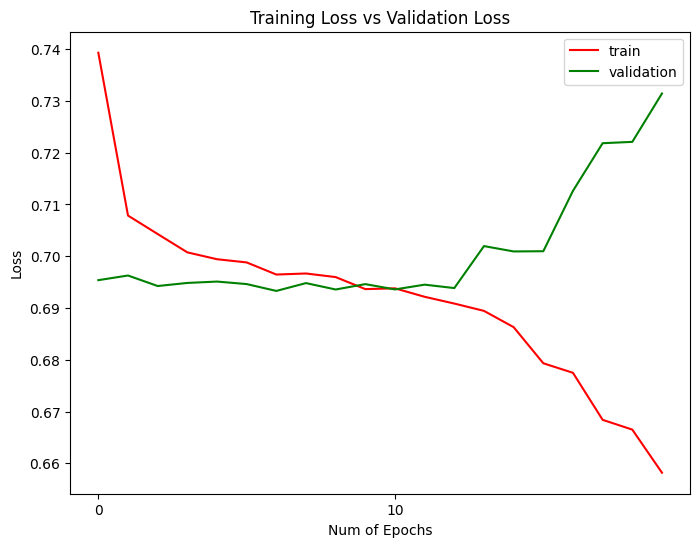

[I 2023-07-08 04:56:54,024] Trial 99 finished with value: 0.6932982206344604 and parameters: {'pT0Ref': 1.6973617052255734, 'ecmPow': 0.09857110902718022, 'coreRadius': 0.8098509089622926, 'coreFraction': 0.5579679134800257}. Best is trial 77 with value: 0.6937851905822754.


{'pT0Ref': 1.5441491051738305,
 'ecmPow': 0.026048713983753153,
 'coreRadius': 0.9625017585307307,
 'coreFraction': 0.5493101572602832}

In [17]:
n_trials=100

def objective(trial):
    pT0Ref = trial.suggest_float('pT0Ref', 0.5, 4)
    ecmPow = trial.suggest_float('ecmPow', 0.0, 0.4)
    coreRadius = trial.suggest_float('coreRadius', 0.1, 1.0)
    coreFraction = trial.suggest_float('coreFraction', 0.1, 1.0)
    print("Optuna suggested x = ",pT0Ref, ecmPow, coreRadius, coreFraction)
    loss = optimize(data0, pT0Ref, ecmPow, coreRadius, coreFraction)
    return loss

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

study.best_params 

In [18]:
study.best_trials

[FrozenTrial(number=77, state=TrialState.COMPLETE, values=[0.6937851905822754], datetime_start=datetime.datetime(2023, 7, 8, 3, 45, 11, 441308), datetime_complete=datetime.datetime(2023, 7, 8, 3, 48, 28, 615935), params={'pT0Ref': 1.5441491051738305, 'ecmPow': 0.026048713983753153, 'coreRadius': 0.9625017585307307, 'coreFraction': 0.5493101572602832}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pT0Ref': FloatDistribution(high=4.0, log=False, low=0.5, step=None), 'ecmPow': FloatDistribution(high=0.4, log=False, low=0.0, step=None), 'coreRadius': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'coreFraction': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=77, value=None)]

In [19]:
study.best_params

{'pT0Ref': 1.5441491051738305,
 'ecmPow': 0.026048713983753153,
 'coreRadius': 0.9625017585307307,
 'coreFraction': 0.5493101572602832}

/tmp/ipykernel_194013/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

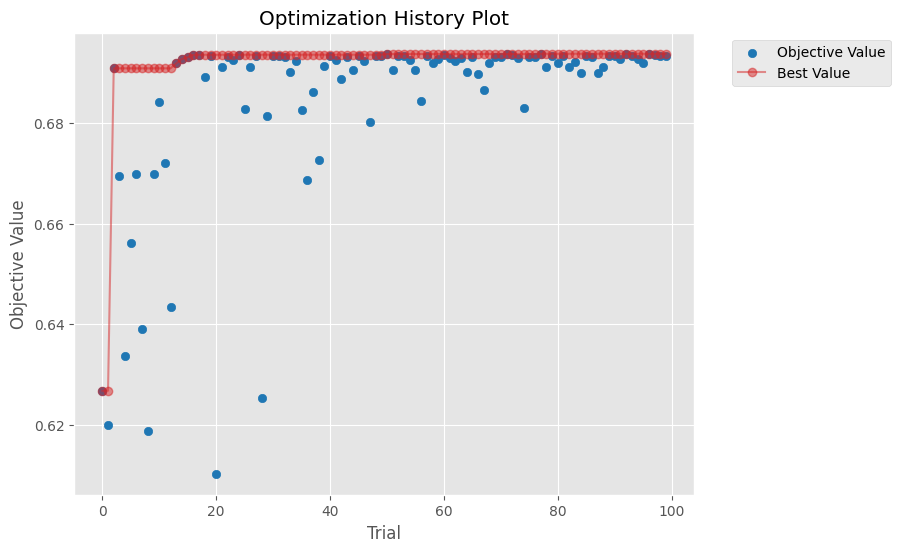

In [20]:
plot_optimization_history(study)

/tmp/ipykernel_194013/4291280223.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


<Axes: title={'center': 'Parallel Coordinate Plot'}>

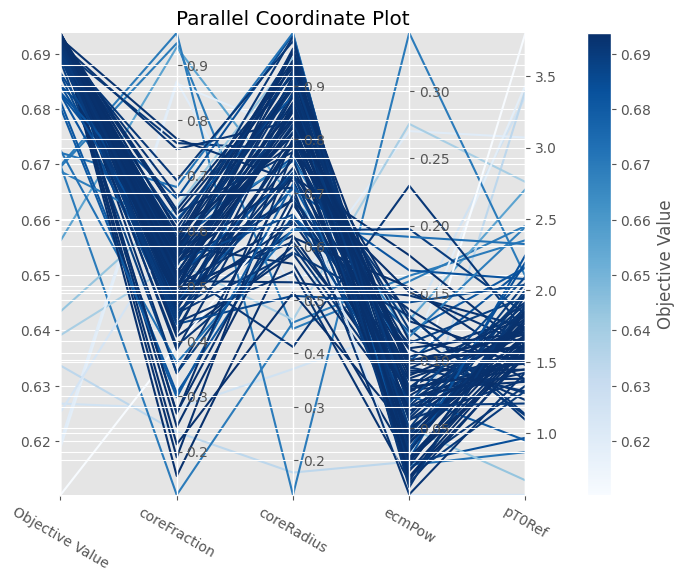

In [22]:
plot_parallel_coordinate(study)

/tmp/ipykernel_194013/927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2023-07-08 04:56:55,321] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: ylabel='coreFraction'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='coreRadius'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='ecmPow'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='coreFraction', ylabel='pT0Ref'>,
        <Axes: xlabel='coreRadius'>, <Axes: xlabel='ecmPow'>,
        <Axes: xlabel='pT0Ref'>]], dtype=object)

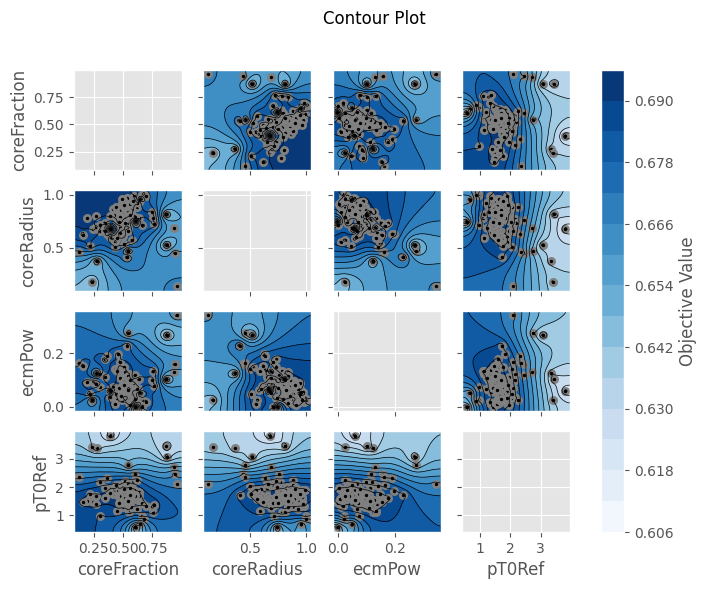

In [23]:
plot_contour(study)

/tmp/ipykernel_194013/2457830863.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='coreFraction', ylabel='Objective Value'>,
       <Axes: xlabel='coreRadius'>, <Axes: xlabel='ecmPow'>,
       <Axes: xlabel='pT0Ref'>], dtype=object)

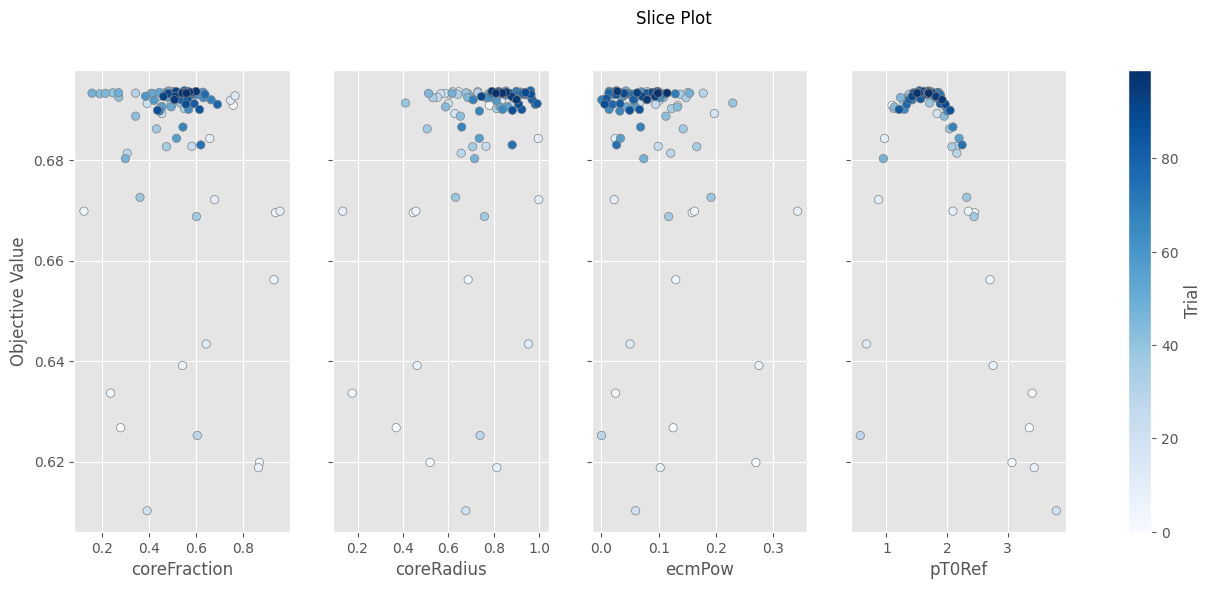

In [24]:
plot_slice(study)

/tmp/ipykernel_194013/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

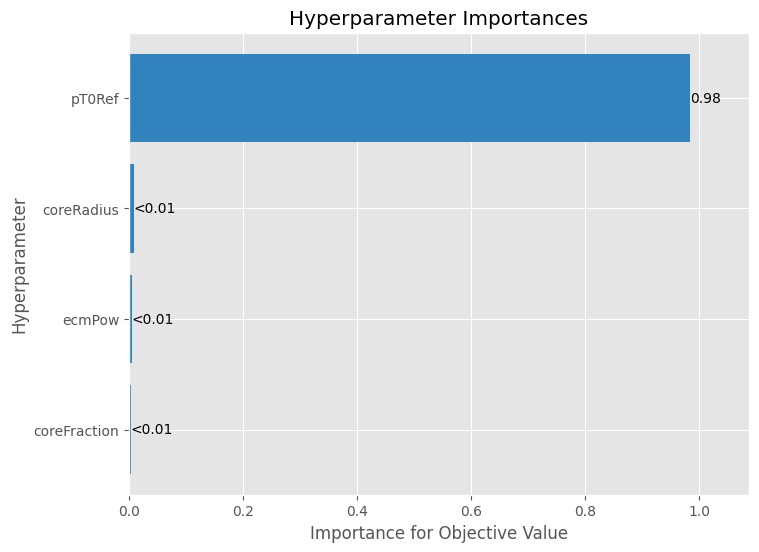

In [25]:
plot_param_importances(study)